## 04_Interpolate_BuoyData

* Grab buoy data from Bliss & Hutchings
* Remove erroneous lat/lon coordinates
* interpoalte to 30-min positions
* Save data to csvs for later analysis. 


## Import packages

In [1]:
# # math
# import numpy as np
# import numpy.ma as ma
# from bisect import bisect_left

# # navigating local files
# import sys, os, glob
# user = os.getlogin()

# # data
# import pandas as pd
# import xarray as xr

# # geo
# from pyproj import Geod
# from shapely import wkt
# from shapely.geometry import Point
# import pyproj
# geodesic_path = pyproj.Geod(ellps='WGS84')

# # time
# import datetime

# # plotting
# import matplotlib as mpl
# from matplotlib import pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.colors
# import matplotlib.gridspec as gridspec
# import cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cfeat
# from cartopy.mpl.geoaxes import GeoAxes


# # metpy
# import metpy.calc
# from metpy.units import units

# # Import the geodesic module from geopy library 
# from geopy.distance import geodesic
# from pyproj import Geod
# g = Geod(ellps='WGS84')

# from metpy.units import units




# # ignore shapely warning for geographic plots
# import shapely
# import warnings
# from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


# # import my own functions from within the same repository 
# #********************************************************
# # sys.path.append('./scripts/')
# # from LIB_accessIABP import (read_IABPdata_from_buoyID, read_IABPdata_from_localfile)
# # from LIB_geo_plot import (add_grid, add_coast, add_land, fix_cartopy_vectors)



# sys.path.append('/Users/mackenziejewell/Documents/GitHub/Libraries_functions/')
# from LIB_geo_func import (make_polygon,make_linestring, make_smooth_geographic_box, 
#                           regrid_geo_data, within_polygon_indices, polygon_mean_from_indices)
# from LIB_WillmesLeads import grab_WillmesLeads
# from LIB_PPdrift_NSIDC0116 import grab_ice_Drift, grab_icedrift_range
# from LIB_TB_NSIDC0001 import grab_TB_NSIDC0001
# from LIB_plotting import add_colorbar
# from LIB_sicNASAteam_NSIDC0051 import grab_sicNASAteam

# from LIB_geo_plot import (add_grid, add_coast, add_land, fix_cartopy_vectors, add_date)


# sys.path.append('./scripts/')
# from get_camp_track import GetCampPosition_cln

# from LIB_SIC_MODISAMSR2 import grab_SIC_MODISAMSR
# from analyze_SIDExbuoy import open_buoy_data, calc_velocity

%load_ext autoreload
%autoreload 2

from common_imports import *


import bisect
from pyproj import Geod
g = Geod(ellps='WGS84')


from pandas import Timestamp



def calculate_velocity(lons = [], lats = [], times = [], method = 'centered', skip_nans = True, acceleration = False):

#     method = 'centered'
#     method = 'forward'
#     method = 'backward'
    
    # whether or not to remove nan coordinates from velocity calculations
    # if False, would return nan velocities where nan coordinates exist
    
    if skip_nans:
        times = times[np.isnan(lons)==False]
        lons = lons[np.isnan(lats)==False]
        lats = lats[np.isnan(lats)==False]
        
    # times halfway between considered time steps
    time = np.array([])
    lon = np.array([])
    lat = np.array([])

    di = np.array([])
    az = np.array([])
    u = np.array([])
    v = np.array([])
    dx = np.array([])
    dy = np.array([])
    sp = np.array([])
    dt = np.array([])

    if str(method) == 'forward':
        index_range = range(0, len(lons)-1)
    elif str(method) == 'centered':
        index_range = range(1, len(lons)-1)
    elif str(method) == 'backward':
        index_range = range(1, len(lons))
            
            
    for ii in index_range:

        if str(method) == 'forward':
            ind_i = ii
            ind_f = ii+1
        elif str(method) == 'centered':
            ind_i = ii-1
            ind_f = ii+1
        elif str(method) == 'backward':
            ind_i = ii-1
            ind_f = ii
        else:
            break
            
        loc_i = (lats[ind_i], lons[ind_i])  # start location
        loc_f = (lats[ind_f], lons[ind_f])  # end location
        
        ti = times[ind_i]  # start time
        tf = times[ind_f]  # end time
        
        # compute forward and back azimuths, plus distance
        az12,az21,dist = g.inv(loc_i[1],loc_i[0],loc_f[1],loc_f[0])
        DI = dist*units('meter').to('cm')

        # angle from east
        beta = 90 * units('degree') - az12 * units('degree')
        if beta <= -180*units('degree'):
            beta += 360*units('degree')

        # calculate zonal, meridional displacements fmor azimuth
        DX = (dist*units('meter') * np.cos(beta.to('radian'))).to('cm')
        DY = (dist*units('meter') * np.sin(beta.to('radian'))).to('cm')
        
        # calculate length of timesteps used to calculate velocity
        DT = (tf - ti).total_seconds() * units('second')
        
        # save corresponding time to array
        if str(method) == 'forward':
            time = np.append(time, ti)
            lon = np.append(lon, loc_i[1])
            lat = np.append(lat, loc_i[0])
        elif str(method) == 'centered':
            time = np.append(time, times[ii])
            lon = np.append(lon, lons[ii])
            lat = np.append(lat, lats[ii])
        elif str(method) == 'backward':
            time = np.append(time, tf)
            lon = np.append(lon, loc_f[1])
            lat = np.append(lat, loc_f[0])
            
            
        u = np.append(u, DX/DT)
        v = np.append(v, DY/DT)
        sp = np.append(sp, DI/DT)
        dx = np.append(dx, DX)
        dy = np.append(dy, DY)
        di = np.append(di, DI)
        az  = np.append(az, az12)
        dt = np.append(dt, DT)

    
    if not acceleration:
        return u, v, sp, time, lat, lon, dx, dy, di, az, dt
    
    else:
        
        if str(method) == 'forward':
            
            index_range = range(0, len(time)-1)
            
            # calculate forward-looking accelerations 
            # (time step tt's acceleration assigned as between (tt) and (tt+1))
            DT = np.array([(time[tt+1]-time[tt]).total_seconds() for tt in index_range])*units('seconds')
            DU = np.array([(u[tt+1]-u[tt]).magnitude for tt in index_range])*units('cm/s')
            DV = np.array([(v[tt+1]-v[tt]).magnitude for tt in index_range])*units('cm/s')

            # acceleration
            au = np.append(DU/DT, np.nan)
            av = np.append(DV/DT, np.nan)
            acc = np.append(np.sqrt(DU**2+DV**2)/DT, np.nan)
            
        elif str(method) == 'centered':
            
            index_range = range(1, len(time)-1)
            
            # calculate centered accelerations 
            # (time step tt's acceleration assigned as between (tt-1) and (tt+1))
            DT = np.array([(time[tt+1]-time[tt-1]).total_seconds() for tt in index_range])*units('seconds')
            DU = np.array([(u[tt+1]-u[tt-1]).magnitude for tt in index_range])*units('cm/s')
            DV = np.array([(v[tt+1]-v[tt-1]).magnitude for tt in index_range])*units('cm/s')

            # acceleration
            au = np.append(np.append(np.nan, DU/DT), np.nan)
            av = np.append(np.append(np.nan, DV/DT), np.nan)
            acc = np.append(np.append(np.nan, np.sqrt(DU**2+DV**2)/DT), np.nan)
            
        elif str(method) == 'backward':
            
            index_range = range(1, len(time))
            
            # calculate backward-looking accelerations 
            # (time step tt's acceleration assigned as between (tt-1) and (tt))
            DT = np.array([(time[tt]-time[tt-1]).total_seconds() for tt in index_range])*units('seconds')
            DU = np.array([(u[tt]-u[tt-1]).magnitude for tt in index_range])*units('cm/s')
            DV = np.array([(v[tt]-v[tt-1]).magnitude for tt in index_range])*units('cm/s')

            # acceleration
            au = np.append(np.nan, DU/DT)
            av = np.append(np.nan, DV/DT)
            acc = np.append(np.nan, np.sqrt(DU**2+DV**2)/DT)
            
        
        return u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, acc
    
    

### Buoy coordinate data

In [2]:
# set list of path+name of csv files containing coordinates
# or set = None if not adding buoy coordinates
#==============================================================
csv_directory = '/Users/mackenziejewell/Desktop/sidex_tracks/data/'
#==============================================================
csv_files = []
if csv_directory != None:
    files = sorted(list(glob.glob1(csv_directory, "*.csv")));
    print('CSV files:')
    for ii in range(len(files)):
        csv_files.append(csv_directory+files[ii])
        print(csv_directory+files[ii])

CSV files:
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_23_300534061090050.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_24_300534061090090.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_25_300534061091050.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_26_300534061091060.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_27_300534061091070.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_28_300534061093020.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_29_300534061093030.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_30_300534061093040.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_31_300534061093070.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_32_300534061094090.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_33_300534061095060.csv
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_34_1_300534061095090.csv
/Users/mackenziejewell/Desktop/sidex_tr

In [3]:

#========================================================================
date_i = datetime(year=2021, month=2, day = 25, hour=0, minute = 0)
date_f = datetime(year=2021, month=6, day = 1, hour=0, minute = 0)
#========================================================================


In [4]:

# create list of desired dates
total_hours = ((date_f - date_i).days)*24 + 1
desired_dates = np.array([date_i + timedelta(hours=hour) for hour in range(total_hours)])

# (1) Test remove erroneous lat/lon coordinates on first file

### (1a) Read in raw data coordinates

In [5]:
file = csv_files[1]
print(file)
# grab buoy num
buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
print(f'buoy {buoy_num}')

df = pd.read_csv(file)

raw_dates = pd.to_datetime(df.datetime.values)
raw_lat = df.latitude.values
raw_lon = df.longitude.values

raw_dates


cleaned = {}
cleaned['lat'] = {}
cleaned['lon'] = {}
cleaned['time'] = {}
cleaned['acc'] = {}
cleaned['flag'] = {}

cleaned['lat']['v0'] = raw_lat
cleaned['lon']['v0'] = raw_lon
cleaned['time']['v0'] = raw_dates

/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_24_300534061090090.csv
buoy 24


### (1b) Calculate velocity and acceleration
Velocities and accelerations are calculated forward-looking:

#### Velocity: vel(t1) = $\frac{( pos(t2) - pos(t1) )}{(t2 - t1)}$  
#### Acceleration: acc(t1) = $\frac{( vel(t2) - vel(t1) )}{(t2 - t1)}$

So if acc(t1) is erroneously large, this would indicate that change from vel(t0) to vel(t1) might be erroneous, and therefore that pos(t2) would be erroneous. 

So flag at timestep t indicates position error at t+1. 

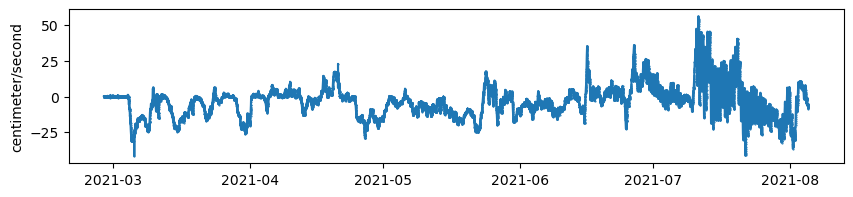

In [6]:
# calculate forward looking velocities and acclerations between reported times
out = calculate_velocity(lons = cleaned['lon']['v0'], 
                         lats = cleaned['lat']['v0'], 
                         times = cleaned['time']['v0'], 
                         method = 'forward', skip_nans = True, acceleration = True)
u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out
cleaned['acc']['v0'] = ACC

fig, ax = plt.subplots(figsize=(10,2))
plt.plot(time, u, marker='.', ms = 1)

0.022222222222222223 centimeter / second ** 2
0.01 % of the data is flagged


(18718.0, 18732.666666666668)

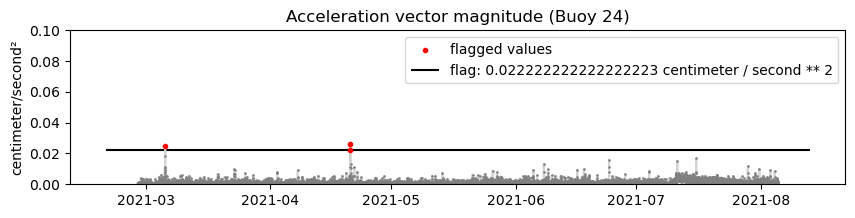

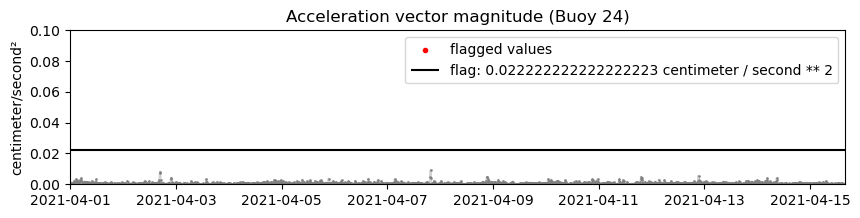

In [7]:
#=============================================
flag_thresh = 80 * units('cm/s')/units('hr').to('s')
#=============================================
print(flag_thresh)

# flag large accelerations
acc_flag = np.where(ACC > flag_thresh)[0]

# PLOT
fig, ax = plt.subplots(figsize=(10,2))
plt.title(f'Acceleration vector magnitude (Buoy {buoy_num})')
plt.ylim(0,0.1)
plt.plot(time, ACC, zorder=0, c='lightgray')
plt.scatter(time, ACC, marker='.', s=3, zorder=0, c='gray')
plt.scatter(time[acc_flag], ACC[acc_flag], marker='.', c='r', zorder=1, label='flagged values')
plt.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, colors='k', label=f'flag: {flag_thresh}')
plt.legend();
print(f'{100*len(acc_flag)/len(ACC):.2f} % of the data is flagged')



# PLOT
fig, ax = plt.subplots(figsize=(10,2))
plt.title(f'Acceleration vector magnitude (Buoy {buoy_num})')
plt.ylim(0,0.1)
plt.plot(time, ACC, zorder=0, c='lightgray')
plt.scatter(time, ACC, marker='.', s=3, zorder=0, c='gray')
plt.scatter(time[acc_flag], ACC[acc_flag], marker='.', c='r', zorder=1, label='flagged values')
plt.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, colors='k', label=f'flag: {flag_thresh}')
plt.legend();
plt.xlim(Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-15 16:00:00'))


### (1c) Define functions to identify and plot flagged values

In [8]:
from itertools import groupby

def ranges(lst):
    pos = (j - i for i, j in enumerate(lst))
    t = 0
    for i, els in groupby(pos):
        l = len(list(els))
        el = lst[t]
        t += l
        yield range(el, el+l)
        
def check_offset(lons=[], lats=[], ratio = 5):

    offtrack_ind = np.array([], dtype=int)
    ratios = np.array([1]) # fill first value since not calculated there
    
    for ii in range(1, len(lats)-1):

        loc_a = (lats[ii-1], lons[ii-1])  # location a
        loc_b = (lats[ii], lons[ii])      # location b
        loc_c = (lats[ii+1], lons[ii+1])  # location c

        # find "dist_ac" : dist between (ii-1) and (ii+1)
        #------------------------------------
        # compute forward and back azimuths, plus distance
        out = g.inv(loc_a[1],loc_a[0],loc_c[1],loc_c[0])
        dist_ac = out[2]*units('m').to('cm')

        # find distance "dist_abc" : from point (ii-1) to (ii) to (ii+1)
        #--------------------------------------------------------
        # find dist between (ii-1) and (ii)
        out = g.inv(loc_a[1],loc_a[0],loc_b[1],loc_b[0])
        dist_ab = out[2]*units('m').to('cm')
        # find dist between (ii) and (ii+1)
        out = g.inv(loc_b[1],loc_b[0],loc_c[1],loc_c[0])
        dist_bc = out[2]*units('m').to('cm')
        dist_abc = dist_ab+dist_bc

        # ratio of dist_abc to dist_ac should be ~1 if moving along constant drift track
        # would be exactly 1 if straight line
        # will be >> 1 if point is randomly off track
        if dist_ac == 0:
            distance_ratio = 1
        else:
            distance_ratio = (dist_abc/dist_ac).magnitude
        ratios = np.append(ratios, distance_ratio)
        
        if distance_ratio > ratio:
            offtrack_ind = np.append(offtrack_ind, ii)
            
    return offtrack_ind, ratios


# identify two types of conditions:
# - unrealistical drift track offsets (triangular shape, where individual point is offset from rest of drift track)
# - unrealistic accelerations
# flag three combinations:
# - huge accelerations
# - large drift track offsets if there is also moderate acceleration
# - moderate drift track offsets if there is also large acceleration
# if several points in a row flagged, only flag last point to be removed
# since this is usually the most erroneous point. And points before bad values sometimes get flagged
# points that really should be removed will be flagged later when run iteratively

def create_flags(lons = [], lats = [], acc = []):
    
    # flag moderate accelerations and drift track offsets
    flag1 = np.where(acc > 15 * units('cm/s')/units('hr').to('s'))[0]
    flag2, ratios = check_offset(lons = lons, lats = lats, ratio = 1.1)
    # merge acceleration and drift track shape flags
    merge_1 = np.array([], dtype=int)
    for flag in flag2:
        if flag in flag1:
            merge_1 = np.append(merge_1, flag)
            
    # flag moderate accelerations and drift track offsets
    flag3 = np.where(acc > 10 * units('cm/s')/units('hr').to('s'))[0]
    flag4, ratios = check_offset(lons = lons, lats = lats, ratio = 5)
    # merge acceleration and drift track shape flags
    merge_2 = np.array([], dtype=int)
    for flag in flag3:
        if flag in flag4:
            merge_2 = np.append(merge_2, flag)
    
    # merge extremely large acceleration flags with moderate combined flag
    acc_flag = np.where(acc > 80 * units('cm/s')/units('hr').to('s'))[0]
    merge_3 = np.unique(np.append(acc_flag, np.append(merge_2, merge_1)))
    
    # find groups of flagged values
    # and remove only 2nd values and on in group, 
    # since first values in flagged groups usually look alright
    ind_groups = list(ranges(merge_3))
    merge_flag = np.array([], dtype=int)
    for group in ind_groups:
        if len(group) == 1:
            merge_flag = np.append(merge_flag, group[0])
        elif len(group) == 2:
            merge_flag = np.append(merge_flag, group[-1])
        elif len(group) >= 3:
            merge_flag = np.append(merge_flag, group[-1])
    
    return merge_flag
        

    
def plot_flagtracks(lons = [], lats = [], flag = [], acc = [], lat_range = 0.003, lon_range = 0.01, buffer = 10):
    
    # plot range
    #-----------------
    dist_lon = g.inv(-155,72, -155+lon_range,72)[2]
    dist_lat = g.inv(-155,72, -155,72+lat_range)[2]
    print(f'Approximate plot dimensions:\n - zonal: {dist_lon:.2f} m\n - merid: {dist_lat:.2f} m\n')
    #-----------------
    
    for ind in flag:
        local_lons = lons[ind-buffer:ind+buffer]
        local_lats = lats[ind-buffer:ind+buffer]
        print(ind, raw_dates[ind], f'{acc[ind]:.5f}')
        
        fig, ax = plt.subplots(figsize=(2,2))
        ax.plot(local_lons, local_lats, c='lightgray', marker='.', zorder=0)
        ax.scatter(local_lons, local_lats, c = np.linspace(0,1,len(local_lats)), cmap='Greys', marker='.', zorder=0)
        ax.scatter(lons[ind], lats[ind], facecolor='None', edgecolor='r', marker='.', alpha=1, zorder=0)
        plt.xlim(lons[ind]-lon_range/2, lons[ind]+lon_range/2)
        plt.ylim(lats[ind]-lat_range/2, lats[ind]+lat_range/2)
        plt.show()
    
def plot_accelerations(fig, ax, time = [], acc = [], flag = [], linecolor='lightgray', flagcolor='k'):
    
    plt.plot(time, acc, zorder=0, c=linecolor)
#     plt.scatter(time, acc, marker='.', s=3, zorder=0, c='gray')
    plt.scatter(time[flag], acc[flag], marker='.', c=flagcolor, zorder=1, label=f'{len(flag)} flagged values')
    plt.legend();
    
    print(f'{100*len(flag)/len(time):.2f} % of the data is flagged')
    

### (1d) Find sequences of flagged values
Flag values with unrealistically large accelerations, unrealistic drift track shapes (one point far off of rest of drift track), or a combination of the two.

Plot the flagged value coordinates to confirm that the flags correspond to unphysical drift tracks

In [9]:
cleaned['flag']['v0'] = create_flags(lons = cleaned['lon']['v0'], 
                                     lats = cleaned['lat']['v0'], 
                                     acc = cleaned['acc']['v0'])

0.04 % of the data is flagged
Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

777 2021-03-05 20:10:26 0.02511 centimeter / second ** 2


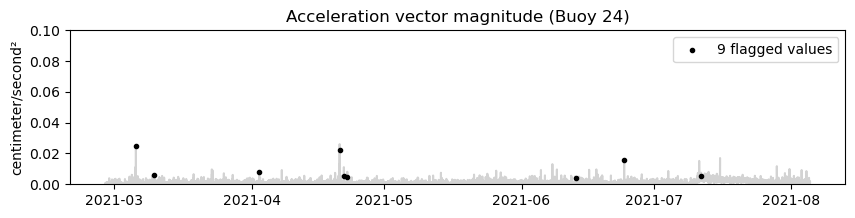

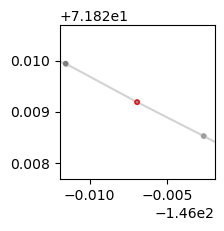

1373 2021-03-09 23:30:26 0.00577 centimeter / second ** 2


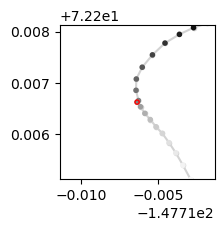

4745 2021-04-02 16:50:27 0.00800 centimeter / second ** 2


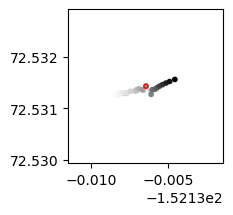

7308 2021-04-20 21:22:50 0.02236 centimeter / second ** 2


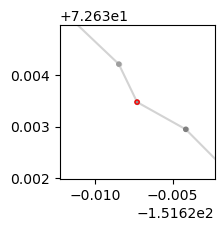

7444 2021-04-21 20:30:26 0.00531 centimeter / second ** 2


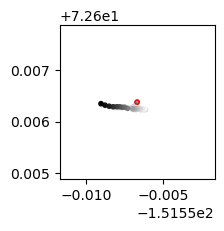

7555 2021-04-22 15:00:29 0.00472 centimeter / second ** 2


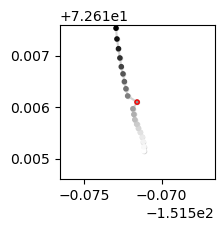

14977 2021-06-13 05:10:26 0.00421 centimeter / second ** 2


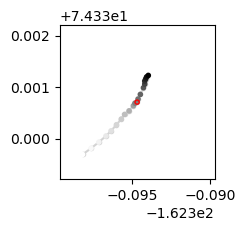

16557 2021-06-24 04:40:26 0.01602 centimeter / second ** 2


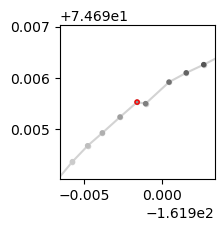

19069 2021-07-11 15:40:24 0.00567 centimeter / second ** 2


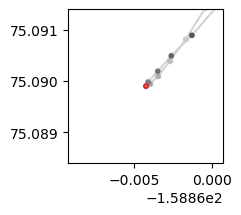

In [10]:
# plot accelerations and flagged values timeseries
fig, ax = plt.subplots(figsize=(10,2))
plt.title(f'Acceleration vector magnitude (Buoy {buoy_num})')
plt.ylim(0,0.1)
plot_accelerations(fig, ax, 
                   time = cleaned['time']['v0'][:-1], 
                   acc  = cleaned['acc']['v0'], 
                   flag = cleaned['flag']['v0'])

# plot drift tracks for individual flags
plot_flagtracks(lons = cleaned['lon']['v0'], 
                lats = cleaned['lat']['v0'], 
                flag = cleaned['flag']['v0'], 
                acc  = cleaned['acc']['v0'],
                lat_range = 0.003, lon_range = 0.01, buffer = 10)

### (1e) Remove flagged values
Remove flagged values. This is based on drift track errors seen in plots above

In [11]:
remove_indices = cleaned['flag']['v0']

print(f'>>> removing {len(remove_indices)} flagged values')

cleaned['lon']['v1'] = np.copy(cleaned['lon']['v0'])
cleaned['lat']['v1'] = np.copy(cleaned['lat']['v0'])
cleaned['time']['v1'] = pd.to_datetime(np.copy(cleaned['time']['v0']))

cleaned['lat']['v1'][remove_indices] = np.nan
cleaned['lon']['v1'][remove_indices] = np.nan

no_nan_locs = np.isnan(cleaned['lat']['v1']) == False

cleaned['lat']['v1'] = cleaned['lat']['v1'][no_nan_locs]
cleaned['lon']['v1'] = cleaned['lon']['v1'][no_nan_locs]
cleaned['time']['v1'] = cleaned['time']['v1'][no_nan_locs]



>>> removing 9 flagged values


### (1e) Rinse and repeat until there are no more flags!
Define function to run through whole process of removing nans in bulk

In [12]:
def iterate_cleaning(vi = '', vn = '', buoy_num = '', data_di = {}, 
                     show_velocity = True, show_acceleration = True, show_tracks = True):
    
    # calculate forward looking velocities and accelerations for vi
    #--------------------------------------------------------------
    out = calculate_velocity(lons = data_di['lon'][vi], 
                             lats = data_di['lat'][vi], 
                             times = data_di['time'][vi], 
                             method = 'forward', skip_nans = True, acceleration = True)
    u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out
    data_di['acc'][vi] = ACC
    
    if show_velocity:
        fig, ax = plt.subplots(figsize=(8,1))
        plt.title('u')
        plt.plot(time, u)
        plt.show()
    
    # flag values in vi
    #-----------------------------------------------------------
    data_di['flag'][vi] = create_flags(lons = data_di['lon'][vi], 
                                       lats = data_di['lat'][vi], 
                                       acc = data_di['acc'][vi])
    
    if show_acceleration:
        # plot flagged values
        #-----------------------------------------------------------
        # plot accelerations and flagged values timeseries
        l_colors = ['lightgray', 'lightgreen', 'skyblue', 'violet', 'lightcoral', 'gold' ]
        p_colors = ['gray', 'green', 'blue', 'darkmagenta', 'red',  'darkorange']

        fig, ax = plt.subplots(figsize=(10,2))
        plt.title(f'Acceleration vector magnitude (Buoy {buoy_num})')
        plt.ylim(0,0.1)
        for vv in range(int(vn[1:])):
            ver = f'v{vv}'
    #     for vv, ver in enumerate(['v0', 'v1']):
            plot_accelerations(fig, ax, 
                               time = data_di['time'][ver][:-1], 
                               acc  = data_di['acc'][ver], 
                               flag = data_di['flag'][ver], linecolor=l_colors[vv], flagcolor=p_colors[vv])
        plt.show()
    
    if show_tracks:
        # plot drift tracks for individual flags
        plot_flagtracks(lons = data_di['lon'][vi], 
                        lats = data_di['lat'][vi], 
                        flag = data_di['flag'][vi], 
                        acc  = data_di['acc'][vi],
                        lat_range = 0.003, lon_range = 0.01, buffer = 30)

    
    # remove flagged values
    #-----------------------------------------------------------
    remove_indices = data_di['flag'][vi]

    print(f'>>> removing {len(remove_indices)} flagged values')

    data_di['lon'][vn] = np.copy(data_di['lon'][vi])
    data_di['lat'][vn] = np.copy(data_di['lat'][vi])
    data_di['time'][vn] = pd.to_datetime(np.copy(data_di['time'][vi]))

    data_di['lat'][vn][remove_indices] = np.nan
    data_di['lon'][vn][remove_indices] = np.nan

    no_nan_locs = np.isnan(data_di['lat'][vn]) == False

    data_di['lat'][vn] = data_di['lat'][vn][no_nan_locs]
    data_di['lon'][vn] = data_di['lon'][vn][no_nan_locs]
    data_di['time'][vn] = data_di['time'][vn][no_nan_locs]
    
    return data_di

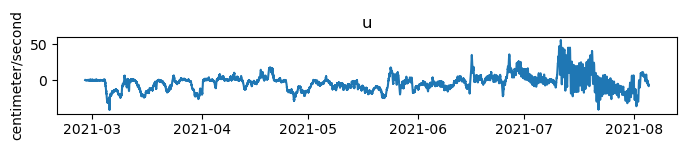

0.04 % of the data is flagged
0.00 % of the data is flagged


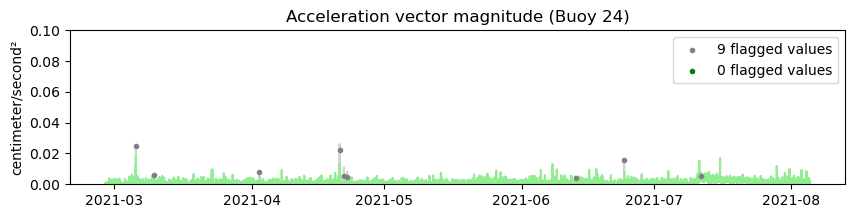

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values


In [13]:
# specify current and next versions
#==================================
vi = 'v1'
vn = 'v2'
#==================================

cleaned = iterate_cleaning(vi = vi, vn = vn, buoy_num = buoy_num, data_di = cleaned)

# Run iteratively on second file

/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_26_300534061091060.csv
buoy 26

v0  >>>  v1


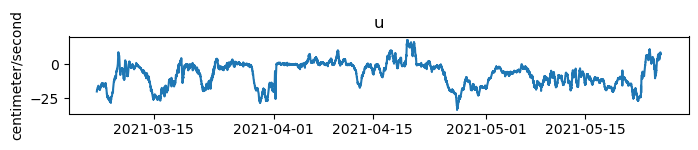

0.18 % of the data is flagged


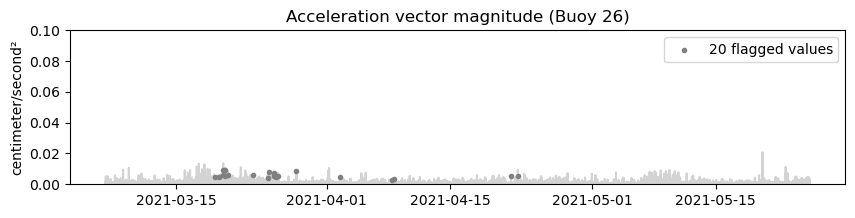

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

1786 2021-03-19 09:10:26 0.00449 centimeter / second ** 2


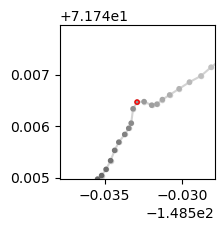

1846 2021-03-19 19:10:26 0.00469 centimeter / second ** 2


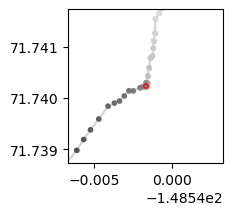

1912 2021-03-20 06:10:26 0.00574 centimeter / second ** 2


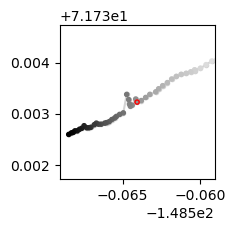

1918 2021-03-20 07:10:26 0.00926 centimeter / second ** 2


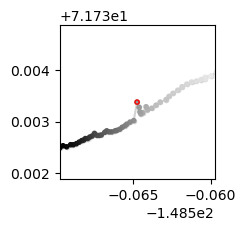

1950 2021-03-20 12:30:25 0.00565 centimeter / second ** 2


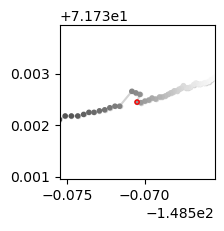

1953 2021-03-20 13:00:28 0.00923 centimeter / second ** 2


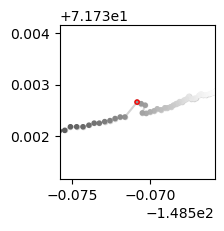

1991 2021-03-20 19:20:31 0.00572 centimeter / second ** 2


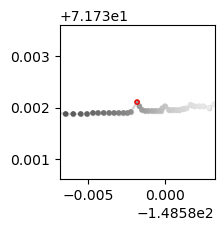

2406 2021-03-23 16:30:26 0.00601 centimeter / second ** 2


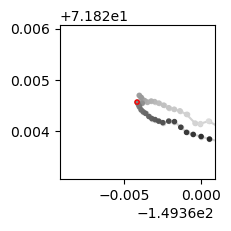

2647 2021-03-25 08:40:26 0.00436 centimeter / second ** 2


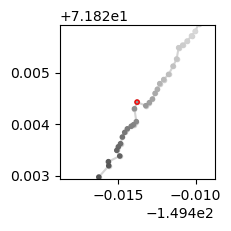

2659 2021-03-25 10:40:26 0.00770 centimeter / second ** 2


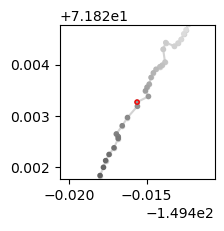

2740 2021-03-26 00:10:27 0.00707 centimeter / second ** 2


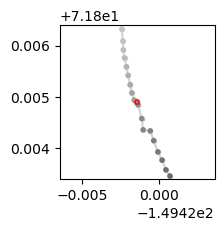

2743 2021-03-26 00:40:26 0.00567 centimeter / second ** 2


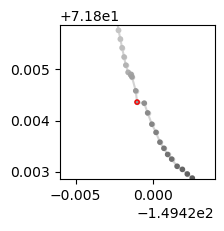

2773 2021-03-26 05:40:26 0.00500 centimeter / second ** 2


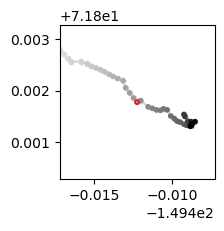

2802 2021-03-26 10:40:27 0.00542 centimeter / second ** 2


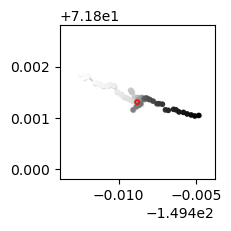

3075 2021-03-28 13:50:26 0.00831 centimeter / second ** 2


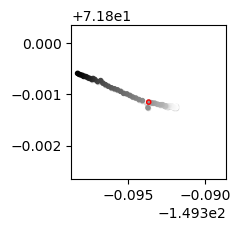

3776 2021-04-02 11:40:26 0.00449 centimeter / second ** 2


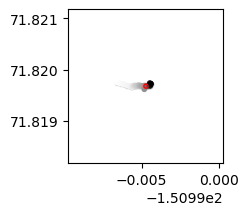

4552 2021-04-08 10:20:26 0.00290 centimeter / second ** 2


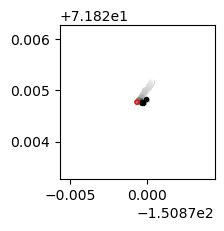

4579 2021-04-08 15:30:26 0.00321 centimeter / second ** 2


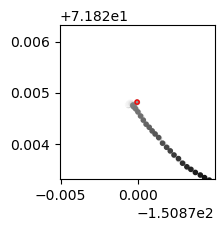

6429 2021-04-21 20:20:28 0.00555 centimeter / second ** 2


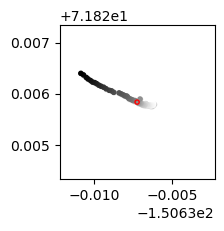

6540 2021-04-22 15:00:28 0.00556 centimeter / second ** 2


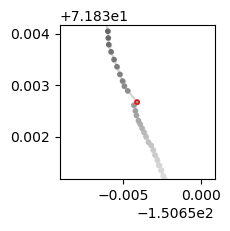

>>> removing 20 flagged values
v1  >>>  v2


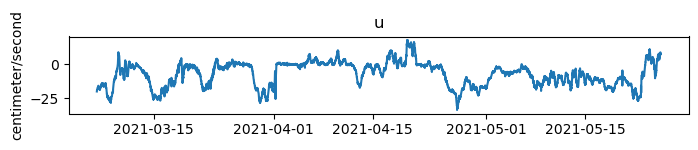

0.18 % of the data is flagged
0.04 % of the data is flagged


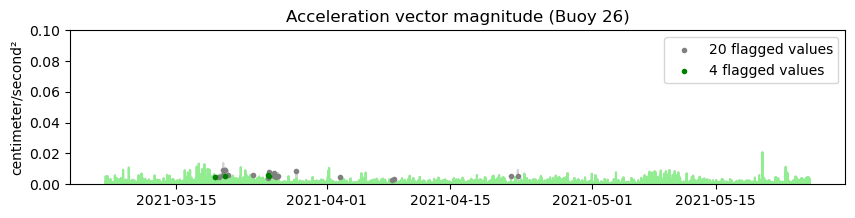

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

1786 2021-03-19 09:10:26 0.00484 centimeter / second ** 2


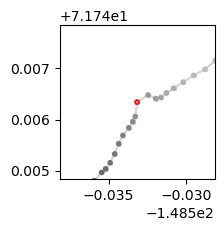

1946 2021-03-20 11:50:25 0.00545 centimeter / second ** 2


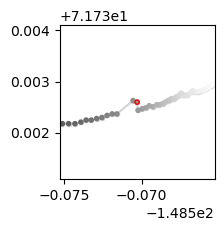

2639 2021-03-25 07:20:25 0.00592 centimeter / second ** 2


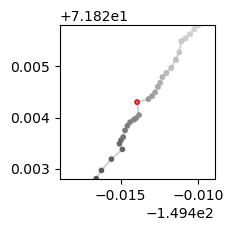

2648 2021-03-25 08:50:26 0.00530 centimeter / second ** 2


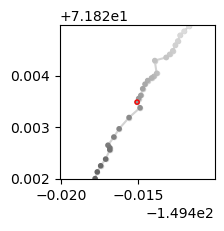

>>> removing 4 flagged values
v2  >>>  v3


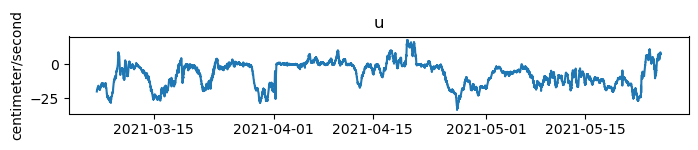

0.18 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


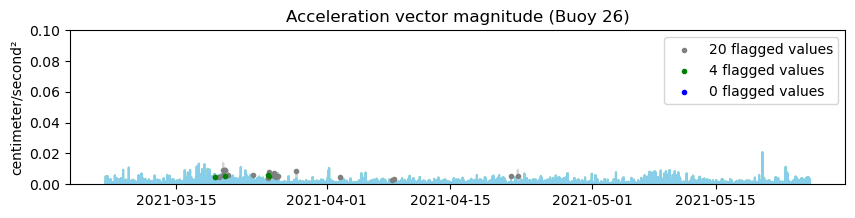

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values


In [14]:
file = csv_files[3]
print(file)

# grab buoy num
buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
print(f'buoy {buoy_num}\n')

df = pd.read_csv(file)
raw_dates = pd.to_datetime(df.datetime.values)
raw_lat = df.latitude.values
raw_lon = df.longitude.values

cleaned = {}
cleaned['lat'] = {}
cleaned['lon'] = {}
cleaned['time'] = {}
cleaned['acc'] = {}
cleaned['flag'] = {}

cleaned['lat']['v0'] = raw_lat
cleaned['lon']['v0'] = raw_lon
cleaned['time']['v0'] = raw_dates


iterations = 0
num_flags = 100

while (iterations < 6) and (num_flags > 0):
    
    # specify current and next versions
    #==================================
    vi = f'v{iterations}'
    vn = f'v{iterations+1}'
    #==================================
    print(f'{vi}  >>>  {vn}')
    
    # run cleaning
    cleaned = iterate_cleaning(vi = vi, vn = vn, buoy_num = buoy_num, data_di = cleaned)
    
    # find flags from vi used to create vf
    latest_flags = cleaned['flag'][vi]
    num_flags = len(latest_flags)

    iterations+=1

# Run in bulk across files!!!

/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_23_300534061090050.csv
buoy 23


v0  >>>  v1
0.29 % of the data is flagged


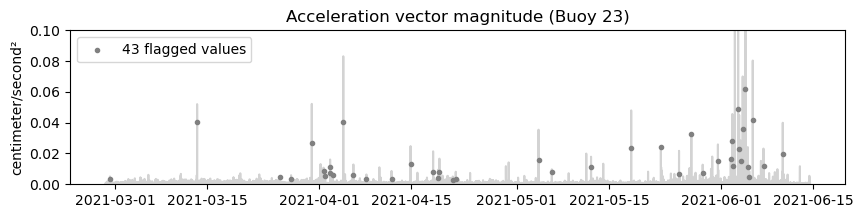

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

77 2021-02-28 05:30:25 0.00365 centimeter / second ** 2


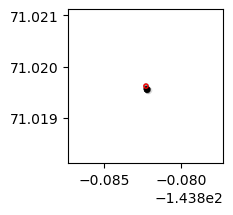

1859 2021-03-13 11:14:00 0.04024 centimeter / second ** 2


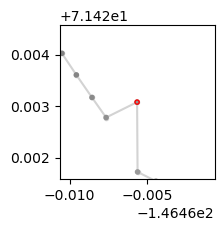

3662 2021-03-26 00:10:26 0.00466 centimeter / second ** 2


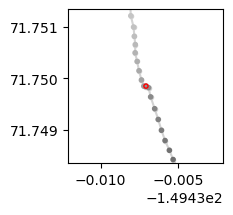

3890 2021-03-27 17:30:26 0.00372 centimeter / second ** 2


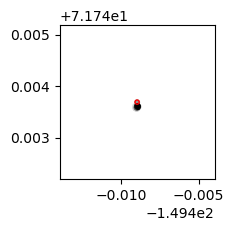

4329 2021-03-30 21:00:32 0.02689 centimeter / second ** 2


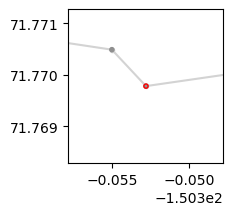

4585 2021-04-01 15:50:33 0.00874 centimeter / second ** 2


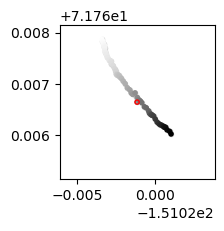

4621 2021-04-01 21:50:27 0.00551 centimeter / second ** 2


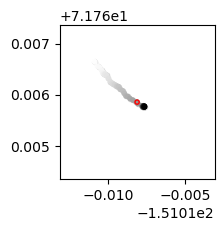

4705 2021-04-02 15:30:26 0.00714 centimeter / second ** 2


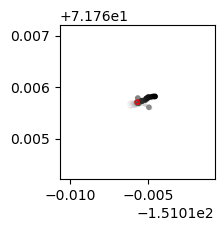

4707 2021-04-02 15:50:33 0.01102 centimeter / second ** 2


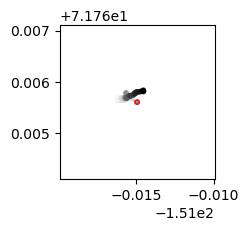

4748 2021-04-03 00:50:25 0.00620 centimeter / second ** 2


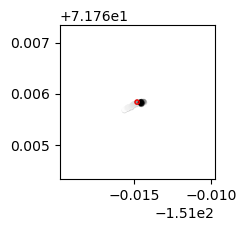

4932 2021-04-04 15:50:25 0.04045 centimeter / second ** 2


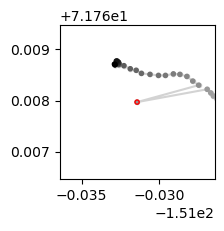

5128 2021-04-06 04:40:29 0.00620 centimeter / second ** 2


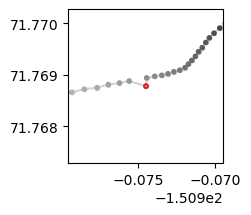

5405 2021-04-08 04:10:31 0.00362 centimeter / second ** 2


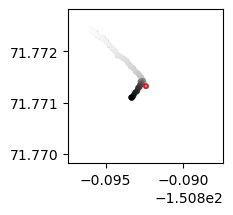

5920 2021-04-11 23:40:26 0.00331 centimeter / second ** 2


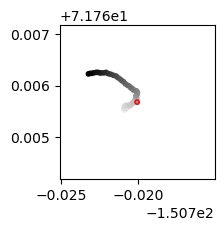

6334 2021-04-14 21:00:25 0.01294 centimeter / second ** 2


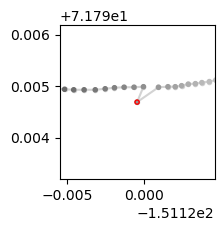

6824 2021-04-18 07:10:26 0.00823 centimeter / second ** 2


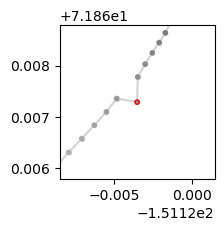

6936 2021-04-19 01:50:25 0.00401 centimeter / second ** 2


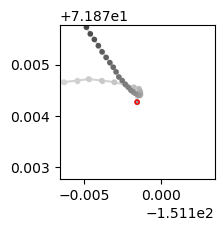

6962 2021-04-19 06:10:26 0.00781 centimeter / second ** 2


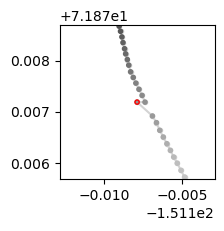

7249 2021-04-21 06:50:31 0.00306 centimeter / second ** 2


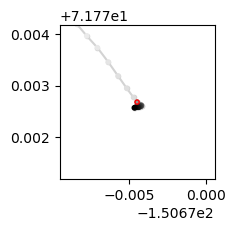

7300 2021-04-21 17:40:26 0.00341 centimeter / second ** 2


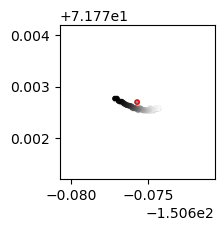

9108 2021-05-04 07:20:28 0.01570 centimeter / second ** 2


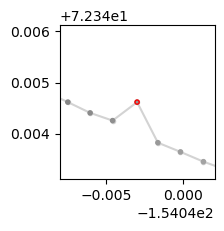

9398 2021-05-06 07:40:27 0.00802 centimeter / second ** 2


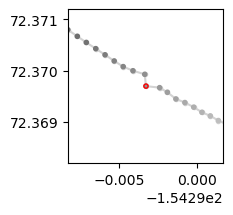

10253 2021-05-12 06:40:24 0.01090 centimeter / second ** 2


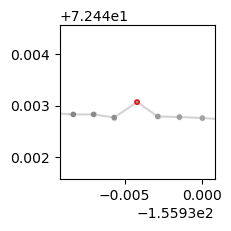

11130 2021-05-18 09:00:26 0.02326 centimeter / second ** 2


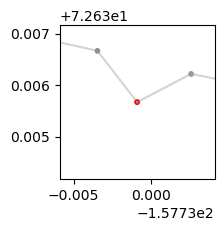

11778 2021-05-22 21:00:26 0.02438 centimeter / second ** 2


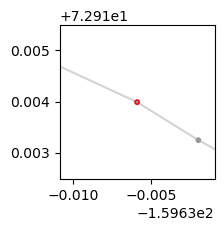

12176 2021-05-25 15:20:27 0.00658 centimeter / second ** 2


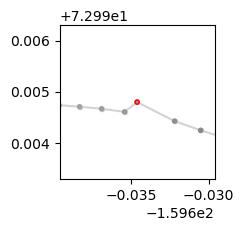

12444 2021-05-27 12:00:26 0.03268 centimeter / second ** 2


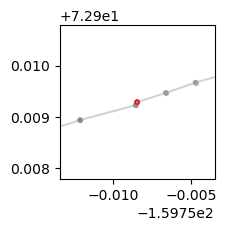

12693 2021-05-29 05:30:28 0.00746 centimeter / second ** 2


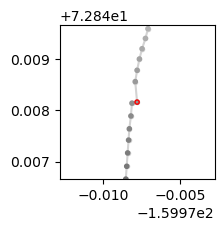

13025 2021-05-31 13:00:33 0.01490 centimeter / second ** 2


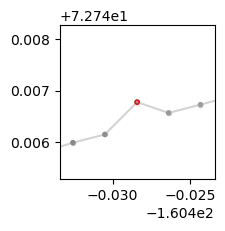

13304 2021-06-02 11:40:35 0.01621 centimeter / second ** 2


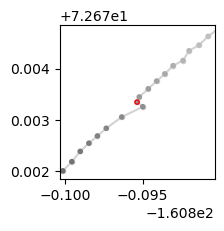

13339 2021-06-02 17:30:29 0.02794 centimeter / second ** 2


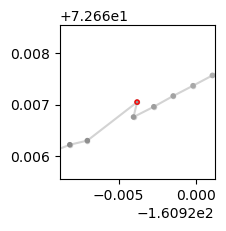

13346 2021-06-02 18:40:32 0.01204 centimeter / second ** 2


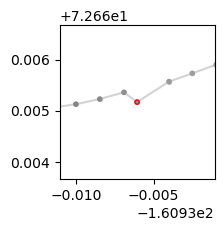

13396 2021-06-03 03:00:36 0.10679 centimeter / second ** 2


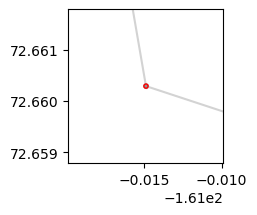

13466 2021-06-03 14:50:29 0.04885 centimeter / second ** 2


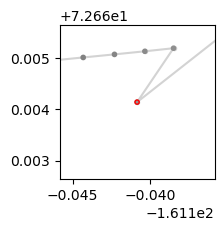

13488 2021-06-03 18:30:33 0.02310 centimeter / second ** 2


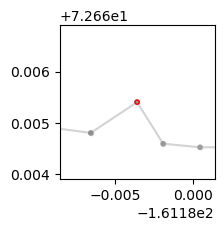

13518 2021-06-03 23:30:28 0.01482 centimeter / second ** 2


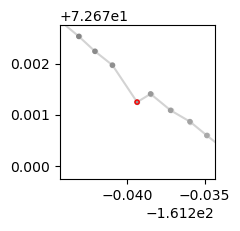

13565 2021-06-04 07:20:36 0.03592 centimeter / second ** 2


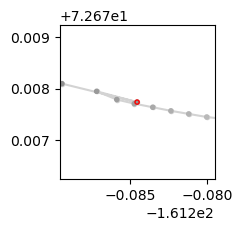

13625 2021-06-04 17:20:34 0.06168 centimeter / second ** 2


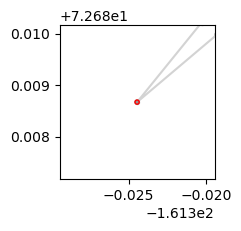

13677 2021-06-05 02:00:30 0.01127 centimeter / second ** 2


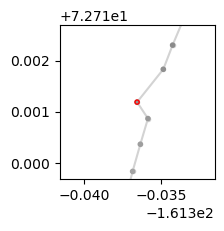

13709 2021-06-05 07:20:36 0.00458 centimeter / second ** 2


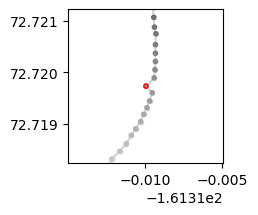

13785 2021-06-05 20:00:33 0.04154 centimeter / second ** 2


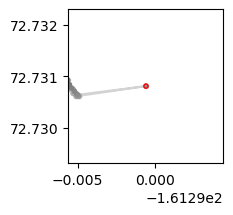

14019 2021-06-07 11:00:27 0.01176 centimeter / second ** 2


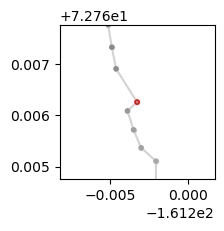

14439 2021-06-10 09:20:38 0.01993 centimeter / second ** 2


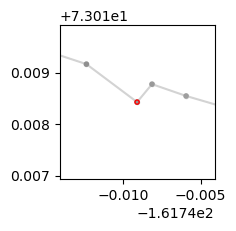

>>> removing 43 flagged values

v1  >>>  v2
0.29 % of the data is flagged
0.03 % of the data is flagged


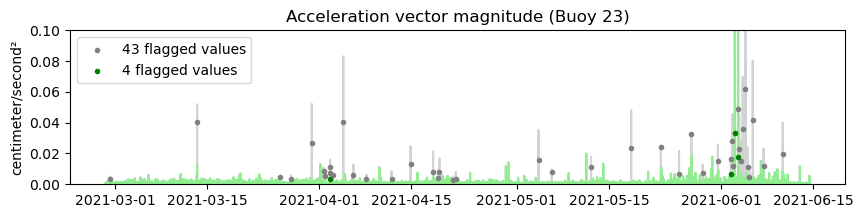

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

4699 2021-04-02 14:10:25 0.00343 centimeter / second ** 2


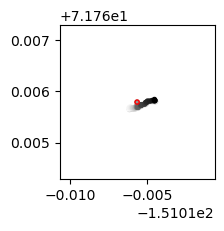

13274 2021-06-02 06:40:28 0.00683 centimeter / second ** 2


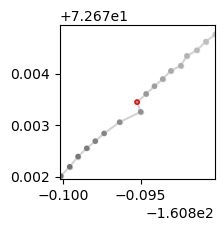

13363 2021-06-02 21:30:27 0.03321 centimeter / second ** 2


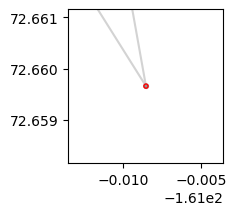

13432 2021-06-03 09:00:26 0.01752 centimeter / second ** 2


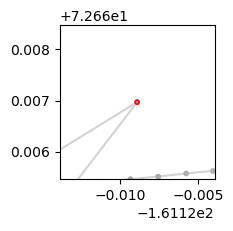

>>> removing 4 flagged values

v2  >>>  v3
0.29 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


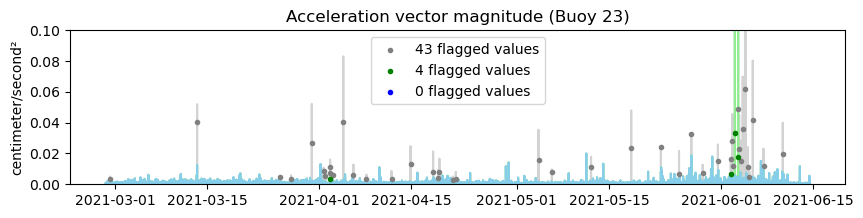

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_24_300534061090090.csv
buoy 24


v0  >>>  v1
0.04 % of the data is flagged


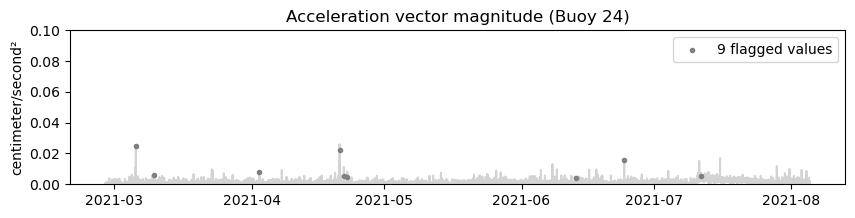

>>> removing 9 flagged values

v1  >>>  v2
0.04 % of the data is flagged
0.00 % of the data is flagged


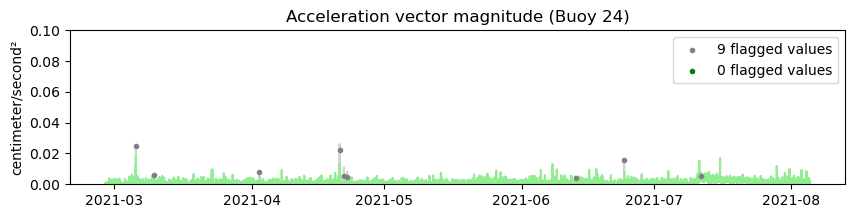

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_25_300534061091050.csv
buoy 25


v0  >>>  v1
0.72 % of the data is flagged


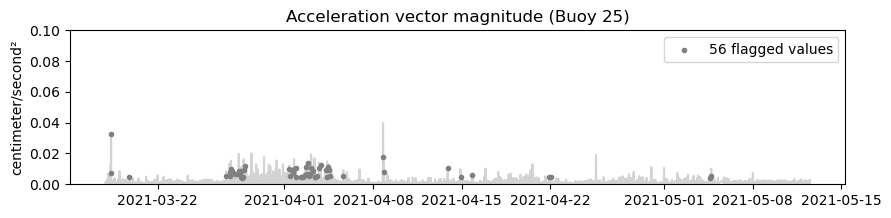

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

60 2021-03-18 07:00:25 0.00753 centimeter / second ** 2


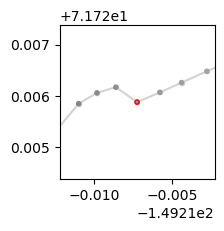

63 2021-03-18 07:34:03 0.03253 centimeter / second ** 2


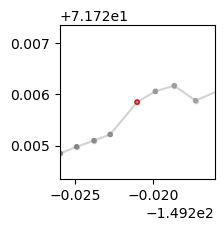

267 2021-03-19 17:30:26 0.00462 centimeter / second ** 2


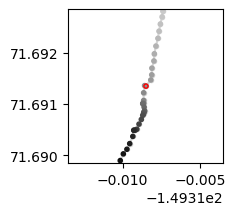

1362 2021-03-27 10:00:26 0.00555 centimeter / second ** 2


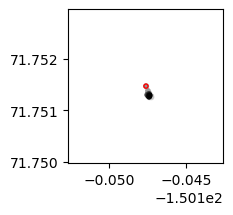

1394 2021-03-27 16:10:26 0.00566 centimeter / second ** 2


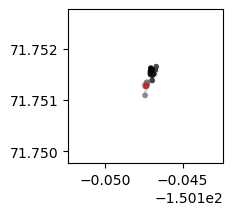

1396 2021-03-27 16:30:26 0.00784 centimeter / second ** 2


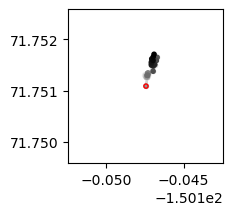

1411 2021-03-27 19:00:33 0.00998 centimeter / second ** 2


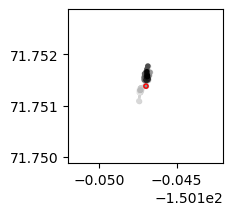

1426 2021-03-27 21:40:28 0.00831 centimeter / second ** 2


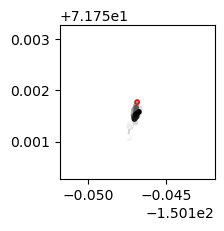

1458 2021-03-28 03:00:30 0.00651 centimeter / second ** 2


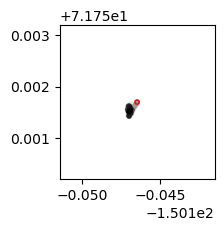

1481 2021-03-28 07:00:31 0.00659 centimeter / second ** 2


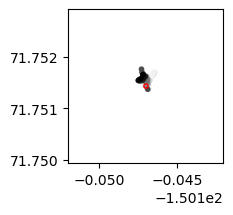

1497 2021-03-28 09:50:38 0.00869 centimeter / second ** 2


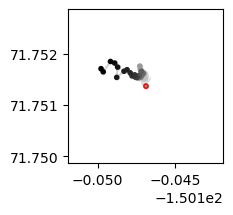

1508 2021-03-28 11:40:27 0.00712 centimeter / second ** 2


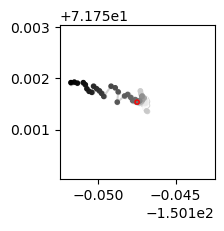

1521 2021-03-28 13:50:28 0.00444 centimeter / second ** 2


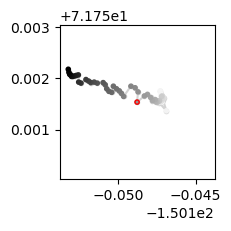

1524 2021-03-28 14:20:28 0.00864 centimeter / second ** 2


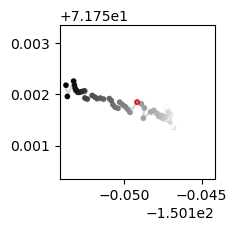

1529 2021-03-28 15:10:27 0.00437 centimeter / second ** 2


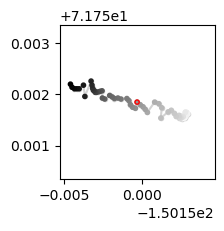

1541 2021-03-28 17:10:30 0.00482 centimeter / second ** 2


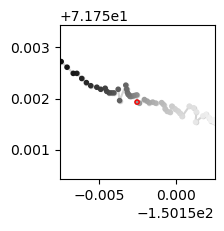

1552 2021-03-28 19:00:32 0.00927 centimeter / second ** 2


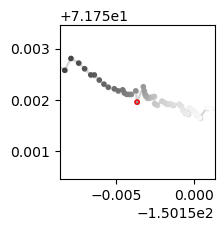

1568 2021-03-28 21:40:27 0.01215 centimeter / second ** 2


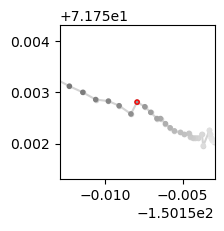

2070 2021-04-01 09:20:27 0.01016 centimeter / second ** 2


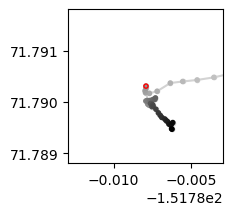

2080 2021-04-01 11:00:26 0.00525 centimeter / second ** 2


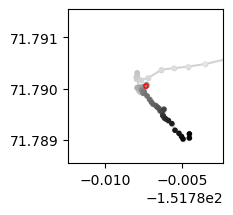

2108 2021-04-01 15:40:27 0.00772 centimeter / second ** 2


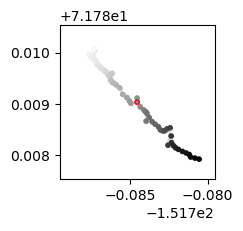

2114 2021-04-01 16:40:30 0.00728 centimeter / second ** 2


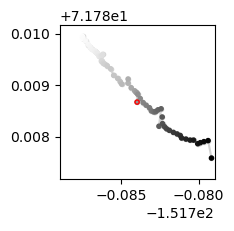

2126 2021-04-01 18:40:32 0.00994 centimeter / second ** 2


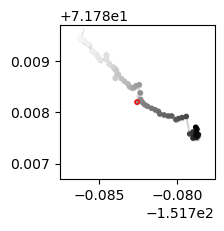

2142 2021-04-01 21:20:27 0.01089 centimeter / second ** 2


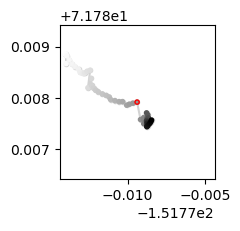

2152 2021-04-01 23:00:28 0.00499 centimeter / second ** 2


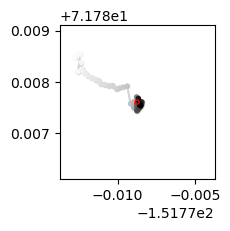

2209 2021-04-02 08:30:54 0.00497 centimeter / second ** 2


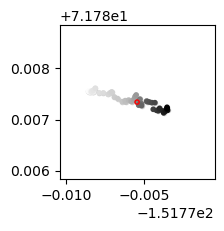

2225 2021-04-02 11:10:26 0.00461 centimeter / second ** 2


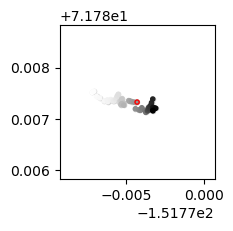

2247 2021-04-02 14:50:28 0.00573 centimeter / second ** 2


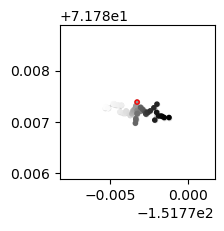

2257 2021-04-02 16:30:28 0.01096 centimeter / second ** 2


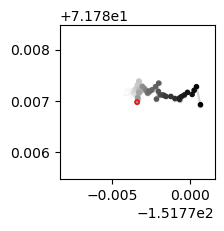

2270 2021-04-02 18:40:31 0.00690 centimeter / second ** 2


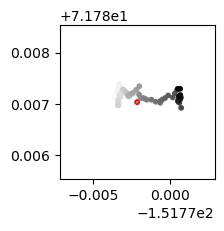

2285 2021-04-02 21:10:28 0.01387 centimeter / second ** 2


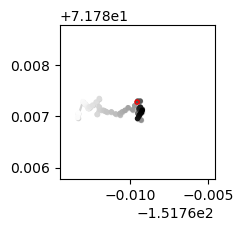

2299 2021-04-02 23:30:28 0.00511 centimeter / second ** 2


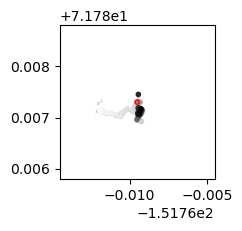

2307 2021-04-03 00:50:26 0.00642 centimeter / second ** 2


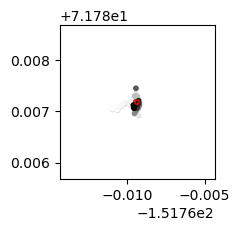

2320 2021-04-03 03:00:30 0.01081 centimeter / second ** 2


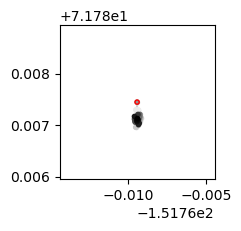

2343 2021-04-03 07:00:28 0.00861 centimeter / second ** 2


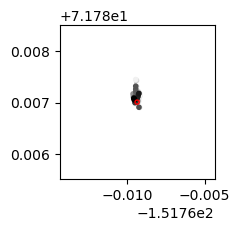

2358 2021-04-03 09:30:31 0.00462 centimeter / second ** 2


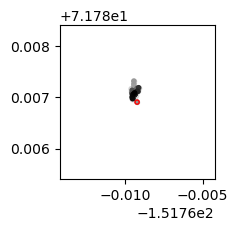

2367 2021-04-03 11:00:26 0.00469 centimeter / second ** 2


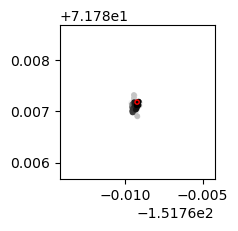

2390 2021-04-03 14:50:26 0.00524 centimeter / second ** 2


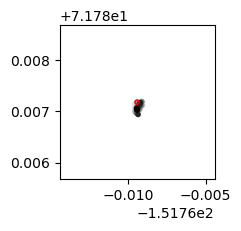

2412 2021-04-03 18:30:31 0.01059 centimeter / second ** 2


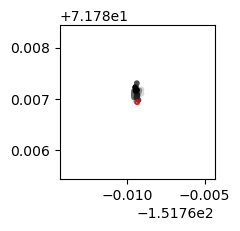

2427 2021-04-03 21:10:28 0.01227 centimeter / second ** 2


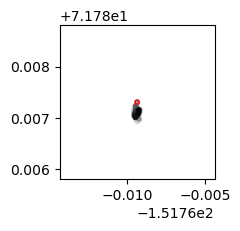

2480 2021-04-04 06:10:27 0.00914 centimeter / second ** 2


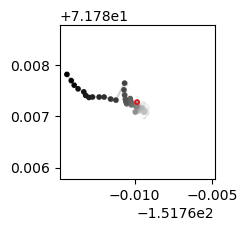

2491 2021-04-04 08:10:27 0.00470 centimeter / second ** 2


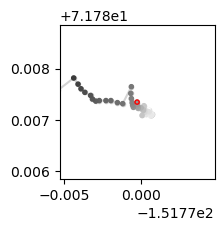

2497 2021-04-04 09:10:29 0.01019 centimeter / second ** 2


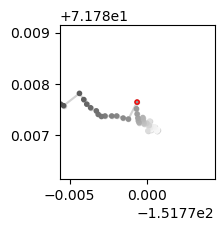

2509 2021-04-04 11:10:28 0.01130 centimeter / second ** 2


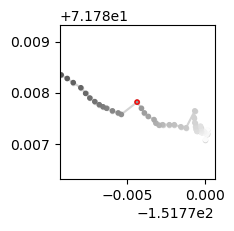

2523 2021-04-04 13:30:30 0.00950 centimeter / second ** 2


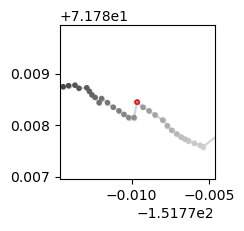

2530 2021-04-04 14:40:27 0.00564 centimeter / second ** 2


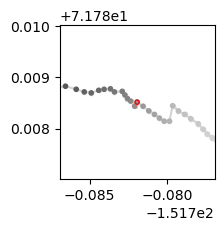

2658 2021-04-05 16:00:25 0.00508 centimeter / second ** 2


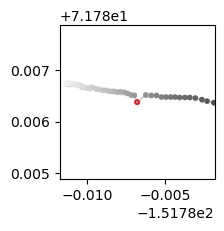

3085 2021-04-08 19:20:27 0.01793 centimeter / second ** 2


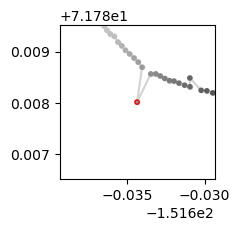

3095 2021-04-08 21:00:26 0.00799 centimeter / second ** 2


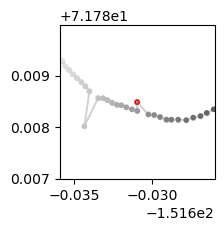

3798 2021-04-13 21:50:25 0.01086 centimeter / second ** 2


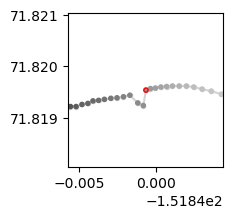

3940 2021-04-14 22:00:31 0.00460 centimeter / second ** 2


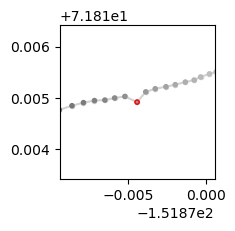

4065 2021-04-15 19:40:28 0.00582 centimeter / second ** 2


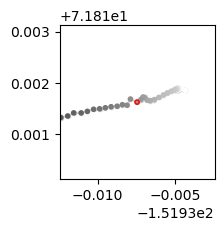

4933 2021-04-21 21:50:26 0.00493 centimeter / second ** 2


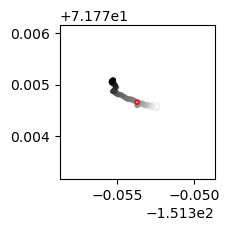

4951 2021-04-22 00:50:26 0.00442 centimeter / second ** 2


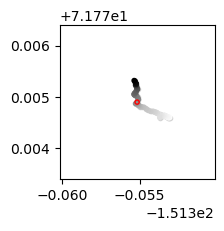

6762 2021-05-04 15:00:25 0.00419 centimeter / second ** 2


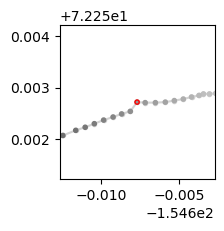

6777 2021-05-04 17:30:27 0.00537 centimeter / second ** 2


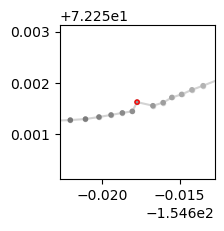

>>> removing 56 flagged values

v1  >>>  v2
0.72 % of the data is flagged
0.08 % of the data is flagged


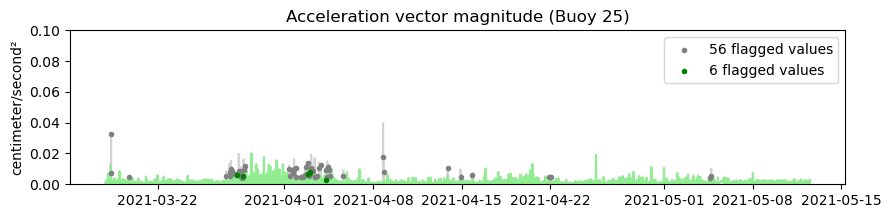

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

1470 2021-03-28 05:10:26 0.00627 centimeter / second ** 2


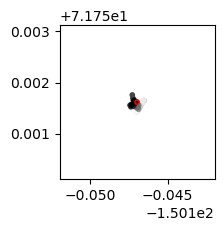

1524 2021-03-28 14:20:28 0.00519 centimeter / second ** 2


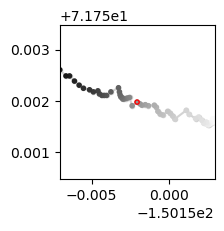

2253 2021-04-02 15:50:27 0.00677 centimeter / second ** 2


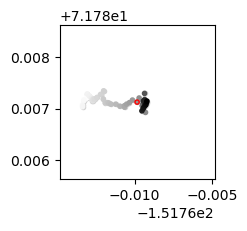

2266 2021-04-02 18:00:27 0.00708 centimeter / second ** 2


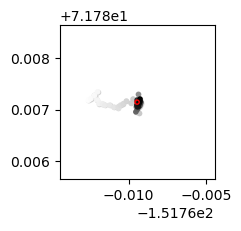

2275 2021-04-02 19:30:26 0.00811 centimeter / second ** 2


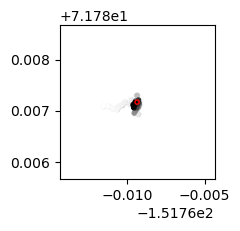

2440 2021-04-03 23:30:55 0.00300 centimeter / second ** 2


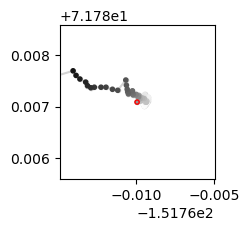

>>> removing 6 flagged values

v2  >>>  v3
0.72 % of the data is flagged
0.08 % of the data is flagged
0.00 % of the data is flagged


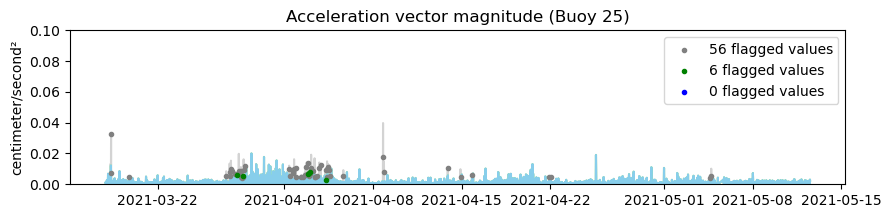

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_26_300534061091060.csv
buoy 26


v0  >>>  v1
0.18 % of the data is flagged


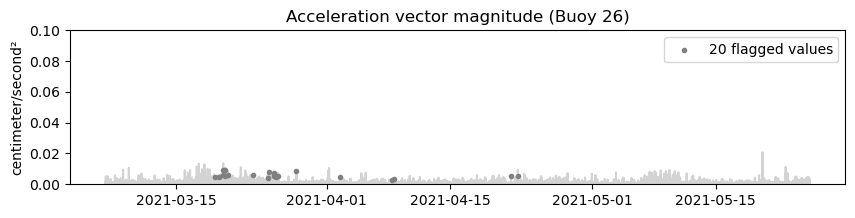

>>> removing 20 flagged values

v1  >>>  v2
0.18 % of the data is flagged
0.04 % of the data is flagged


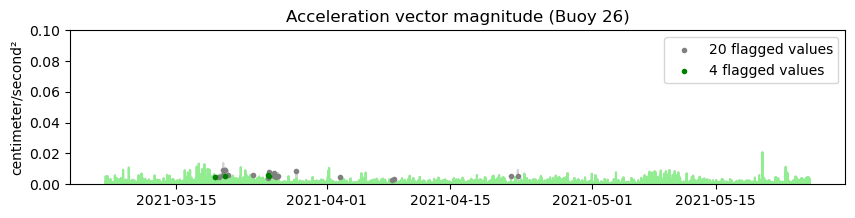

>>> removing 4 flagged values

v2  >>>  v3
0.18 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


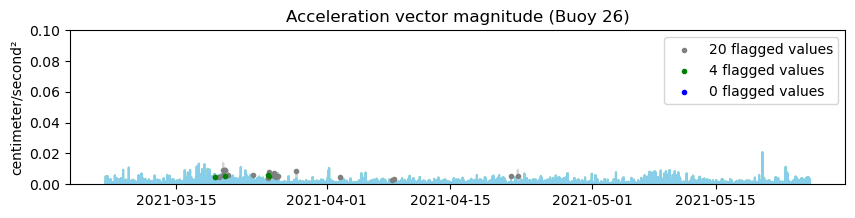

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_27_300534061091070.csv
buoy 27


v0  >>>  v1
0.45 % of the data is flagged


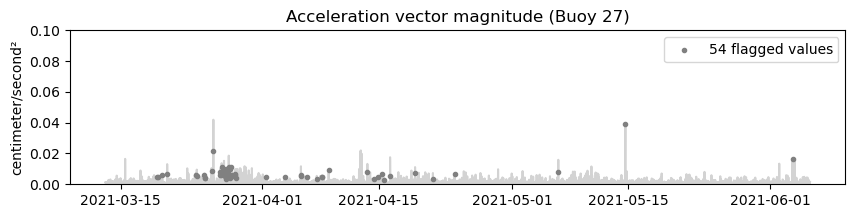

>>> removing 54 flagged values

v1  >>>  v2
0.45 % of the data is flagged
0.06 % of the data is flagged


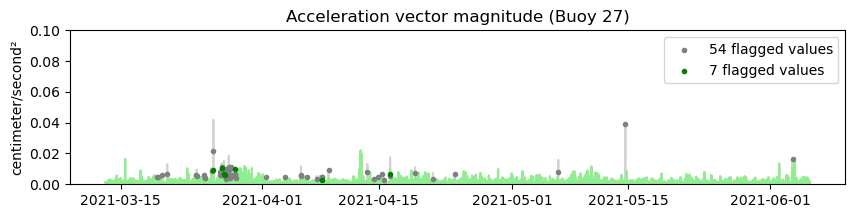

>>> removing 7 flagged values

v2  >>>  v3
0.45 % of the data is flagged
0.06 % of the data is flagged
0.00 % of the data is flagged


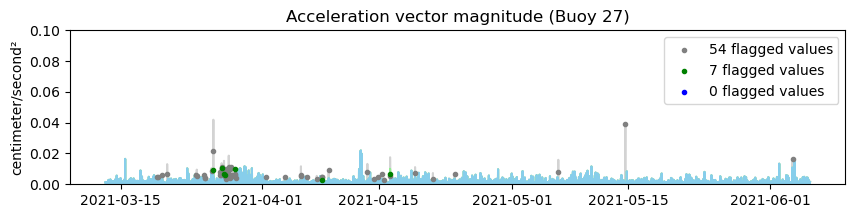

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_28_300534061093020.csv
buoy 28


v0  >>>  v1
0.09 % of the data is flagged


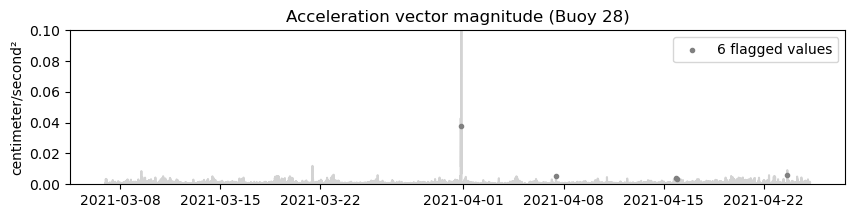

>>> removing 6 flagged values

v1  >>>  v2
0.09 % of the data is flagged
0.03 % of the data is flagged


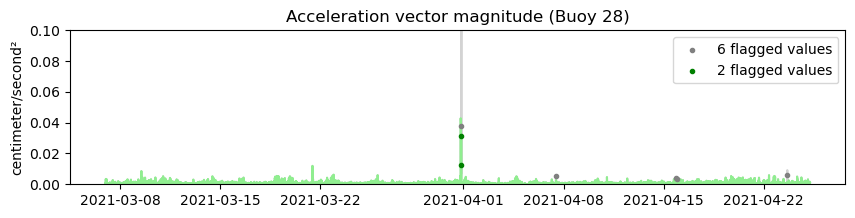

>>> removing 2 flagged values

v2  >>>  v3
0.09 % of the data is flagged
0.03 % of the data is flagged
0.01 % of the data is flagged


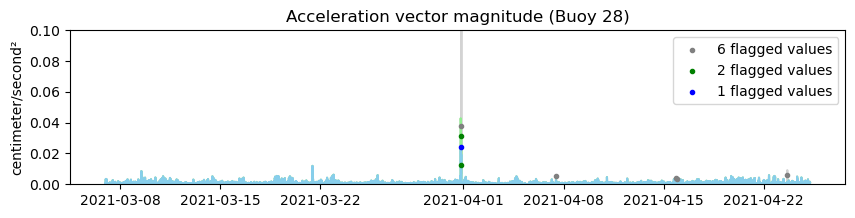

>>> removing 1 flagged values

v3  >>>  v4
0.09 % of the data is flagged
0.03 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


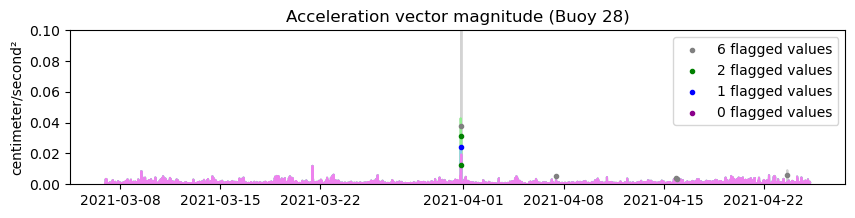

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_29_300534061093030.csv
buoy 29


v0  >>>  v1
0.24 % of the data is flagged


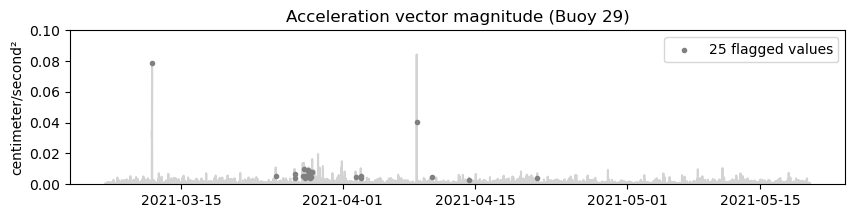

>>> removing 25 flagged values

v1  >>>  v2
0.24 % of the data is flagged
0.04 % of the data is flagged


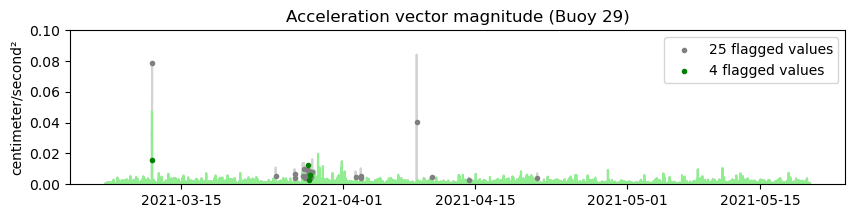

>>> removing 4 flagged values

v2  >>>  v3
0.24 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


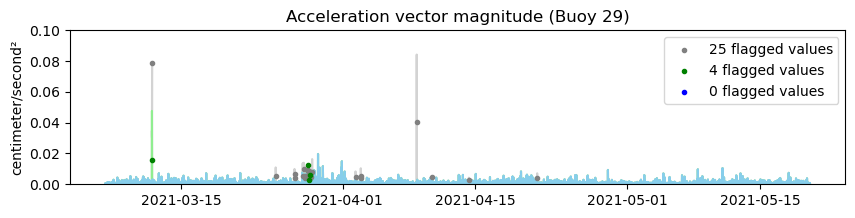

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_30_300534061093040.csv
buoy 30


v0  >>>  v1
1.54 % of the data is flagged


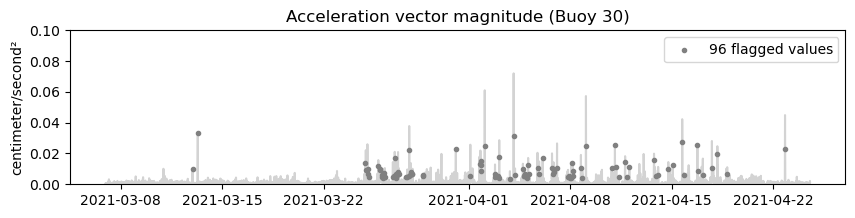

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

864 2021-03-12 23:20:25 0.00983 centimeter / second ** 2


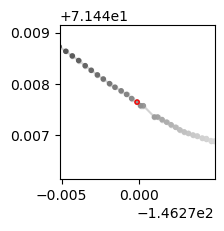

915 2021-03-13 07:53:59 0.03322 centimeter / second ** 2


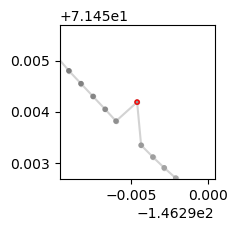

2571 2021-03-24 21:10:24 0.01370 centimeter / second ** 2


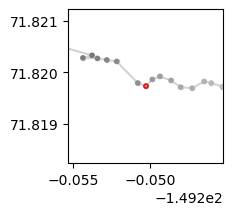

2577 2021-03-24 22:10:29 0.00926 centimeter / second ** 2


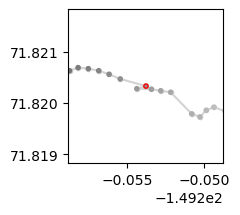

2593 2021-03-25 00:50:29 0.00964 centimeter / second ** 2


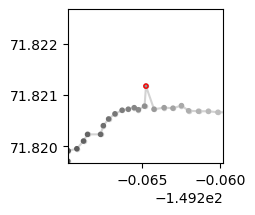

2602 2021-03-25 02:20:27 0.00689 centimeter / second ** 2


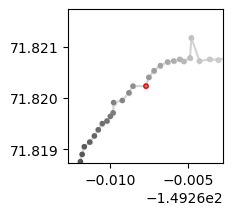

2606 2021-03-25 03:00:54 0.00477 centimeter / second ** 2


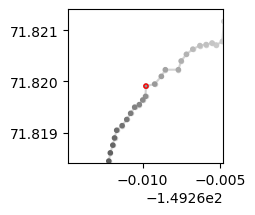

2701 2021-03-25 18:50:29 0.01213 centimeter / second ** 2


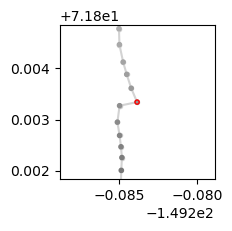

2716 2021-03-25 21:20:26 0.00995 centimeter / second ** 2


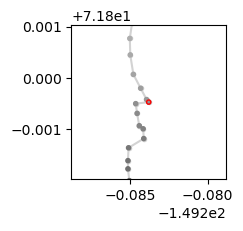

2721 2021-03-25 22:10:28 0.00936 centimeter / second ** 2


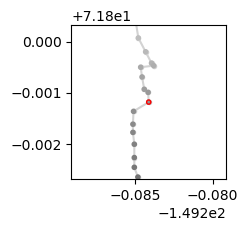

2733 2021-03-26 00:10:28 0.00623 centimeter / second ** 2


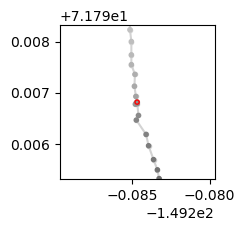

2736 2021-03-26 00:40:28 0.00485 centimeter / second ** 2


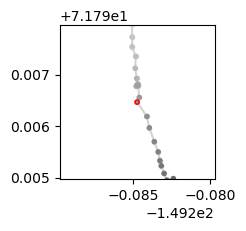

2744 2021-03-26 02:00:26 0.00438 centimeter / second ** 2


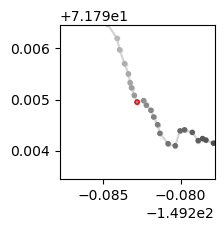

2752 2021-03-26 03:20:28 0.00764 centimeter / second ** 2


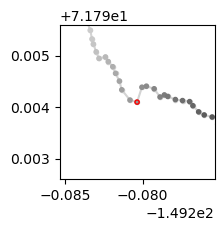

2767 2021-03-26 05:50:27 0.00485 centimeter / second ** 2


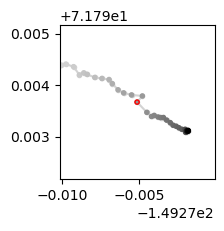

2845 2021-03-26 19:00:28 0.00461 centimeter / second ** 2


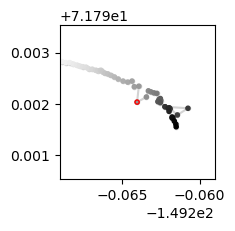

2850 2021-03-26 19:50:29 0.00519 centimeter / second ** 2


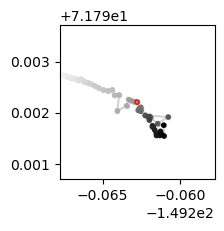

2863 2021-03-26 22:00:29 0.01689 centimeter / second ** 2


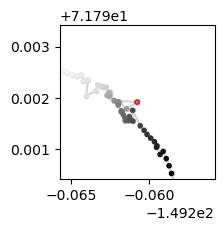

2875 2021-03-27 00:00:29 0.00436 centimeter / second ** 2


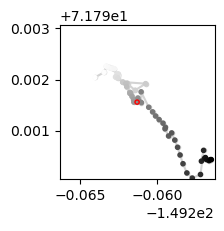

2879 2021-03-27 00:40:30 0.00692 centimeter / second ** 2


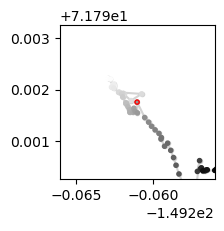

2887 2021-03-27 02:00:28 0.00621 centimeter / second ** 2


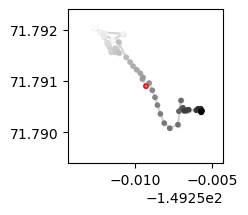

2896 2021-03-27 03:30:28 0.00815 centimeter / second ** 2


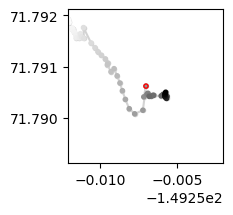

2905 2021-03-27 05:00:27 0.00635 centimeter / second ** 2


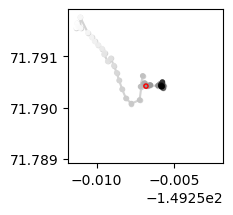

2958 2021-03-27 16:00:26 0.00500 centimeter / second ** 2


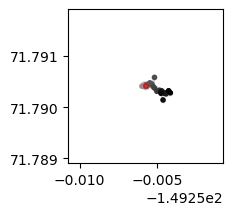

2973 2021-03-27 18:50:26 0.00445 centimeter / second ** 2


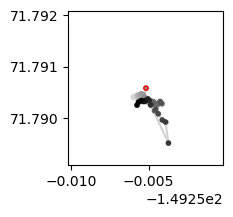

2987 2021-03-27 21:10:30 0.00559 centimeter / second ** 2


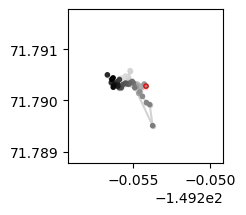

2992 2021-03-27 22:00:29 0.02254 centimeter / second ** 2


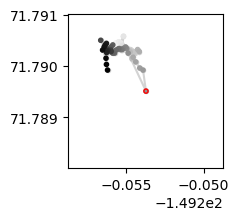

3003 2021-03-27 23:50:30 0.00633 centimeter / second ** 2


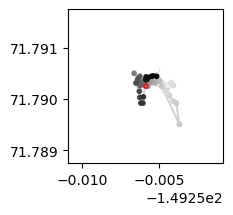

3008 2021-03-28 00:40:29 0.00796 centimeter / second ** 2


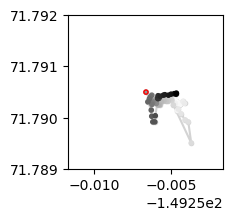

3014 2021-03-28 01:50:30 0.00662 centimeter / second ** 2


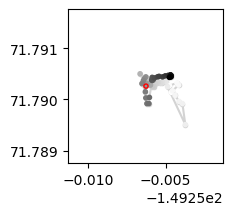

3022 2021-03-28 03:10:28 0.00668 centimeter / second ** 2


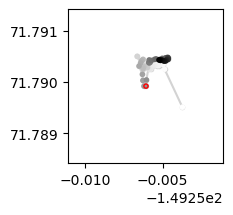

3122 2021-03-28 20:20:27 0.00564 centimeter / second ** 2


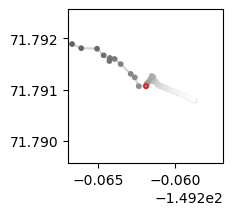

3128 2021-03-28 21:20:30 0.00628 centimeter / second ** 2


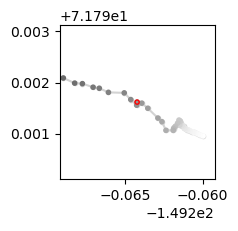

3427 2021-03-31 03:00:29 0.02297 centimeter / second ** 2


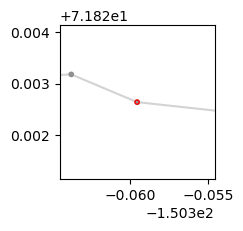

3557 2021-04-01 03:10:29 0.00557 centimeter / second ** 2


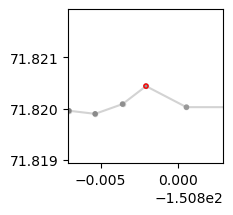

3632 2021-04-01 18:20:30 0.01317 centimeter / second ** 2


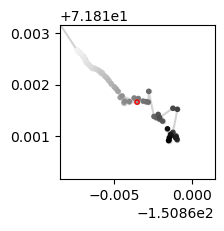

3641 2021-04-01 19:50:30 0.01489 centimeter / second ** 2


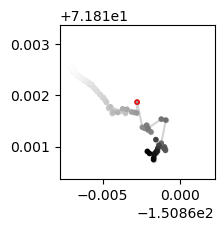

3647 2021-04-01 20:50:31 0.00839 centimeter / second ** 2


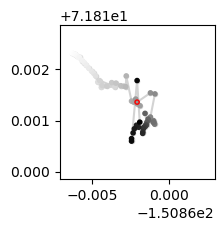

3649 2021-04-01 21:10:28 0.01256 centimeter / second ** 2


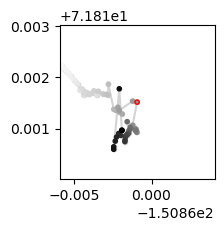

3675 2021-04-02 03:00:33 0.02508 centimeter / second ** 2


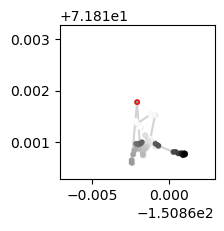

3747 2021-04-02 20:00:34 0.00640 centimeter / second ** 2


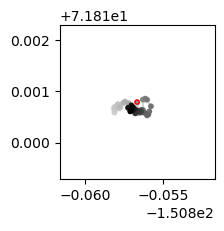

3749 2021-04-02 20:20:28 0.00478 centimeter / second ** 2


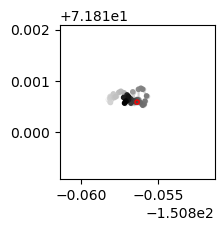

3773 2021-04-03 00:20:29 0.00516 centimeter / second ** 2


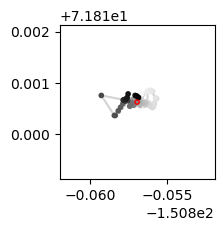

3781 2021-04-03 01:40:29 0.00435 centimeter / second ** 2


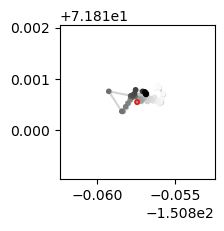

3789 2021-04-03 03:00:33 0.01743 centimeter / second ** 2


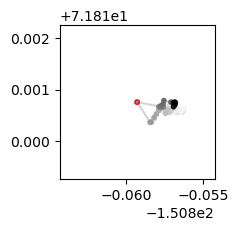

3863 2021-04-03 20:10:30 0.00371 centimeter / second ** 2


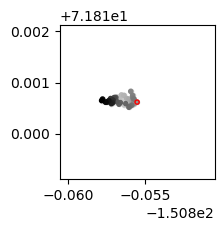

3897 2021-04-04 02:50:34 0.03143 centimeter / second ** 2


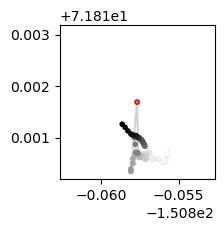

3903 2021-04-04 05:10:28 0.00598 centimeter / second ** 2


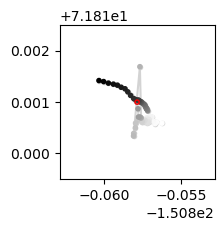

3964 2021-04-04 18:10:29 0.01000 centimeter / second ** 2


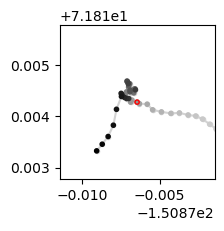

3974 2021-04-04 19:50:25 0.00505 centimeter / second ** 2


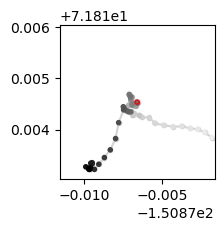

3977 2021-04-04 20:20:27 0.00507 centimeter / second ** 2


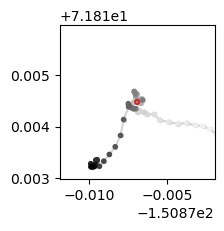

3982 2021-04-04 21:10:31 0.00599 centimeter / second ** 2


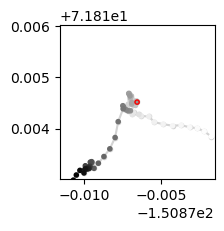

3987 2021-04-04 22:00:30 0.00677 centimeter / second ** 2


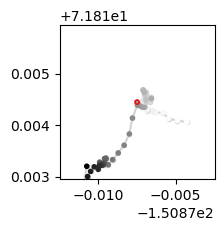

3994 2021-04-04 23:11:00 0.00533 centimeter / second ** 2


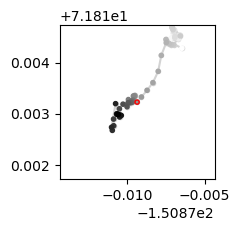

3998 2021-04-04 23:50:30 0.00535 centimeter / second ** 2


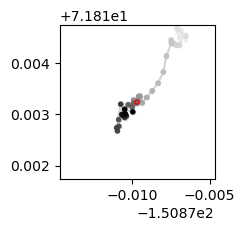

4008 2021-04-05 01:30:29 0.00434 centimeter / second ** 2


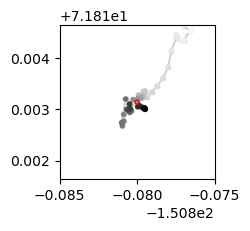

4014 2021-04-05 02:30:30 0.01280 centimeter / second ** 2


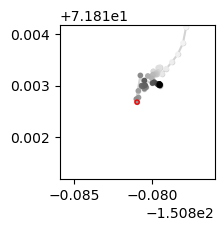

4025 2021-04-05 04:40:25 0.00678 centimeter / second ** 2


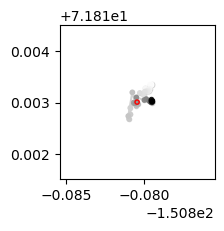

4084 2021-04-05 18:20:26 0.01058 centimeter / second ** 2


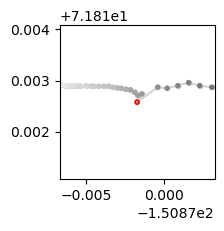

4100 2021-04-05 21:00:26 0.00643 centimeter / second ** 2


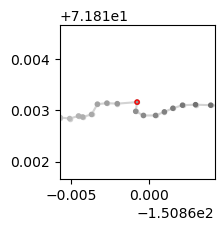

4134 2021-04-06 02:40:28 0.01675 centimeter / second ** 2


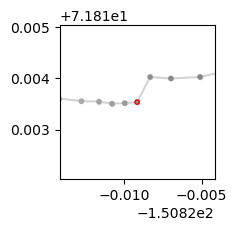

4209 2021-04-06 18:20:30 0.01062 centimeter / second ** 2


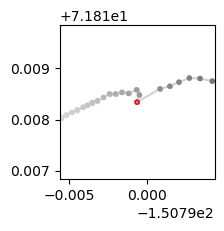

4222 2021-04-06 20:30:28 0.00658 centimeter / second ** 2


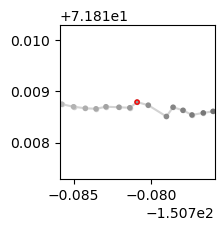

4224 2021-04-06 20:50:29 0.00773 centimeter / second ** 2


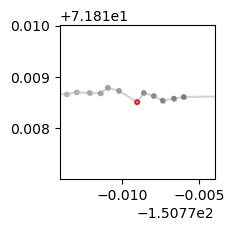

4251 2021-04-07 02:40:32 0.01028 centimeter / second ** 2


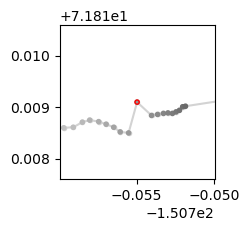

4332 2021-04-07 20:10:27 0.00473 centimeter / second ** 2


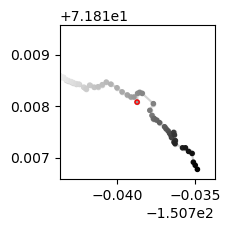

4349 2021-04-07 23:01:02 0.00517 centimeter / second ** 2


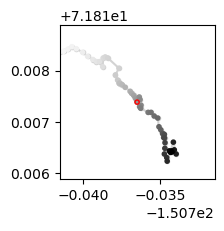

4353 2021-04-07 23:40:30 0.00427 centimeter / second ** 2


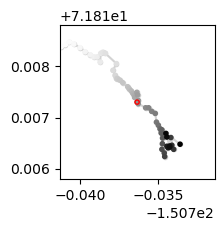

4362 2021-04-08 01:10:31 0.00437 centimeter / second ** 2


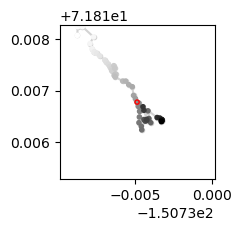

4370 2021-04-08 02:30:27 0.01369 centimeter / second ** 2


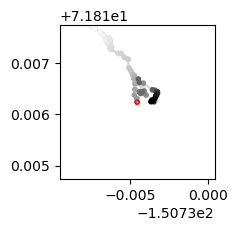

4378 2021-04-08 04:20:26 0.00528 centimeter / second ** 2


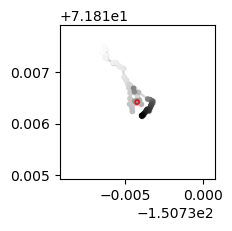

4381 2021-04-08 04:50:28 0.00858 centimeter / second ** 2


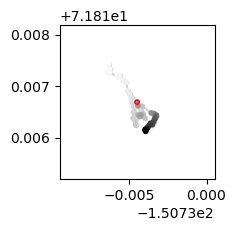

4443 2021-04-08 18:10:30 0.01058 centimeter / second ** 2


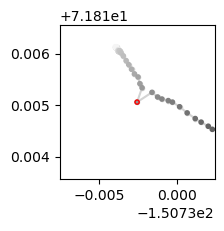

4457 2021-04-08 20:30:28 0.00434 centimeter / second ** 2


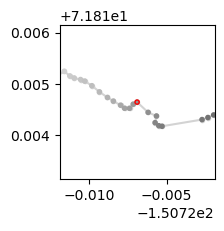

4487 2021-04-09 02:30:34 0.02460 centimeter / second ** 2


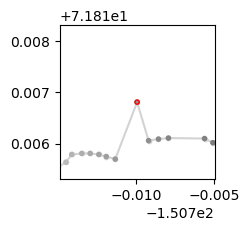

4680 2021-04-10 20:50:29 0.01027 centimeter / second ** 2


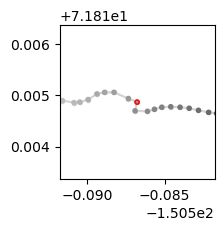

4713 2021-04-11 02:20:29 0.02542 centimeter / second ** 2


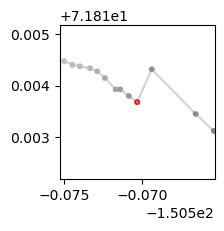

4720 2021-04-11 04:30:27 0.01125 centimeter / second ** 2


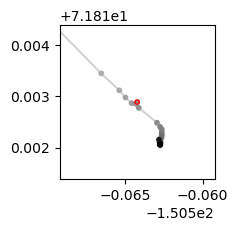

4743 2021-04-11 08:50:26 0.00448 centimeter / second ** 2


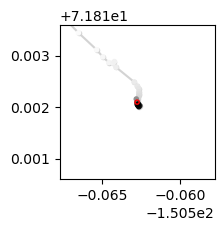

4783 2021-04-11 19:20:29 0.01462 centimeter / second ** 2


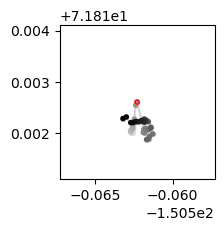

4794 2021-04-11 22:30:29 0.00480 centimeter / second ** 2


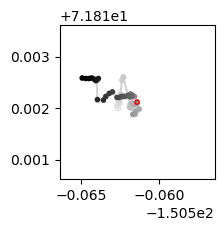

4815 2021-04-12 02:10:28 0.01097 centimeter / second ** 2


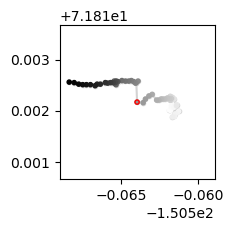

5019 2021-04-13 19:10:28 0.01581 centimeter / second ** 2


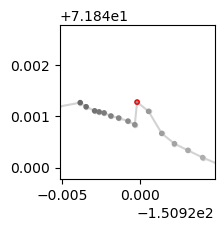

5036 2021-04-13 22:50:32 0.00534 centimeter / second ** 2


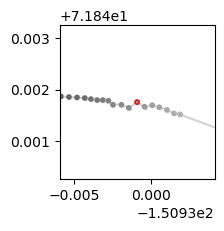

5056 2021-04-14 02:10:34 0.00597 centimeter / second ** 2


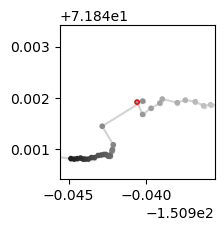

5114 2021-04-14 18:50:29 0.00984 centimeter / second ** 2


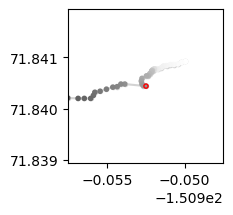

5150 2021-04-15 02:00:28 0.01235 centimeter / second ** 2


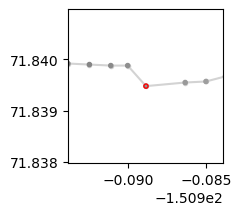

5225 2021-04-15 17:50:31 0.02731 centimeter / second ** 2


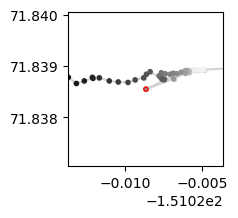

5246 2021-04-15 21:20:30 0.00588 centimeter / second ** 2


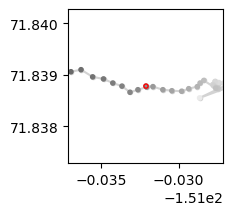

5352 2021-04-16 18:50:27 0.02562 centimeter / second ** 2


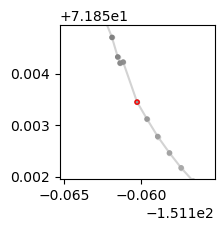

5354 2021-04-16 19:10:30 0.00836 centimeter / second ** 2


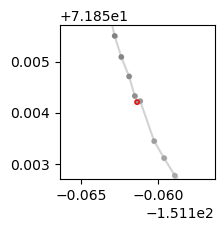

5397 2021-04-17 04:00:34 0.00570 centimeter / second ** 2


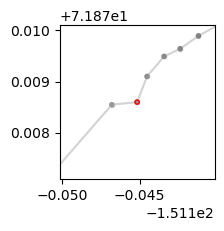

5464 2021-04-17 19:00:28 0.01051 centimeter / second ** 2


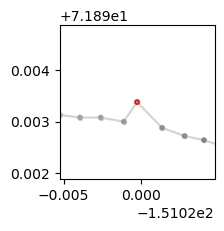

5516 2021-04-18 04:00:30 0.01981 centimeter / second ** 2


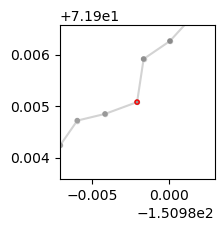

5590 2021-04-18 20:20:29 0.00646 centimeter / second ** 2


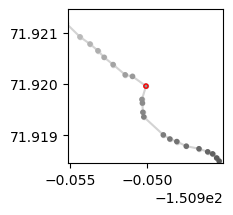

6040 2021-04-22 20:00:30 0.02316 centimeter / second ** 2


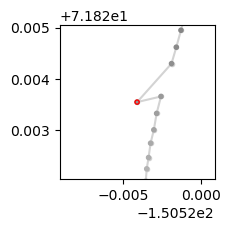

>>> removing 96 flagged values

v1  >>>  v2
1.54 % of the data is flagged
0.20 % of the data is flagged


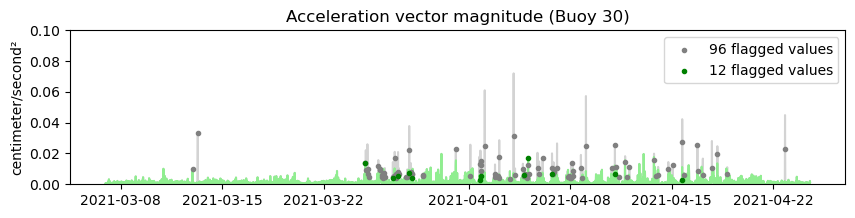

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

2569 2021-03-24 20:50:26 0.01390 centimeter / second ** 2


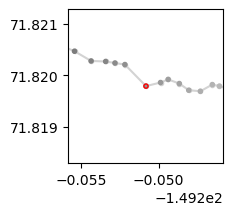

2830 2021-03-26 16:30:26 0.00435 centimeter / second ** 2


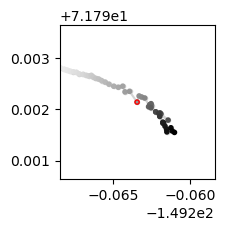

2873 2021-03-26 23:40:28 0.00513 centimeter / second ** 2


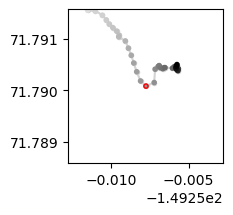

2960 2021-03-27 16:20:25 0.00727 centimeter / second ** 2


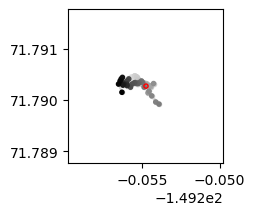

2991 2021-03-27 21:50:28 0.00422 centimeter / second ** 2


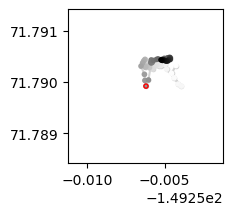

3597 2021-04-01 09:50:25 0.00299 centimeter / second ** 2


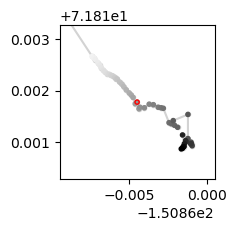

3609 2021-04-01 14:30:32 0.00510 centimeter / second ** 2


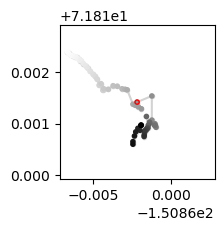

3927 2021-04-04 09:20:27 0.00626 centimeter / second ** 2


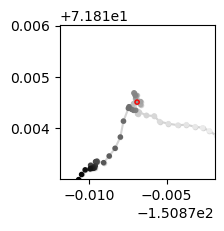

3958 2021-04-04 17:10:25 0.01708 centimeter / second ** 2


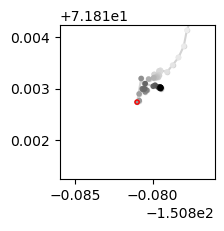

4146 2021-04-06 05:10:25 0.00685 centimeter / second ** 2


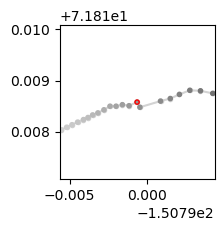

4636 2021-04-10 10:30:26 0.00677 centimeter / second ** 2


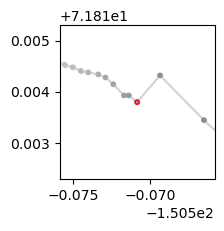

5137 2021-04-14 23:40:31 0.00285 centimeter / second ** 2


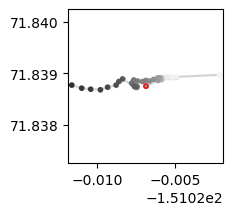

>>> removing 12 flagged values

v2  >>>  v3
1.54 % of the data is flagged
0.20 % of the data is flagged
0.03 % of the data is flagged


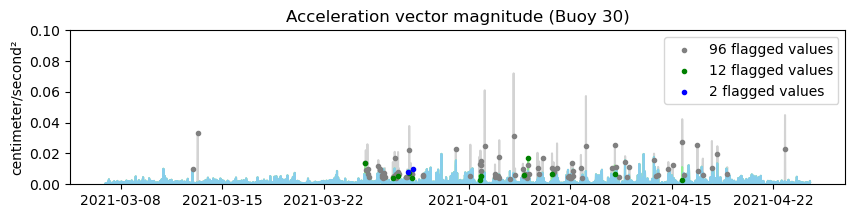

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

2955 2021-03-27 15:30:26 0.00778 centimeter / second ** 2


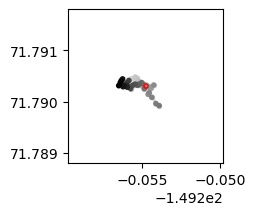

2987 2021-03-27 21:10:30 0.01005 centimeter / second ** 2


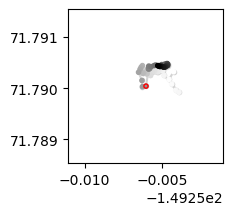

>>> removing 2 flagged values

v3  >>>  v4
1.54 % of the data is flagged
0.20 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


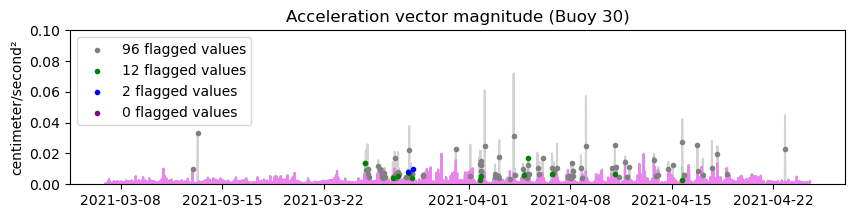

Approximate plot dimensions:
 - zonal: 345.04 m
 - merid: 334.76 m

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_31_300534061093070.csv
buoy 31


v0  >>>  v1
0.22 % of the data is flagged


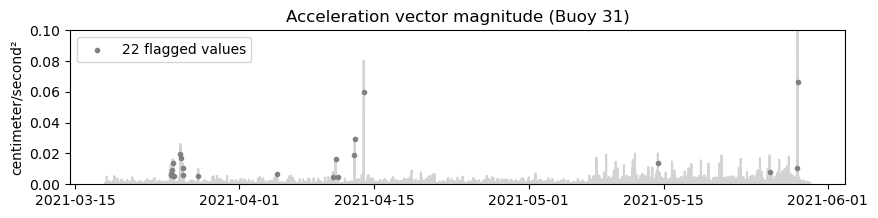

>>> removing 22 flagged values

v1  >>>  v2
0.22 % of the data is flagged
0.03 % of the data is flagged


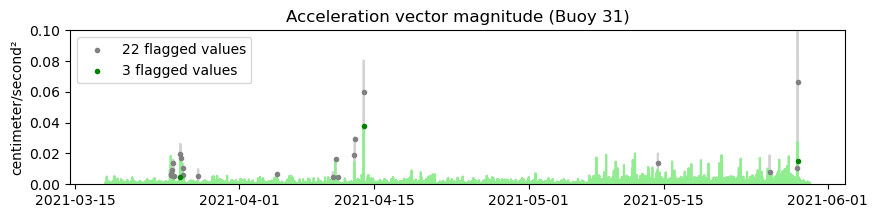

>>> removing 3 flagged values

v2  >>>  v3
0.22 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


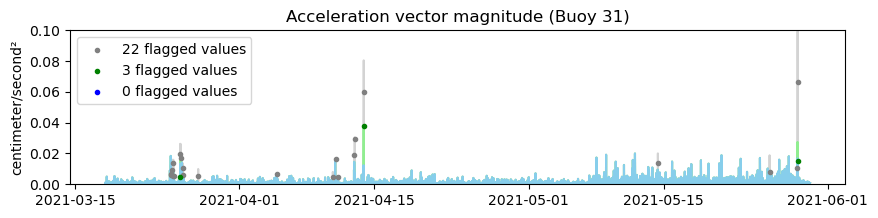

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_32_300534061094090.csv
buoy 32


v0  >>>  v1
0.11 % of the data is flagged


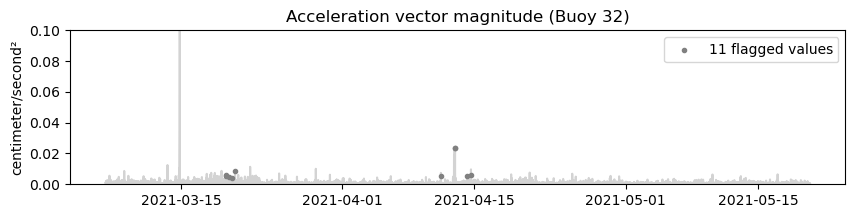

>>> removing 11 flagged values

v1  >>>  v2
0.11 % of the data is flagged
0.02 % of the data is flagged


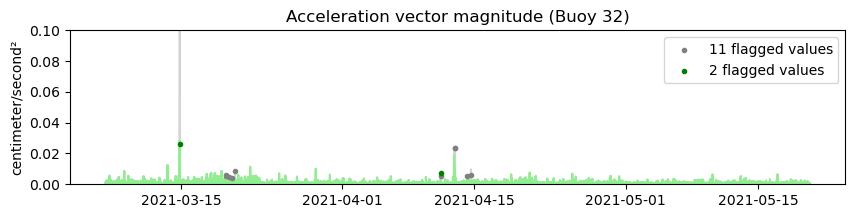

>>> removing 2 flagged values

v2  >>>  v3
0.11 % of the data is flagged
0.02 % of the data is flagged
0.00 % of the data is flagged


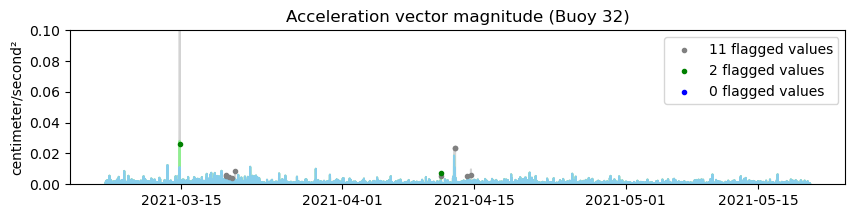

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_33_300534061095060.csv
buoy 33


v0  >>>  v1
0.13 % of the data is flagged


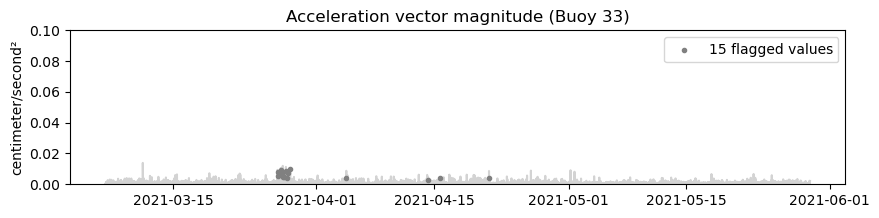

>>> removing 15 flagged values

v1  >>>  v2
0.13 % of the data is flagged
0.01 % of the data is flagged


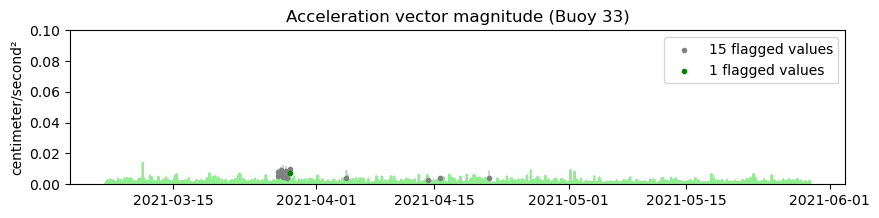

>>> removing 1 flagged values

v2  >>>  v3
0.13 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


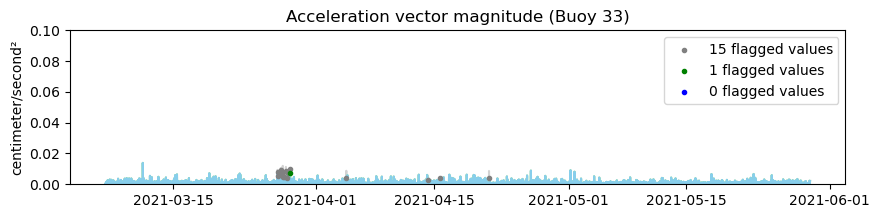

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_34_1_300534061095090.csv
buoy 34_1


v0  >>>  v1
0.10 % of the data is flagged


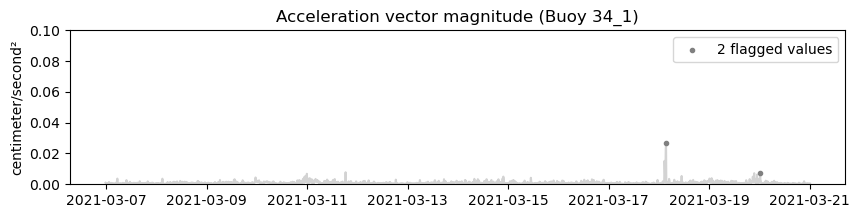

>>> removing 2 flagged values

v1  >>>  v2
0.10 % of the data is flagged
0.00 % of the data is flagged


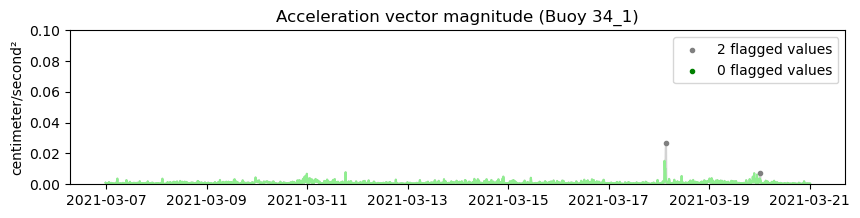

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_34_2_300534061095090.csv
buoy 34_2


v0  >>>  v1
0.04 % of the data is flagged


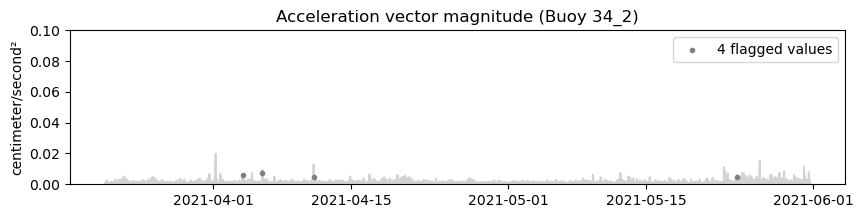

>>> removing 4 flagged values

v1  >>>  v2
0.04 % of the data is flagged
0.00 % of the data is flagged


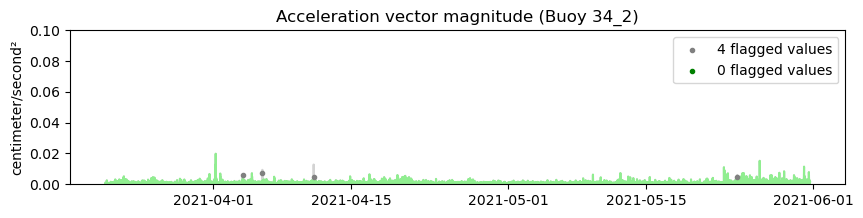

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_35_300534061096000.csv
buoy 35


v0  >>>  v1
1.13 % of the data is flagged


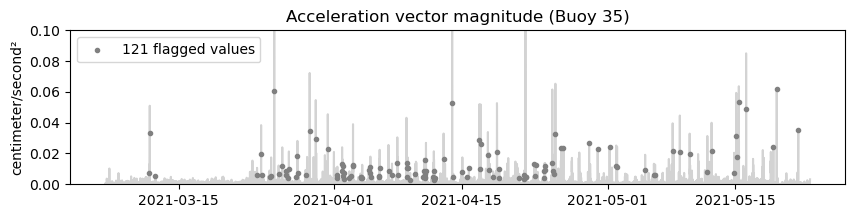

>>> removing 121 flagged values

v1  >>>  v2
1.13 % of the data is flagged
0.10 % of the data is flagged


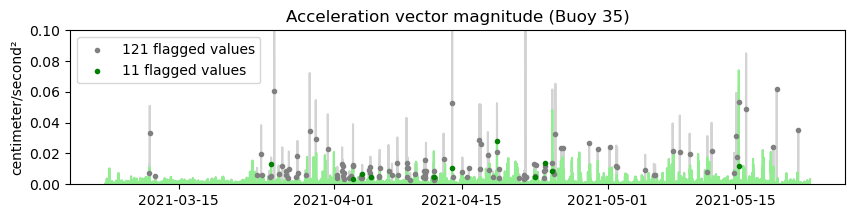

>>> removing 11 flagged values

v2  >>>  v3
1.13 % of the data is flagged
0.10 % of the data is flagged
0.02 % of the data is flagged


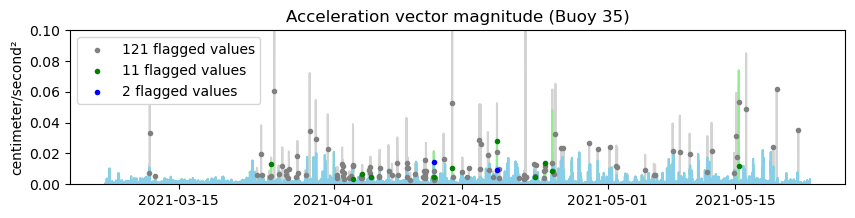

>>> removing 2 flagged values

v3  >>>  v4
1.13 % of the data is flagged
0.10 % of the data is flagged
0.02 % of the data is flagged
0.01 % of the data is flagged


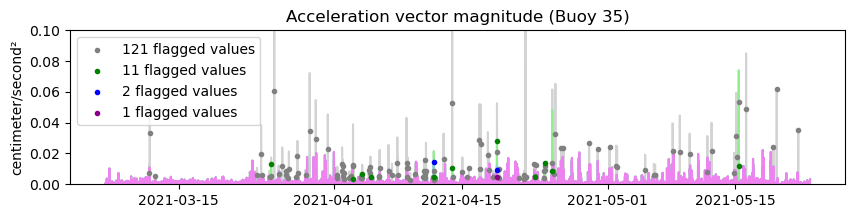

>>> removing 1 flagged values

v4  >>>  v5
1.13 % of the data is flagged
0.10 % of the data is flagged
0.02 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


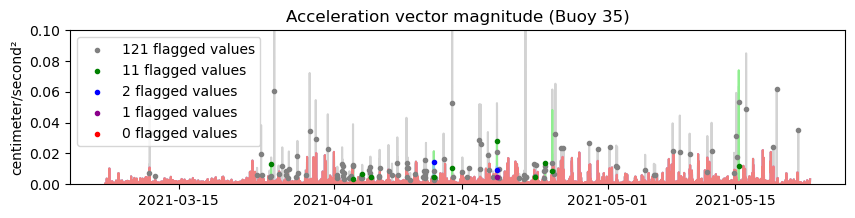

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_36_300534061096010.csv
buoy 36


v0  >>>  v1
0.36 % of the data is flagged


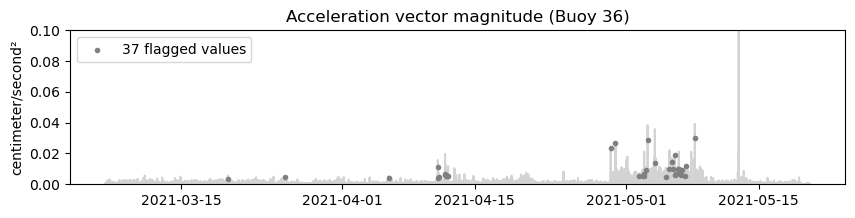

>>> removing 37 flagged values

v1  >>>  v2
0.36 % of the data is flagged
0.06 % of the data is flagged


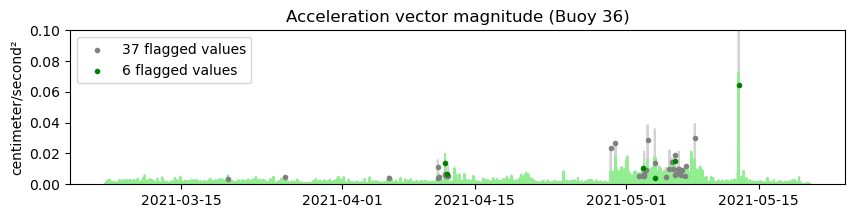

>>> removing 6 flagged values

v2  >>>  v3
0.36 % of the data is flagged
0.06 % of the data is flagged
0.00 % of the data is flagged


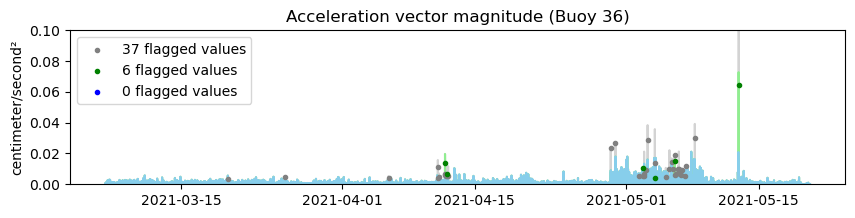

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_37_300534061096020.csv
buoy 37


v0  >>>  v1
0.12 % of the data is flagged


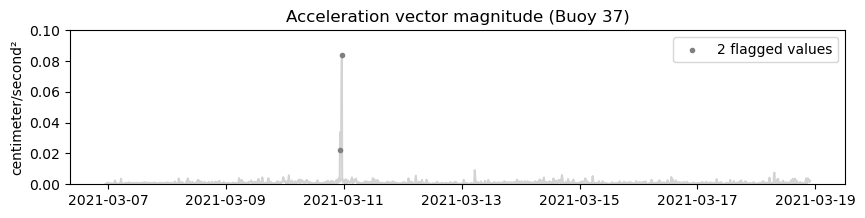

>>> removing 2 flagged values

v1  >>>  v2
0.12 % of the data is flagged
0.06 % of the data is flagged


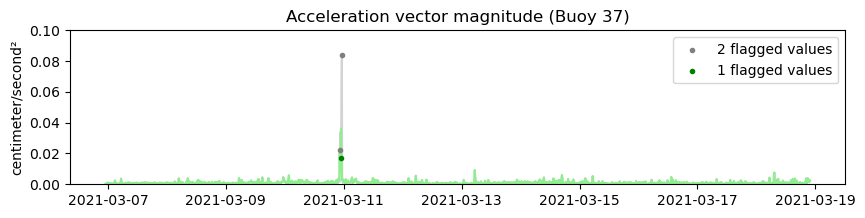

>>> removing 1 flagged values

v2  >>>  v3
0.12 % of the data is flagged
0.06 % of the data is flagged
0.06 % of the data is flagged


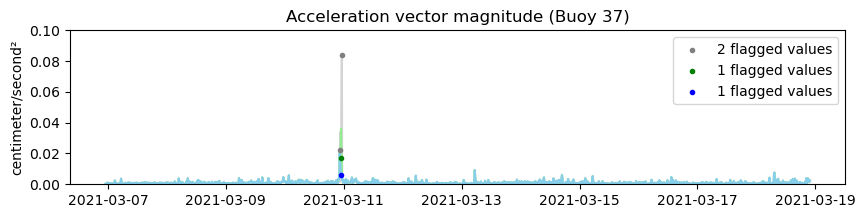

>>> removing 1 flagged values

v3  >>>  v4
0.12 % of the data is flagged
0.06 % of the data is flagged
0.06 % of the data is flagged
0.00 % of the data is flagged


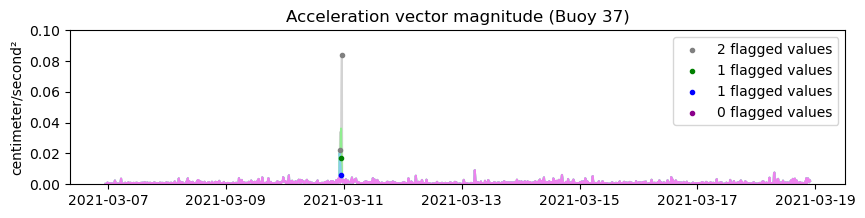

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_38_300534061096060.csv
buoy 38


v0  >>>  v1
0.23 % of the data is flagged


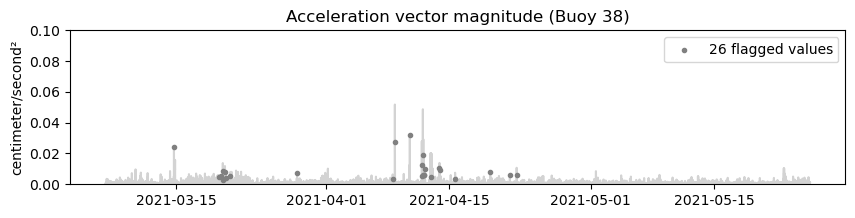

>>> removing 26 flagged values

v1  >>>  v2
0.23 % of the data is flagged
0.04 % of the data is flagged


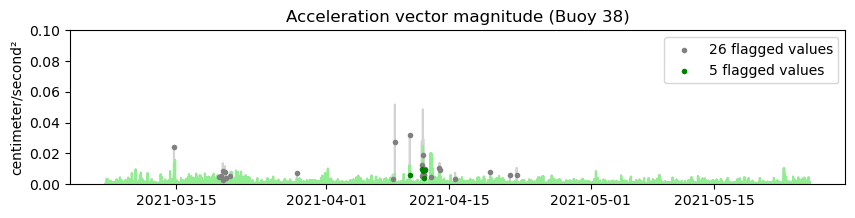

>>> removing 5 flagged values

v2  >>>  v3
0.23 % of the data is flagged
0.04 % of the data is flagged
0.00 % of the data is flagged


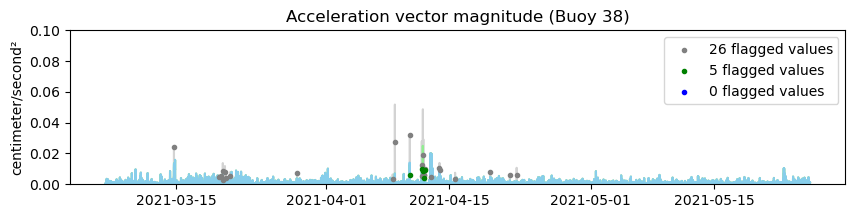

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_39_300534061097010.csv
buoy 39


v0  >>>  v1
0.46 % of the data is flagged


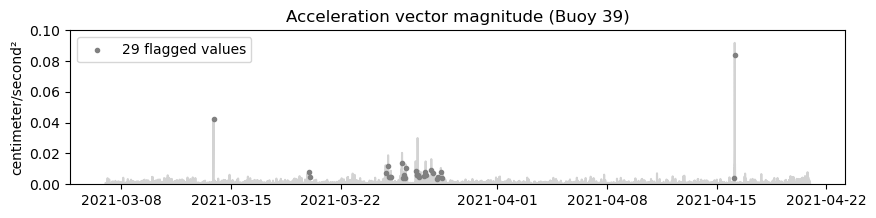

>>> removing 29 flagged values

v1  >>>  v2
0.46 % of the data is flagged
0.10 % of the data is flagged


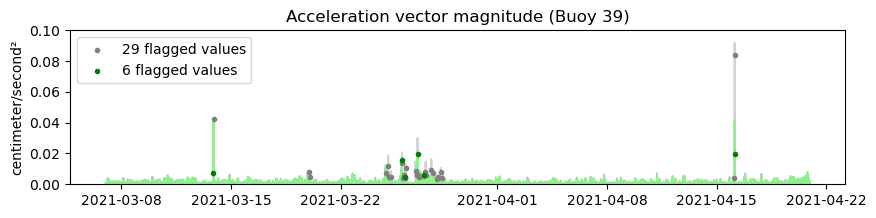

>>> removing 6 flagged values

v2  >>>  v3
0.46 % of the data is flagged
0.10 % of the data is flagged
0.05 % of the data is flagged


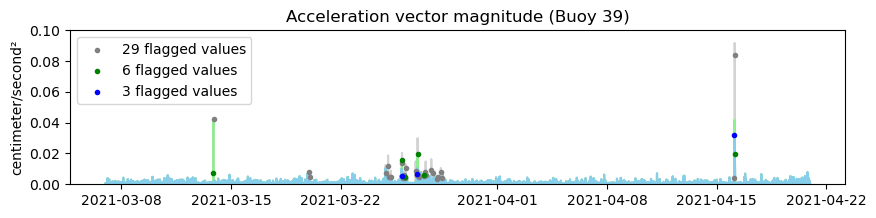

>>> removing 3 flagged values

v3  >>>  v4
0.46 % of the data is flagged
0.10 % of the data is flagged
0.05 % of the data is flagged
0.03 % of the data is flagged


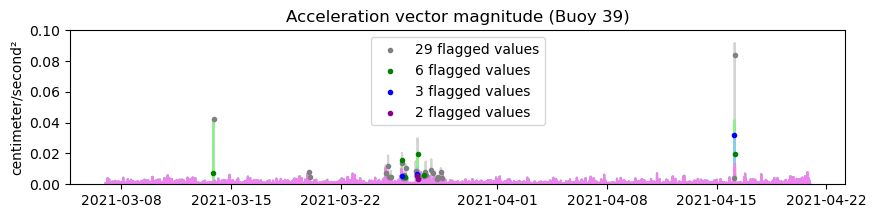

>>> removing 2 flagged values

v4  >>>  v5
0.46 % of the data is flagged
0.10 % of the data is flagged
0.05 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


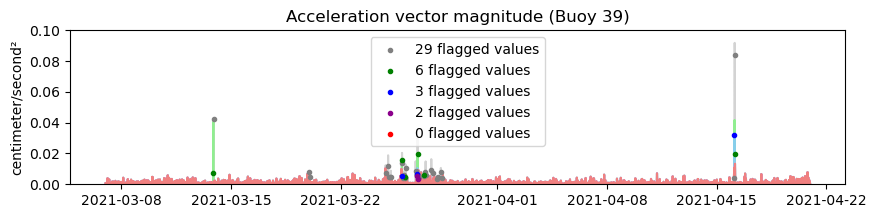

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_40_300534061097050.csv
buoy 40


v0  >>>  v1
0.27 % of the data is flagged


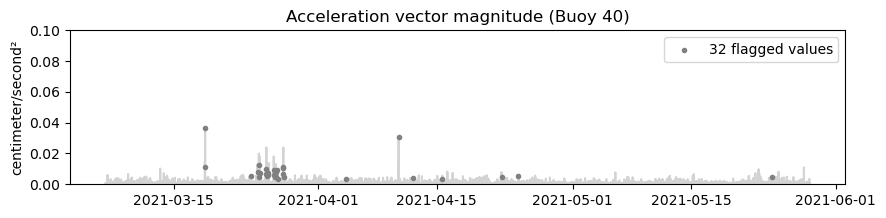

>>> removing 32 flagged values

v1  >>>  v2
0.27 % of the data is flagged
0.07 % of the data is flagged


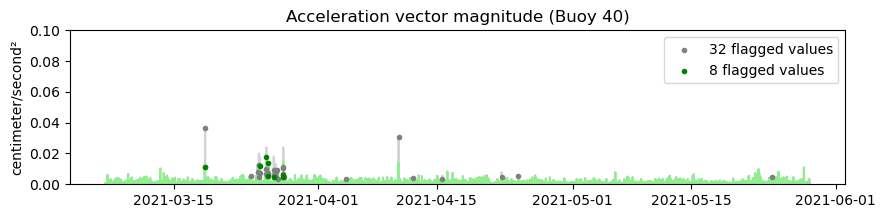

>>> removing 8 flagged values

v2  >>>  v3
0.27 % of the data is flagged
0.07 % of the data is flagged
0.03 % of the data is flagged


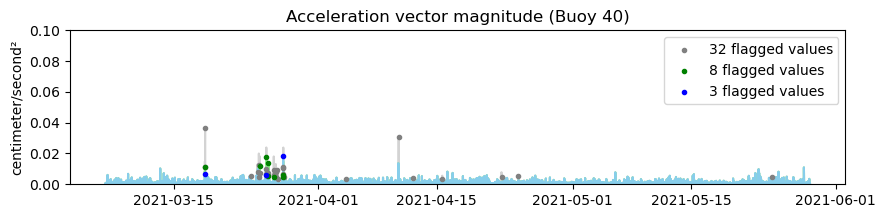

>>> removing 3 flagged values

v3  >>>  v4
0.27 % of the data is flagged
0.07 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


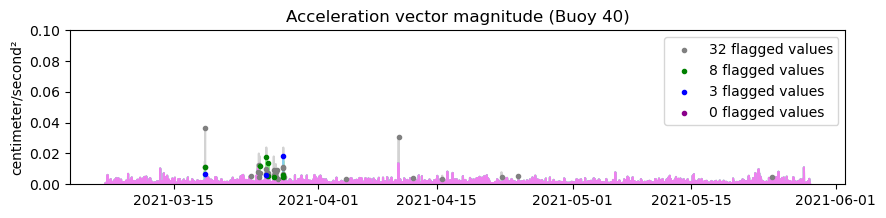

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_41_300534061098010.csv
buoy 41


v0  >>>  v1
0.24 % of the data is flagged


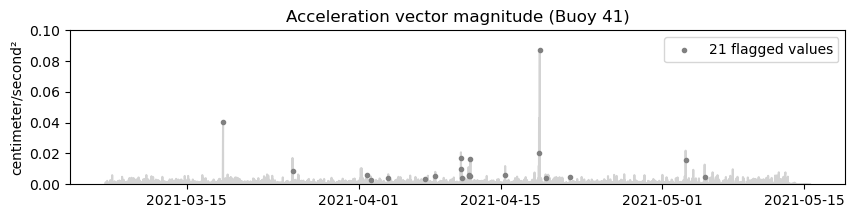

>>> removing 21 flagged values

v1  >>>  v2
0.24 % of the data is flagged
0.03 % of the data is flagged


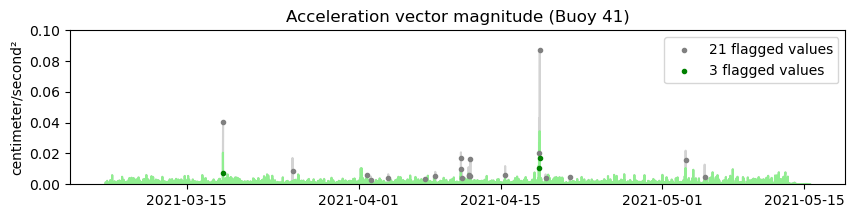

>>> removing 3 flagged values

v2  >>>  v3
0.24 % of the data is flagged
0.03 % of the data is flagged
0.02 % of the data is flagged


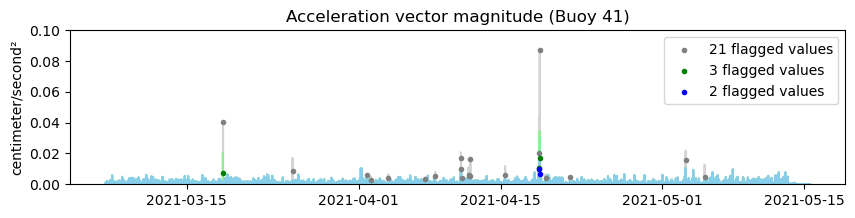

>>> removing 2 flagged values

v3  >>>  v4
0.24 % of the data is flagged
0.03 % of the data is flagged
0.02 % of the data is flagged
0.00 % of the data is flagged


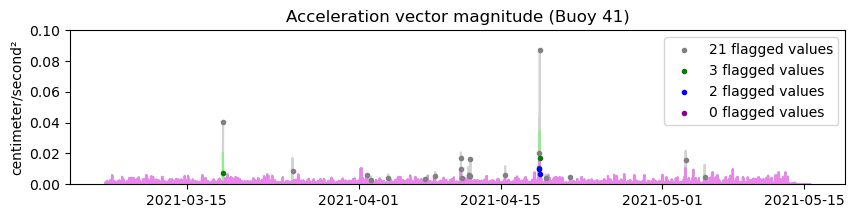

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_42_300534061098040.csv
buoy 42


v0  >>>  v1
0.33 % of the data is flagged


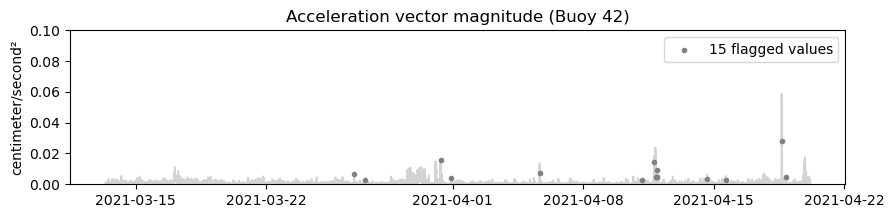

>>> removing 15 flagged values

v1  >>>  v2
0.33 % of the data is flagged
0.07 % of the data is flagged


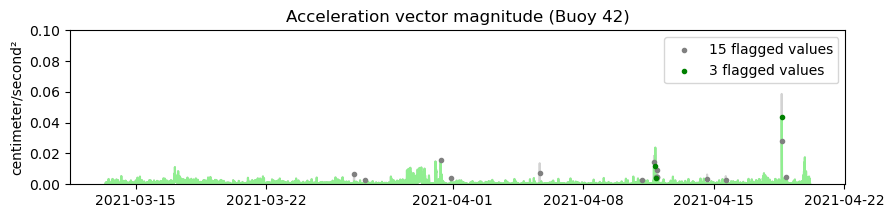

>>> removing 3 flagged values

v2  >>>  v3
0.33 % of the data is flagged
0.07 % of the data is flagged
0.00 % of the data is flagged


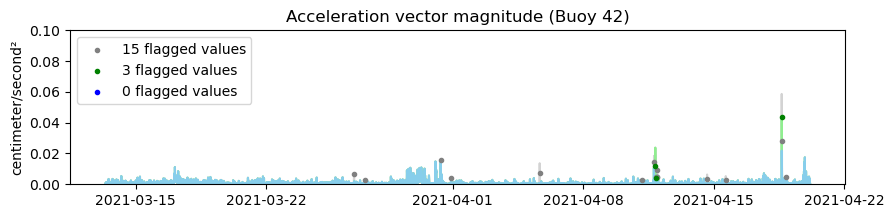

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_43_300534061098050.csv
buoy 43


v0  >>>  v1
0.16 % of the data is flagged


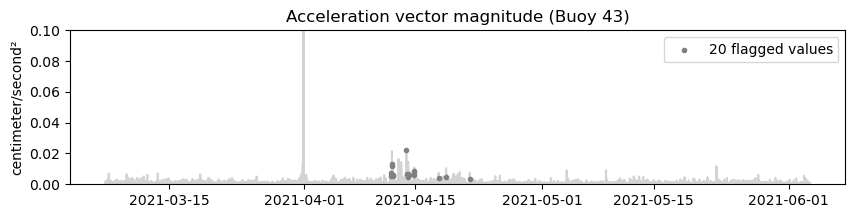

>>> removing 20 flagged values

v1  >>>  v2
0.16 % of the data is flagged
0.03 % of the data is flagged


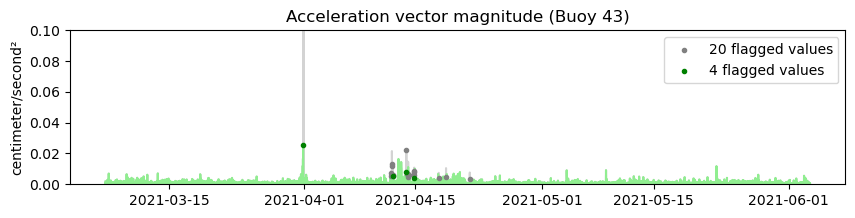

>>> removing 4 flagged values

v2  >>>  v3
0.16 % of the data is flagged
0.03 % of the data is flagged
0.00 % of the data is flagged


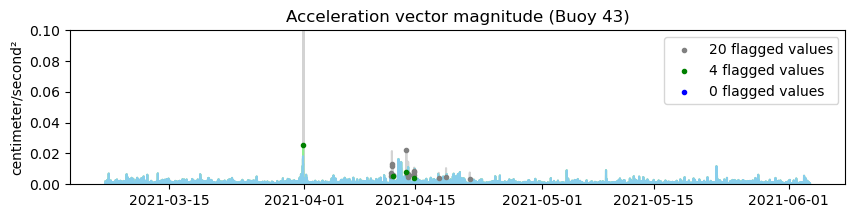

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_44_300534061099010.csv
buoy 44


v0  >>>  v1
0.10 % of the data is flagged


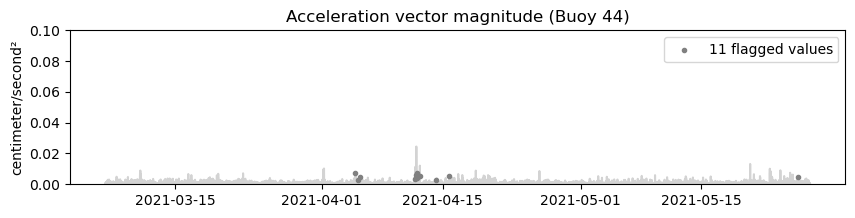

>>> removing 11 flagged values

v1  >>>  v2
0.10 % of the data is flagged
0.01 % of the data is flagged


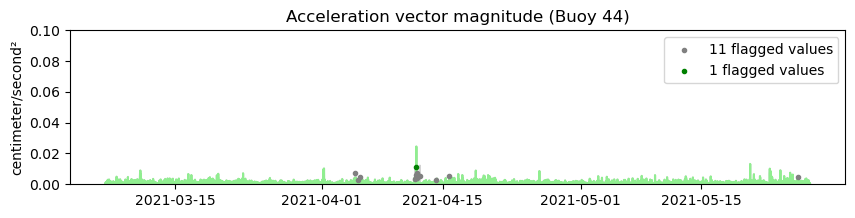

>>> removing 1 flagged values

v2  >>>  v3
0.10 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


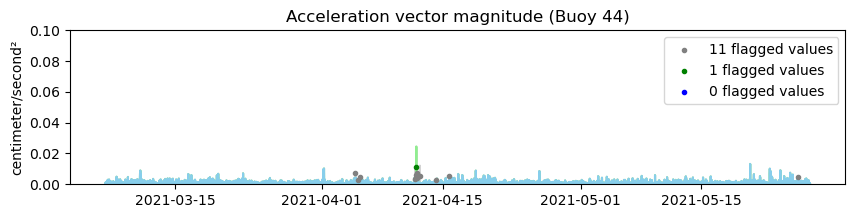

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_45_300534061980500.csv
buoy 45


v0  >>>  v1
0.18 % of the data is flagged


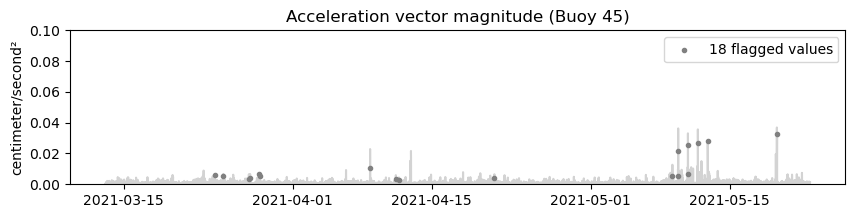

>>> removing 18 flagged values

v1  >>>  v2
0.18 % of the data is flagged
0.01 % of the data is flagged


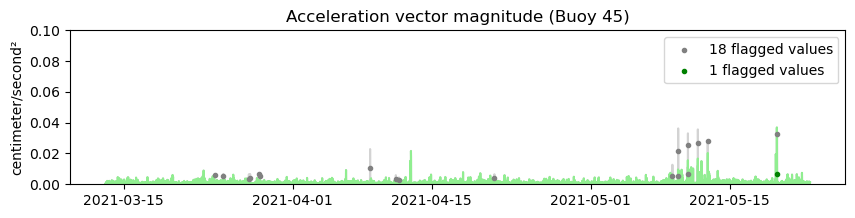

>>> removing 1 flagged values

v2  >>>  v3
0.18 % of the data is flagged
0.01 % of the data is flagged
0.00 % of the data is flagged


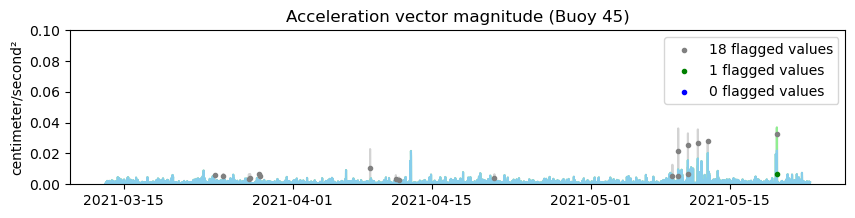

>>> removing 0 flagged values
/Users/mackenziejewell/Desktop/sidex_tracks/data/OSU_IT_46_300534061982520.csv
buoy 46


v0  >>>  v1
0.09 % of the data is flagged


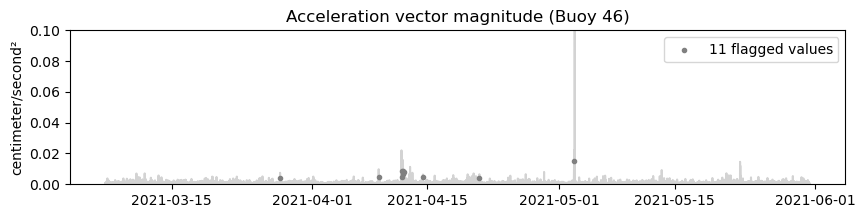

>>> removing 11 flagged values

v1  >>>  v2
0.09 % of the data is flagged
0.03 % of the data is flagged


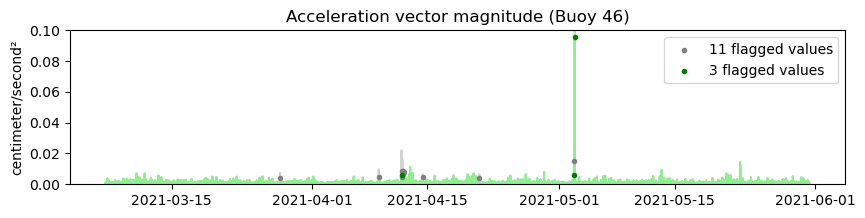

>>> removing 3 flagged values

v2  >>>  v3
0.09 % of the data is flagged
0.03 % of the data is flagged
0.02 % of the data is flagged


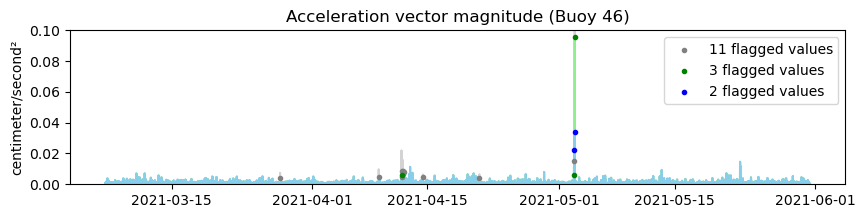

>>> removing 2 flagged values

v3  >>>  v4
0.09 % of the data is flagged
0.03 % of the data is flagged
0.02 % of the data is flagged
0.02 % of the data is flagged


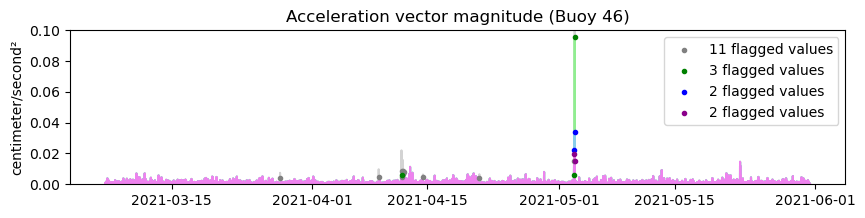

>>> removing 2 flagged values

v4  >>>  v5
0.09 % of the data is flagged
0.03 % of the data is flagged
0.02 % of the data is flagged
0.02 % of the data is flagged
0.01 % of the data is flagged


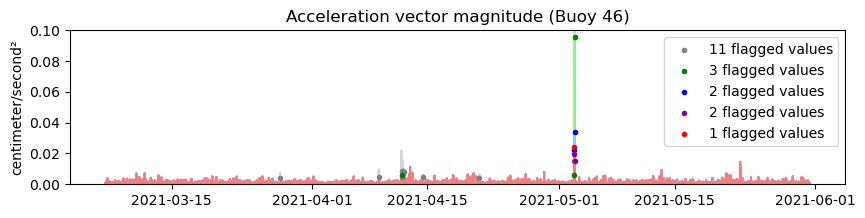

>>> removing 1 flagged values

v5  >>>  v6
0.09 % of the data is flagged
0.03 % of the data is flagged
0.02 % of the data is flagged
0.02 % of the data is flagged
0.01 % of the data is flagged


IndexError: list index out of range

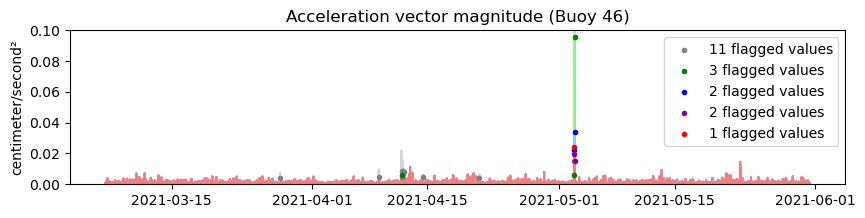

In [15]:
clean = {}

for file in csv_files:
    
    print(file)

    # grab buoy num
    buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
    print(f'buoy {buoy_num}\n')
    
    df = pd.read_csv(file)
    raw_dates = pd.to_datetime(df.datetime.values)
    raw_lat = df.latitude.values
    raw_lon = df.longitude.values

    clean[buoy_num] = {}
    clean[buoy_num]['lat'] = {}
    clean[buoy_num]['lon'] = {}
    clean[buoy_num]['time'] = {}
    clean[buoy_num]['acc'] = {}
    clean[buoy_num]['flag'] = {}

    clean[buoy_num]['lat']['v0'] = raw_lat
    clean[buoy_num]['lon']['v0'] = raw_lon
    clean[buoy_num]['time']['v0'] = raw_dates

    if buoy_num in ['23', '25', '30']:
        show_tracks = True
    else:
        show_tracks = False

    iterations = 0
    num_flags = 100

    while (iterations < 6) and (num_flags > 0):

        # specify current and next versions
        #==================================
        vi = f'v{iterations}'
        vn = f'v{iterations+1}'
        #==================================
        print(f'\n{vi}  >>>  {vn}')

        # run cleaning
        clean[buoy_num] = iterate_cleaning(vi = vi, vn = vn, buoy_num = buoy_num, data_di = clean[buoy_num], 
                                           show_velocity = False, show_acceleration = True, show_tracks = show_tracks)

        # find flags from vi used to create vf
        latest_flags = clean[buoy_num]['flag'][vi]
        num_flags = len(latest_flags)

        iterations+=1

In [114]:
FLAG

array([ 4699, 13274, 13363, 13432])

In [969]:
FLAG

array([ 4957,  6465, 13363, 13431])

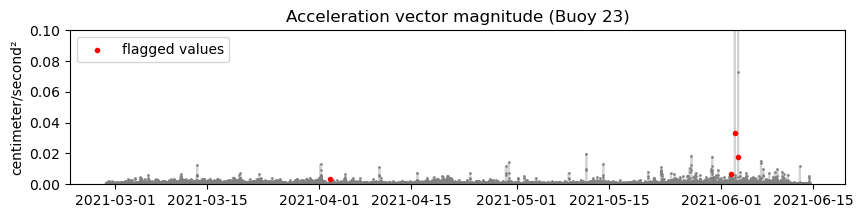

In [28]:
# PLOT
fig, ax = plt.subplots(figsize=(10,2))
plt.title('Acceleration vector magnitude (Buoy 23)')
plt.ylim(0,0.1)
plt.plot(time, ACC, zorder=0, c='lightgray')
plt.scatter(time, ACC, marker='.', s=3, zorder=0, c='gray')
# plt.scatter(time[flag1], ACC[flag1], marker='.', c='r', zorder=1, label='flagged values')
# plt.scatter(time[flag2], ACC[flag2], marker='.', c='b', zorder=1, label='flagged values')
plt.scatter(time[FLAG], ACC[FLAG], marker='.', c='r', zorder=1, label='flagged values')
# plt.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, colors='k', label=f'flag: {flag_thresh:.5f}')
plt.legend();
# print(f'{100*len(flag1)/len(time):.2f} % of the acceleration data is flagged')
# print(f'{100*len(flag2)/len(time):.2f} % of the position data is flagged')


Approximate plot dimensions:
 - zonal: 3450.42 m
 - merid: 3347.59 m

4699 2021-04-02 14:10:25


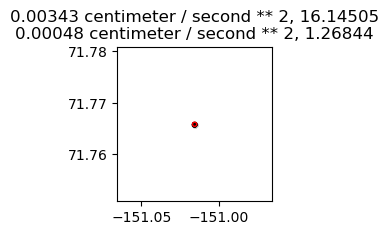

13274 2021-06-02 06:40:28


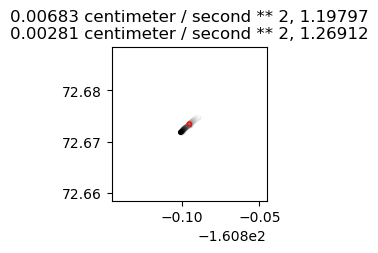

13363 2021-06-02 21:30:27


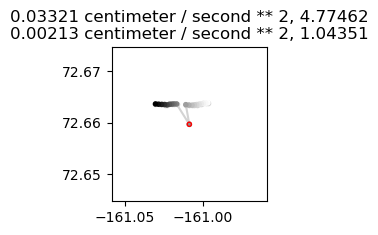

13432 2021-06-03 09:00:26


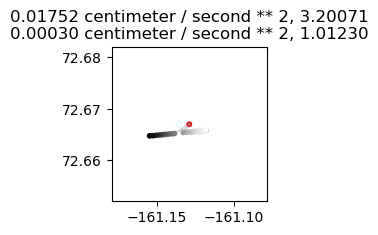

In [29]:

lons = cleaned['lon']['v1']
lats = cleaned['lat']['v1']

lat_range = 0.03
lon_range = 0.1
buffer = 10

dist_lon = g.inv(-155,72, -155+lon_range,72)[2]
dist_lat = g.inv(-155,72, -155,72+lat_range)[2]
print(f'Approximate plot dimensions:\n - zonal: {dist_lon:.2f} m\n - merid: {dist_lat:.2f} m\n')



for ind in FLAG:

#     if ACC[ind] > 10 * units('cm/s')/units('hr').to('s'):
        
    
    local_lons = lons[ind-buffer:ind+buffer]
    local_lats = lats[ind-buffer:ind+buffer]

    print(ind, raw_dates[ind])

    fig, ax = plt.subplots(figsize=(2,2))
    ax.set_title(f'{ACC[ind]:.5f}, {ratios[ind]:.5f}\n{ACC[ind+1]:.5f}, {ratios[ind+1]:.5f}')
    ax.plot(local_lons, local_lats, c='lightgray', marker='.', zorder=0)
    ax.scatter(local_lons, local_lats, c = np.linspace(0,1,len(local_lats)), cmap='Greys', marker='.', zorder=0)
    ax.scatter(lons[ind], lats[ind], facecolor='None', edgecolor='r', marker='.', alpha=1, zorder=0)
    
    plt.xlim(lons[ind]-lon_range/2, lons[ind]+lon_range/2)
    plt.ylim(lats[ind]-lat_range/2, lats[ind]+lat_range/2)
    plt.show()

In [30]:
remove_indices = FLAG

print(f'>>> removing {len(remove_indices)} flagged values')

cleaned['lon']['v2'] = np.copy(cleaned['lon']['v1'])
cleaned['lat']['v2'] = np.copy(cleaned['lat']['v1'])
cleaned['time']['v2'] = pd.to_datetime(np.copy(cleaned['time']['v1']))

cleaned['lat']['v2'][remove_indices] = np.nan
cleaned['lon']['v2'][remove_indices] = np.nan

no_nan_locs = np.isnan(cleaned['lat']['v2']) == False

cleaned['lat']['v2'] = cleaned['lat']['v2'][no_nan_locs]
cleaned['lon']['v2'] = cleaned['lon']['v2'][no_nan_locs]
cleaned['time']['v2'] = cleaned['time']['v2'][no_nan_locs]



>>> removing 4 flagged values


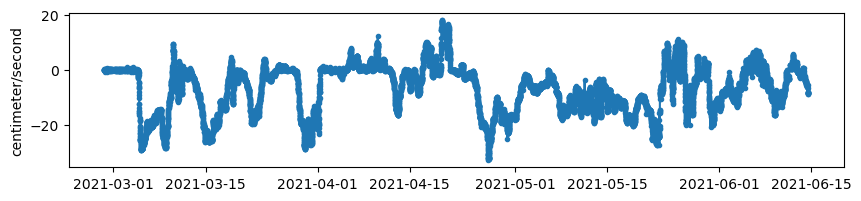

In [31]:
# # calculate forward looking velocities and acclerations between reported times
out = calculate_velocity(lons = cleaned['lon']['v2'], 
                         lats = cleaned['lat']['v2'], 
                         times = cleaned['time']['v2'], 
                         method = 'forward', skip_nans = True, acceleration = True)
u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out
cleaned['ACC']['v2'] = ACC

fig, ax = plt.subplots(figsize=(10,2))
plt.plot(time, u, marker='.')

In [33]:

FLAG, ratios = create_flags(lons = cleaned['lon']['v2'], 
                            lats = cleaned['lat']['v2'], 
                            acc = cleaned['ACC']['v2'])
FLAG

array([], dtype=int64)

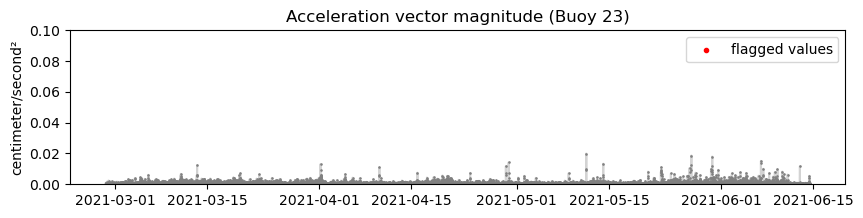

In [34]:
# PLOT
fig, ax = plt.subplots(figsize=(10,2))
plt.title('Acceleration vector magnitude (Buoy 23)')
plt.ylim(0,0.1)
plt.plot(time, ACC, zorder=0, c='lightgray')
plt.scatter(time, ACC, marker='.', s=3, zorder=0, c='gray')
# plt.scatter(time[flag1], ACC[flag1], marker='.', c='r', zorder=1, label='flagged values')
# plt.scatter(time[flag2], ACC[flag2], marker='.', c='b', zorder=1, label='flagged values')
plt.scatter(time[FLAG], ACC[FLAG], marker='.', c='r', zorder=1, label='flagged values')
# plt.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, colors='k', label=f'flag: {flag_thresh:.5f}')
plt.legend();
# print(f'{100*len(flag1)/len(time):.2f} % of the acceleration data is flagged')
# print(f'{100*len(flag2)/len(time):.2f} % of the position data is flagged')


In [ ]:
(sp[13432]-sp[13431])/dt[13431]

In [119]:
(sp[13432]-sp[13431])/dt[13431]

-0.009963596688088888 <Unit('centimeter / second ** 2')>

In [43]:
cleaned['lon']['v1'][13431:13434]

array([-161.08212, -161.08383, -161.08554])

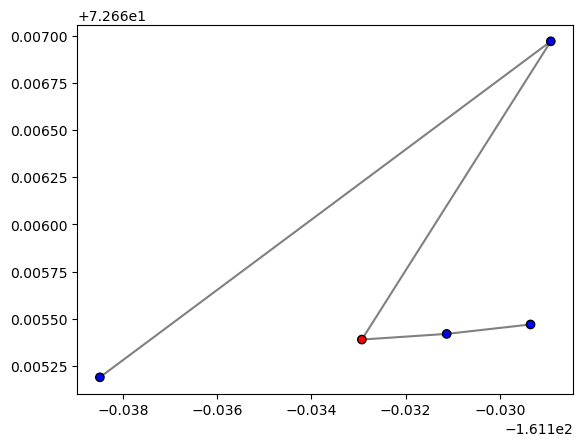

In [27]:
ind_i = 13429
ind_f = 13434

plt.plot(lons[ind_i:ind_f], 
            lats[ind_i:ind_f], c='gray', zorder=-1)
plt.scatter(lons[ind_i:ind_f], 
            lats[ind_i:ind_f], 
            c = u[ind_i:ind_f], vmin = -10, vmax = 10, cmap='bwr', edgecolor='k', marker='o')

In [95]:
dt[ind_i:ind_f]

array([ 599.,  601.,  603., 1224.,  573.]) <Unit('second')>

In [94]:
v[ind_i:ind_f]

array([ -0.93135437,  -0.55689126,  29.24091168, -16.22643966,
        -1.16835605]) <Unit('centimeter / second')>

In [93]:
u[ind_i:ind_f]

array([ -9.88639565,  -9.96422598,  22.1225022 , -26.01242897,
       -10.7415994 ]) <Unit('centimeter / second')>

In [96]:
sp[ind_i:ind_f]

array([ 9.93016817,  9.97977591, 36.66655178, 30.65850298, 10.8049532 ]) <Unit('centimeter / second')>

In [99]:
np.sqrt(u[ind_i:ind_f]**2 + v[ind_i:ind_f]**2)

array([ 9.93016817,  9.97977591, 36.66655178, 30.65850298, 10.8049532 ]) <Unit('centimeter / second')>

In [38]:
u[13430:13433]

array([ -9.96422598,  22.1225022 , -26.01242897]) <Unit('centimeter / second')>

In [36]:
du = u[13431:13434] - u[13430:13433]
du

array([ 32.08672818, -48.13493117,  15.27082957]) <Unit('centimeter / second')>

In [47]:
v[13430:13434]

array([ -0.55689126,  29.24091168, -16.22643966,  -1.16835605]) <Unit('centimeter / second')>

In [40]:
dv = v[13431:13434] - v[13430:13433]
dv

array([ 29.79780294, -45.46735134,  15.0580836 ]) <Unit('centimeter / second')>

In [32]:
ACC[13430:13433]

array([0.07286006, 0.1098071 , 0.01752149]) <Unit('centimeter / second ** 2')>

In [982]:
raw_dates[13430:13433]

DatetimeIndex(['2021-06-03 08:40:27', '2021-06-03 08:50:28',
               '2021-06-03 09:00:26'],
              dtype='datetime64[ns]', freq=None)

In [987]:
dt[13431]

603.0 <Unit('second')>

In [986]:
raw_dates[13432]-raw_dates[13431]

Timedelta('0 days 00:09:58')

In [953]:
(sp[13431]-sp[13430]) / (10*units('minutes').to('s'))

0.04447795978754326 <Unit('centimeter / second ** 2')>

[-146.46162 -146.46255 -146.4635  -146.46443 -146.46561 -146.46564
 -146.46764 -146.46855 -146.46956 -146.47049] [71.42039 71.42074 71.42109 71.42154 71.42172 71.42308 71.42278 71.42317
 71.42361 71.42403]


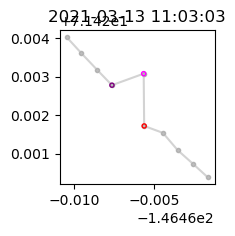

[-150.32896 -150.33321 -150.33752 -150.3418  -150.34615 -150.3528
 -150.355   -150.35941 -150.36395 -150.36839] [71.76924 71.76945 71.76966 71.76987 71.77007 71.76978 71.77049 71.77069
 71.7709  71.7711 ]


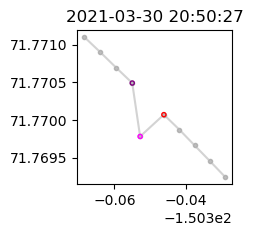

[-151.0157  -151.01569 -151.0157  -151.01567 -151.01494 -151.01566
 -151.01569 -151.01566] [71.76571 71.76569 71.76571 71.7657  71.76561 71.76579 71.76569 71.7657 ]


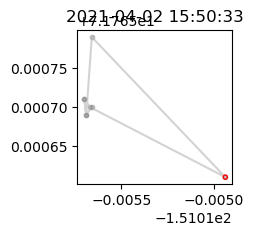

[-151.02606 -151.02626 -151.0265  -151.02667 -151.0269  -151.03142
 -151.02745 -151.02783 -151.02821 -151.02866] [71.76794 71.76803 71.76809 71.76815 71.76822 71.76797 71.7683  71.76838
 71.76847 71.76851]


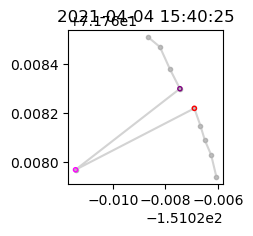

[-151.1176  -151.11801 -151.11848 -151.11909 -151.12047 -151.12006
 -151.12067 -151.12131] [71.79501 71.79499 71.79499 71.79498 71.79469 71.79499 71.79498 71.79498]


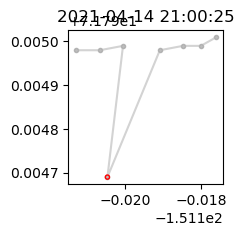

[-151.12711 -151.1263  -151.12552 -151.12486 -151.12354 -151.1235
 -151.12302 -151.12256] [71.86658 71.86684 71.8671  71.86736 71.86729 71.86778 71.86803 71.86825]


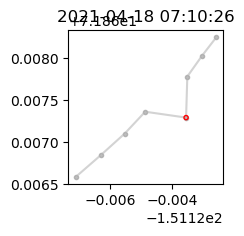

[-151.1062  -151.10643 -151.10664 -151.1069  -151.10789 -151.10738
 -151.10757 -151.10777] [71.87651 71.87664 71.87679 71.87692 71.87719 71.87719 71.87732 71.87744]


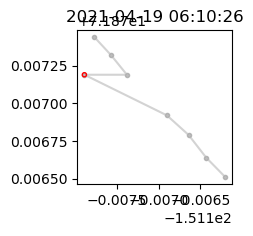

[-152.8813  -152.88466 -152.88817 -152.89148 -152.89442 -152.89876
 -152.90239 -152.90602] [72.2306  72.23087 72.23116 72.23143 72.23172 72.23203 72.23232 72.23262]


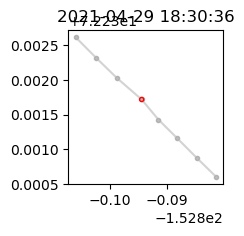

[-154.03577 -154.03723 -154.0387  -154.04018 -154.04164 -154.04298
 -154.04456 -154.04601 -154.04745 -154.04886] [72.34314 72.3433  72.34346 72.34365 72.34383 72.34462 72.34426 72.34441
 72.34462 72.34482]


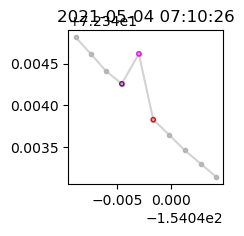

[-155.7076  -155.70927 -155.71095 -155.71266 -155.71536 -155.71606
 -155.71762 -155.7193 ] [72.43491 72.43501 72.43509 72.43518 72.43521 72.43538 72.43546 72.43555]


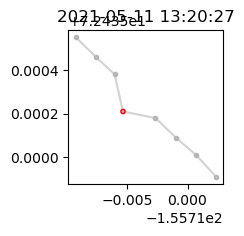

[-155.92845 -155.92998 -155.93146 -155.93286 -155.93419 -155.93567
 -155.937   -155.93831] [72.44273 72.44276 72.44278 72.44279 72.44307 72.44277 72.44283 72.44283]


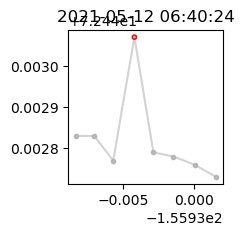

[-157.71547 -157.71846 -157.72145 -157.72444 -157.72742 -157.7309
 -157.73346 -157.7363  -157.73929 -157.74226] [72.6354  72.63562 72.63583 72.63604 72.63622 72.63567 72.63667 72.63686
 72.63707 72.63728]


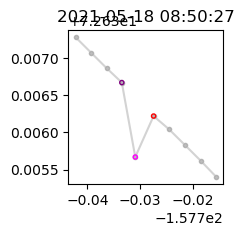

[-159.61879 -159.62323 -159.62761 -159.63194 -159.63589 -159.64192
 -159.64526 -159.64943 -159.65372] [72.91107 72.9118  72.91253 72.91325 72.91399 72.91483 72.9155  72.91623
 72.91695]


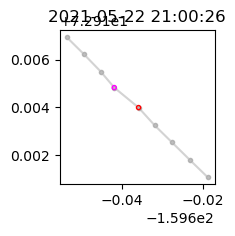

[-159.63965 -159.63832 -159.6369  -159.63542 -159.63461 -159.63219
 -159.63051 -159.62857] [72.99474 72.99471 72.99467 72.99461 72.9948  72.99443 72.99425 72.99407]


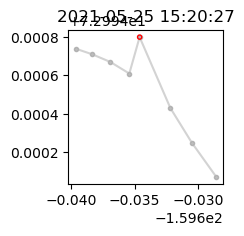

[-159.75076 -159.75276 -159.7547  -159.75661 -159.75847 -159.75856
 -159.76215 -159.76382 -159.76544 -159.76703] [72.91005 72.90984 72.90967 72.90947 72.90929 72.90923 72.90894 72.90878
 72.90863 72.90848]


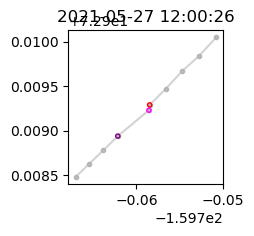

[-160.06161 -160.06427 -160.06694 -160.06961 -160.07335 -160.07574
 -160.07857 -160.08127] [72.77655 72.7763  72.77605 72.77583 72.7754  72.77538 72.77515 72.77489]


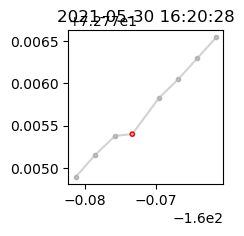

[-160.42032 -160.4223  -160.42433 -160.42639 -160.42842 -160.4305
 -160.43256 -160.43459 -160.43665] [72.74705 72.7469  72.74673 72.74657 72.74678 72.74615 72.74599 72.7458
 72.74563]


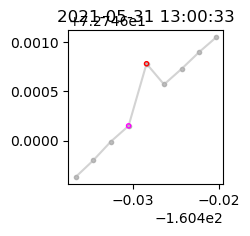

[-160.8941  -160.89464 -160.89522 -160.89536 -160.89499 -160.89635
 -160.89735 -160.89792] [72.67376 72.67361 72.67345 72.67335 72.67326 72.67306 72.67284 72.67269]


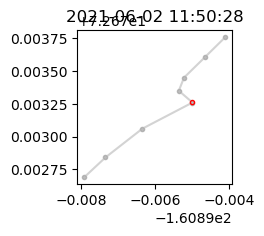

[-160.91895 -160.9202  -160.92148 -160.92273 -160.92404 -160.92381
 -160.92702 -160.92815 -160.92957 -160.93097] [72.66757 72.66737 72.66717 72.66696 72.66676 72.66705 72.6663  72.66622
 72.66605 72.6659 ]


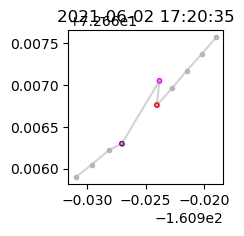

[-160.92957 -160.93097 -160.93251 -160.93401 -160.93607 -160.93692
 -160.93848 -160.94002] [72.66605 72.6659  72.66573 72.66557 72.66517 72.66536 72.66523 72.66513]


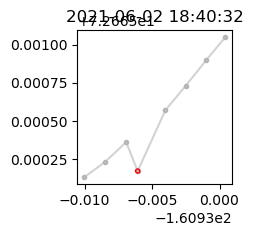

[-161.00377 -161.00523 -161.00681 -161.00882 -161.0108  -161.00854
 -161.01488 -161.01678 -161.01843 -161.01987 -161.02133] [72.6635  72.66343 72.66337 72.66341 72.66348 72.65966 72.66029 72.66362
 72.66362 72.66359 72.66356]


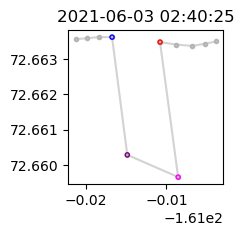

[-161.12576 -161.12756 -161.12935 -161.13113 -161.13293 -161.12892
 -161.14084 -161.13849 -161.14034 -161.1423  -161.14432] [72.66558 72.66552 72.66547 72.66542 72.66539 72.66697 72.66414 72.66519
 72.66513 72.66507 72.66501]


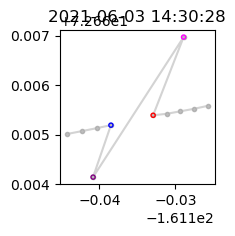

[-161.17244 -161.17477 -161.17715 -161.17952 -161.1819  -161.18358
 -161.18657 -161.1888  -161.19095 -161.19321] [72.66447 72.66449 72.66453 72.66453 72.6646  72.66541 72.66481 72.6649
 72.66502 72.66515]


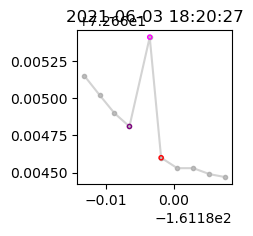

[-161.23315 -161.23486 -161.23595 -161.2372  -161.23849 -161.23936
 -161.24095 -161.24208 -161.24312 -161.2442 ] [72.67019 72.6706  72.67087 72.67109 72.67141 72.67125 72.67197 72.67224
 72.67253 72.6728 ]


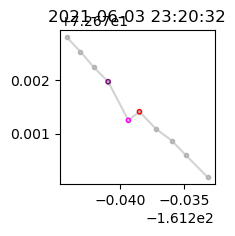

[-161.28235 -161.28352 -161.28471 -161.28584 -161.28714 -161.28453
 -161.28938 -161.29054 -161.29169 -161.29285] [72.67757 72.67764 72.67771 72.67779 72.67795 72.67774 72.6781  72.67823
 72.67837 72.67851]


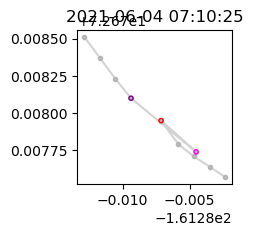

[-161.31779 -161.31813 -161.31853 -161.31895 -161.31929 -161.32446
 -161.3203  -161.32079 -161.32132 -161.3219 ] [72.68951 72.68963 72.68975 72.68986 72.68999 72.68867 72.69022 72.69035
 72.69051 72.69067]


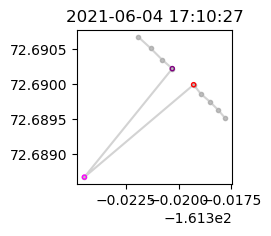

[-161.3373  -161.33685 -161.33635 -161.33586 -161.33656 -161.33487
 -161.33427 -161.3336 ] [72.70931 72.70984 72.71037 72.71087 72.71119 72.71183 72.7123  72.71278]


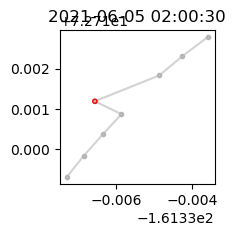

[-161.2953  -161.29514 -161.29509 -161.29494 -161.29491 -161.29059
 -161.29501 -161.29507 -161.29521 -161.29538] [72.73067 72.73065 72.73061 72.73061 72.73062 72.73081 72.73064 72.73066
 72.73071 72.73077]


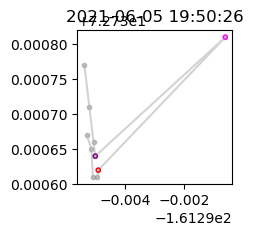

[-161.21497 -161.21428 -161.21359 -161.21249 -161.21265 -161.21138
 -161.21043 -161.20947] [72.75465 72.75504 72.75542 72.75585 72.75605 72.75649 72.75686 72.75721]


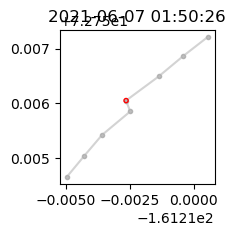

[-161.20206 -161.20302 -161.20351 -161.2039  -161.20328 -161.20464
 -161.20491 -161.20515] [72.76511 72.76537 72.76572 72.76609 72.76626 72.76691 72.76733 72.76777]


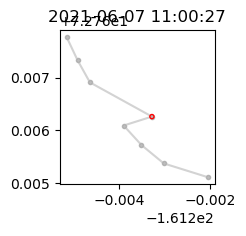

[-161.73961 -161.74168 -161.74379 -161.74594 -161.74814 -161.7491
 -161.75237 -161.75458 -161.75676 -161.759  ] [73.01797 73.01816 73.01836 73.01855 73.01878 73.01843 73.01917 73.01939
 73.01961 73.01984]


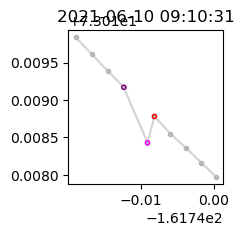

In [486]:


flag_indices = np.where(flag1 == True)[0] + 1 # add 1 since flagged accelerations are forward-looking
flag_groups = list(ranges(flag_indices))


# %matplotlib notebook
%matplotlib inline

for flag_group in flag_groups:
    
    fig, ax = plt.subplots(figsize=(2,2))
    ax.set_title(raw_dates[flag_group[0]])
    
    buffer = 4
    local_lons = cleaned['lon']['v0'][flag_group[0]-buffer:flag_group[-1]+buffer]
    local_lats = cleaned['lat']['v0'][flag_group[0]-buffer:flag_group[-1]+buffer]
    
    print(local_lons, local_lats)
    
    ax.plot(local_lons, local_lats, c='lightgray', marker='.', zorder=0)
    ax.scatter(local_lons, local_lats, c='k', marker='.', alpha=0.1, zorder=0)
#     ax.scatter(local_lons, local_lats, 
#                    c = np.linspace(0,1,len(local_lats)), cmap='Greys', marker='.', zorder=0)
    
    colors = ['red', 'magenta', 'purple', 'blue', 'green']
    
    for ff, f_ind in enumerate(flag_group):
        ax.scatter(cleaned['lon']['v0'][f_ind], cleaned['lat']['v0'][f_ind], 
                   marker='.', facecolor='None', edgecolor=colors[ff], zorder=1)

#     ax.plot([ax.get_xlim()[-1]-0.001, ax.get_xlim()[-1]-0.001],
#             [ax.get_ylim()[-1]-0.001, ax.get_ylim()[-1]-0.002], c='purple', marker='.')
    plt.show()
 

### (1d) Remove flagged values
Remove sequences of 1-2 flagged values. Sequences of 3+ flagged values, just remove middle points. This is based on drift track errors seen in plots above

In [922]:
# remove_indices = np.array([], dtype=int)

# for flag_group in flag_groups:    
#     # if 3 or more flagged, delete middle points
#     if len(flag_group) >= 3:
#         for ii in flag_group[1:-1]:
#             remove_indices = np.append(remove_indices, int(ii))
#     # if 1 or 2 flagged, delete each point
#     else:
#         for ii in flag_group:
#             remove_indices = np.append(remove_indices, int(ii))

remove_indices = FLAG

print(f'>>> removing {len(remove_indices)} flagged values')

cleaned['lon']['v1'] = np.copy(cleaned['lon']['v0'])
cleaned['lat']['v1'] = np.copy(cleaned['lat']['v0'])

cleaned['lat']['v1'][remove_indices] = np.nan
cleaned['lon']['v1'][remove_indices] = np.nan

>>> removing 43 flagged values


### (1d) Confirm that flagged values were removed

0.13 % of the data is flagged


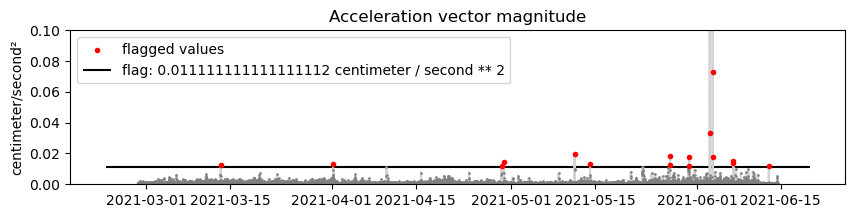

In [923]:
# calculate forward looking velocities and acclerations between reported times
out = calculate_velocity(lons = cleaned['lon']['v1'], lats = cleaned['lat']['v1'], times = raw_dates, 
                         method = 'forward', skip_nans = True, acceleration = True)
u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out

# flag large accelerations
flag1 = ACC > flag_thresh

# PLOT
fig, ax = plt.subplots(figsize=(10,2))
plt.title('Acceleration vector magnitude')
plt.ylim(0,0.1)
plt.plot(time, ACC, zorder=0, c='lightgray')
plt.scatter(time, ACC, marker='.', s=3, zorder=0, c='gray')
plt.scatter(time[flag1], ACC[flag1], marker='.', c='r', zorder=1, label='flagged values')
plt.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, colors='k', label=f'flag: {flag_thresh}')
plt.legend();
print(f'{100*np.sum(flag1)/len(flag1):.2f} % of the data is flagged')
# plt.xlim(Timestamp('2021-03-04 00:00:00'), Timestamp('2021-03-07 16:00:00'))


### (1e) Define function to remove nans in bulk

In [455]:
def remove_flagged_vals(lons = [], lats = [], acceleration = [], flag_thresh = (0.0138 *units('cm/s')/units('s')), quiet=True):
    
    # flag large accelerations
    flag = acceleration > flag_thresh

    # find groups of flags
    flag_indices = np.where(flag == True)[0] + 1 # add 1 since flagged accelerations are forward-looking
    flag_groups = list(ranges(flag_indices))

    # remove flags
    remove_indices = np.array([], dtype=int)
    for flag_group in flag_groups:    
        # if 3 or more flagged, delete middle points
        if len(flag_group) >= 3:
            for ii in flag_group[1:-1]:
                remove_indices = np.append(remove_indices, int(ii))
        # if 1 or 2 flagged, delete each point
        else:
            for ii in flag_group:
                remove_indices = np.append(remove_indices, int(ii))
    if not quiet:
        print(f'>>> removing {len(remove_indices)} flagged values')

    clean_lon = np.copy(lons)
    clean_lat = np.copy(lats)
    
    clean_lon[remove_indices] = np.nan
    clean_lat[remove_indices] = np.nan
    
    # return updated list
    return clean_lon, clean_lat, remove_indices


### (1f) Run function to remove final nan that still popped up after initial cleaning

In [456]:
version = 1

vi = f'v{version}'      # initial version
vn = f'v{version+1}'    # next version
print(f'{vi} --> {vn}')

out = remove_flagged_vals(lons = cleaned['lon'][vi], 
                          lats = cleaned['lat'][vi], 
                          acceleration = ACC, flag_thresh = (0.0138 *units('cm/s')/units('s')))
cleaned['lon'][vn], cleaned['lat'][vn], flags = out
numflag = np.sum(flags)

# calculate forward looking velocities and acclerations between reported times
out = calculate_velocity(lons = cleaned['lon'][vn], lats = cleaned['lat'][vn], times = raw_dates, 
                         method = 'forward', skip_nans = True, acceleration = True)
u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out

# flag large accelerations
flag1 = ACC > flag_thresh

# PLOT
fig, ax = plt.subplots(figsize=(10,2))
plt.title('Acceleration vector magnitude')
plt.ylim(0,0.1)
plt.plot(time, ACC, zorder=0, c='lightgray')
plt.scatter(time, ACC, marker='.', s=3, zorder=0, c='gray')
plt.scatter(time[flag1], ACC[flag1], marker='.', c='r', zorder=1, label='flagged values')
plt.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, colors='k', label=f'flag: {flag_thresh}')
plt.legend();
print(f'{100*np.sum(flag1)/len(flag1):.2f} % of the data is flagged')
# plt.xlim(Timestamp('2021-03-04 00:00:00'), Timestamp('2021-03-07 16:00:00'))


v1 --> v2


KeyError: 'v1'

## (2) Clean all data

buoy 23
 - v0
>>> removing 51 flagged values
 - v1
>>> removing 1 flagged values
 - v2
>>> removing 0 flagged values


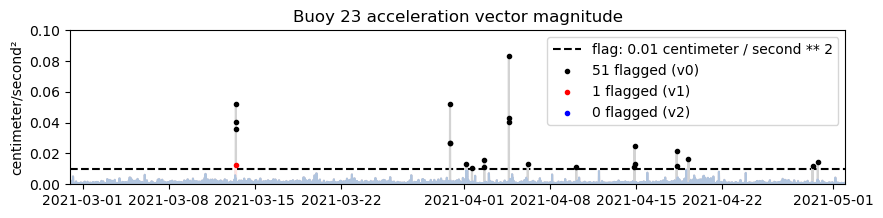

buoy 24
 - v0
>>> removing 14 flagged values
 - v1
>>> removing 2 flagged values
 - v2
>>> removing 1 flagged values
 - v3
>>> removing 1 flagged values
 - v4
>>> removing 1 flagged values


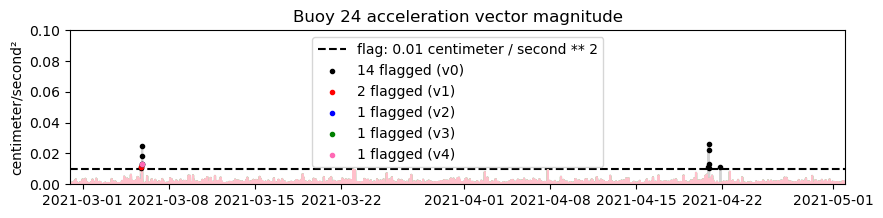

buoy 25
 - v0
>>> removing 64 flagged values
 - v1


KeyboardInterrupt: 

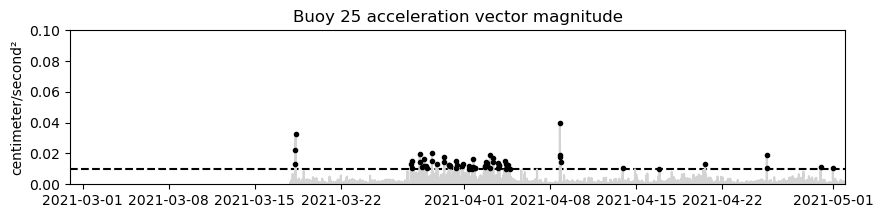

In [457]:

#===========================================
FLAG = (0.01 * units('cm/s')/units('s'))
#===========================================

clean = {}

for file in csv_files:

    buoy_num = file.split('/')[-1].split('_300')[0].split('OSU_IT_')[-1]
    print(f'buoy {buoy_num}')
    
    clean[buoy_num] = {}
    clean[buoy_num]['lat'] = {}
    clean[buoy_num]['lon'] = {}
    
    # open raw buoy data
    df = pd.read_csv(file)
    raw_dates = pd.to_datetime(df.datetime.values)
    raw_lat = df.latitude.values
    raw_lon = df.longitude.values

    clean[buoy_num]['time'] = raw_dates
    clean[buoy_num]['lat']['v0'] = raw_lat
    clean[buoy_num]['lon']['v0'] = raw_lon
    
    
    fig, ax = plt.subplots(figsize=(10,2))
    ax.set_title(f'Buoy {buoy_num} acceleration vector magnitude')
    ax.set_ylim(0,0.1)
    ax.set_xlim(Timestamp('2021-02-28 00:00:00'), Timestamp('2021-05-02 00:00:00'))
#     ax.set_xlim(clean[buoy_num]['time'][0], clean[buoy_num]['time'][-1])
    ax.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, linestyles='dashed', colors='k', label=f'flag: {flag_thresh}')
    colors = ['k', 'red', 'blue', 'green', 'hotpink', 'darkmagenta']
    colors2 = ['lightgray', 'mistyrose', 'lightsteelblue', 'lightgreen', 'pink', 'thistle']
    
    numflag = 1
    ii = 0
    
    # iteratively flag values with erroneously large accelerations
    while (numflag > 0) and (ii < 5):
        
        print(f' - v{ii}')
        
        # calculate forward looking velocities and acclerations between reported times
        out = calculate_velocity(lons = clean[buoy_num]['lon'][f'v{ii}'], 
                                 lats = clean[buoy_num]['lat'][f'v{ii}'], 
                                 times = clean[buoy_num]['time'], 
                                 method = 'forward', skip_nans = True, acceleration = True)
        u, v, sp, time, lat, lon, dx, dy, di, az, dt, au, av, ACC = out

        if ii == 0:
            clean[buoy_num]['ACC'] = ACC
            clean[buoy_num]['sp'] = sp
            
        out = remove_flagged_vals(lons = clean[buoy_num]['lon'][f'v{ii}'], 
                                  lats = clean[buoy_num]['lat'][f'v{ii}'], 
                                  acceleration = ACC, flag_thresh = FLAG, quiet=False)
        clean[buoy_num]['lon'][f'v{ii+1}'], clean[buoy_num]['lat'][f'v{ii+1}'], flags = out
        
        numflag = len(flags)
        
        # flag large accelerations
        flag1 = ACC > FLAG
        
        # PLOT
        if ii > 5:
            jj = ii - 5
        else:
            jj = ii
        ax.plot(time, ACC, zorder=0, c=colors2[jj])
#         ax.scatter(time, ACC, marker='.', s=3, zorder=0, c='gray')
        ax.scatter(time[flag1], ACC[flag1], marker='.', c=colors[jj], zorder=ii+1, label=f'{numflag} flagged (v{ii})')

        ii += 1

    plt.legend();
    plt.show()
        

In [433]:
all_acc = np.array([])
all_spe = np.array([])
for num in list(clean.keys()):
    all_acc = np.append(all_acc, clean[num]['ACC'].magnitude)
    all_spe = np.append(all_spe, clean[num]['sp'].magnitude)
    
print(f'accelerations when speeds are erroneously large (>100 cm/s): ')
print(all_acc[np.where(all_spe>100)])
print('>>> These are too large of accelerations (cm/s2), so using an acceleration flag alone should be good!')

accelerations when speeds are erroneously large (>100 cm/s): 
[0.38581876 0.2062713  0.18853404 0.59723563 0.21136028]
>>> These are too large of accelerations (cm/s2), so using an acceleration flag alone should be good!


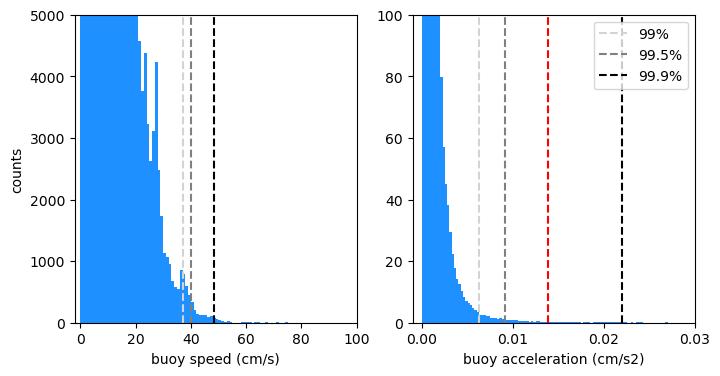

In [434]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].set_xlabel('buoy speed (cm/s)')
axs[0].set_ylabel('counts')
axs[0].set_ylim(0,5000)
axs[0].set_xlim(-2,100)
axs[0].hist(all_spe, bins=np.arange(0,100, 1), color='dodgerblue');
axs[0].vlines(np.nanpercentile(all_spe, 99), *axs[0].get_ylim(), colors='lightgray', linestyles='dashed', label='99%')
axs[0].vlines(np.nanpercentile(all_spe, 99.5), *axs[0].get_ylim(), colors='gray', linestyles='dashed', label='99.5%')
axs[0].vlines(np.nanpercentile(all_spe, 99.9), *axs[0].get_ylim(), colors='k', linestyles='dashed', label='99.9%')

axs[1].set_xlabel('buoy acceleration (cm/s2)')
axs[1].set_ylim(0,100)
axs[1].set_xlim(-0.001,0.03)
axs[1].hist(all_acc, bins=np.arange(0,0.04, 0.00025), density=True, color='dodgerblue');
axs[1].vlines((50 * units('cm/s')/units('hr').to('s')).magnitude, *axs[1].get_ylim(), colors='r', linestyles='dashed')
axs[1].vlines(np.nanpercentile(all_acc, 99), *axs[1].get_ylim(), colors='lightgray', linestyles='dashed', label='99%')
axs[1].vlines(np.nanpercentile(all_acc, 99.5), *axs[1].get_ylim(), colors='gray', linestyles='dashed', label='99.5%')
axs[1].vlines(np.nanpercentile(all_acc, 99.9), *axs[1].get_ylim(), colors='k', linestyles='dashed', label='99.9%')
plt.legend()

In [435]:
print('Acceleration percentile values')
for perc in [99.0, 99.5, 99.9]:
    print(f'  - {perc}% : {np.nanpercentile(all_acc, perc):.6f} cm/s2 ({3600*np.nanpercentile(all_acc, perc):.2f} (cm/s)/hr)')
print(f"\nSo let's use acceleration 0.01 cm/s2 threshold")

Acceleration percentile values
  - 99.0% : 0.006302 cm/s2 (22.69 (cm/s)/hr)
  - 99.5% : 0.009108 cm/s2 (32.79 (cm/s)/hr)
  - 99.9% : 0.022001 cm/s2 (79.20 (cm/s)/hr)

So let's use acceleration 0.01 cm/s2 threshold


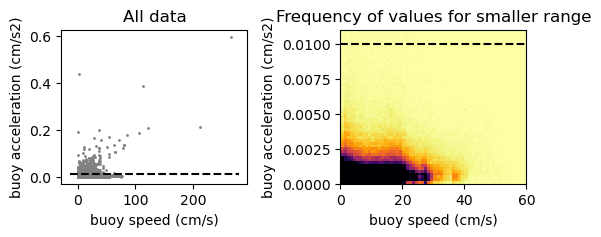

In [436]:
fig, axs = plt.subplots(1,2,figsize=(6,2))
plt.subplots_adjust(wspace=0.5)
axs[0].set_title('All data')
axs[0].set_xlabel('buoy speed (cm/s)')
axs[0].set_ylabel('buoy acceleration (cm/s2)')
axs[0].scatter(all_spe, all_acc, s = 1, c='gray');
axs[0].hlines(0.01, *axs[0].get_xlim(), colors='k', linestyles='dashed', label='99.9%')

spe_nonan = all_spe[np.isnan(all_acc) == False]
acc_nonan = all_acc[np.isnan(all_acc) == False]
axs[1].set_title('Frequency of values for smaller range')
axs[1].set_xlabel('buoy speed (cm/s)')
axs[1].set_ylabel('buoy acceleration (cm/s2)')
axs[1].hist2d(spe_nonan, acc_nonan, bins=[np.arange(0,61,1), np.arange(0,0.015, 0.0002)], 
              cmap='inferno_r', vmin=0, vmax = 500);
axs[1].set_ylim(0,0.011)
axs[1].set_xlim(0,60)
axs[1].hlines(0.01, *axs[1].get_xlim(), colors='k', linestyles='dashed', label='99.9%')

In [ ]:
#=============================================
flag_thresh = (0.01 *units('cm/s')/units('s'))
#=============================================

# calculate forward-looking accelerations (time step tt's acceleration assigned as between (tt) and (tt+1))
DT = np.array([(time[tt+1]-time[tt]).total_seconds() for tt in range(len(time)-1)])*units('seconds')
DU = np.array([(u[tt+1]-u[tt]).magnitude for tt in range(len(time)-1)])*units('cm/s')
DV = np.array([(v[tt+1]-v[tt]).magnitude for tt in range(len(time)-1)])*units('cm/s')

# acceleration
ACC = np.sqrt(DU**2+DV**2)/DT

# flag large accelerations
flag1 = ACC > flag_thresh



# PLOT
fig, ax = plt.subplots(figsize=(10,2))
plt.title('Acceleration vector magnitude')
plt.ylim(0,0.1)
plt.plot(time[:-1], ACC, zorder=0, c='lightgray')
plt.scatter(time[:-1], ACC, marker='.', s=3, zorder=0, c='gray')
plt.scatter(time[:-1][flag1], ACC[flag1], marker='.', c='r', zorder=1, label='flagged values')
plt.hlines(flag_thresh, ax.get_xlim()[0], ax.get_xlim()[-1], zorder=-1, colors='k', label=f'flag: {flag_thresh}')
plt.legend();
print(f'{100*np.sum(flag1)/len(flag1):.2f} % of the data is flagged')
# plt.xlim(Timestamp('2021-06-01 00:00:00'), Timestamp('2021-06-10 16:00:00'))

In [14]:
# interp_lats = np.array([])
# interp_lons = np.array([])


# for date_c in desired_dates:

#     # get index before date
#     idx = bisect.bisect_left(raw_dates, date_c)

#     # if desired date is before first reported date,
#     # fill position with nans
#     if idx == 0:
#         print(True)

#         lat_c = np.nan
#         lon_c = np.nan

#     else:

#         date_i = raw_dates[idx-1] # date before
#         lon_i  = raw_lon[idx-1]   # coordinates before
#         lat_i  = raw_lat[idx-1]

#         date_f = raw_dates[idx] # date after
#         lon_f  = raw_lon[idx]   # coordinates after
#         lat_f  = raw_lat[idx]

#         dt = ((date_f - date_i).total_seconds()/60) # minutes
#         dx = lon_f - lon_i
#         dy = lat_f - lat_i

#         # fractions of time step between date_f and date_i 
#         # occuring between date_i and date_c
#         dt_frac_i = ((date_c - date_i).total_seconds()/60)/dt

#         # simple zonal and meridional interpolation
#         # fraction of zonal and meridional displacements from (i) to (f)
#         lat_c = lat_i + (dt_frac_i * dy)
#         lon_c = lon_i + (dt_frac_i * dx)

#     interp_lats = np.append(interp_lats, lat_c)
#     interp_lons = np.append(interp_lons, lon_c)

In [15]:
# from LIB_SIDExbuoy import calc_velocity
# out = calc_velocity(lon_track=raw_lon, lat_track=raw_lat, time_track=raw_dates, 
#                     step=1, vflag = 10000*units('cm')/units('s'))

# u, v, sp, time, dx, dy, distance = out
              

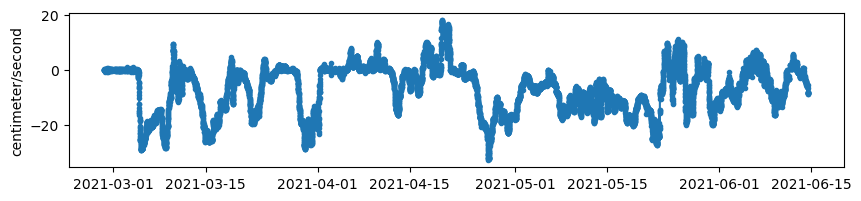

In [45]:
from itertools import groupby
def ranges(lst):
    pos = (j - i for i, j in enumerate(lst))
    t = 0
    for i, els in groupby(pos):
        l = len(list(els))
        el = lst[t]
        t += l
        yield range(el, el+l)

        
flag_indices = np.where(flag1 == True)[0] + 1 # add 1 since accelerations shifted by 1 from time index

flag_groups = list(ranges(flag_indices))
flag_groups

[]

0


In [218]:
from pandas import Timestamp

In [266]:
# groups of three large accelerations in a row indicate
# individual falsely reported data point in middle

(18699.0, 18699.666666666668)

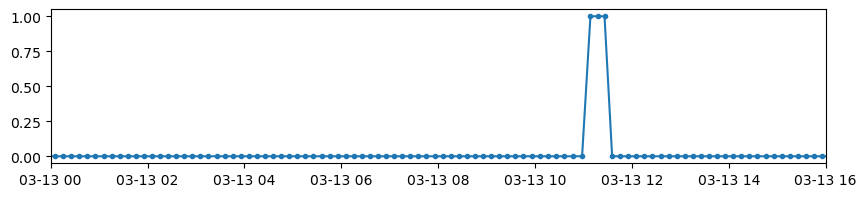

In [265]:
fig, ax = plt.subplots(figsize=(10,2))
plt.plot(time[1:], flag1, marker='.')
plt.xlim(Timestamp('2021-03-13 00:00:00'), Timestamp('2021-03-13 16:00:00'))

(18716.5, 18717.5)

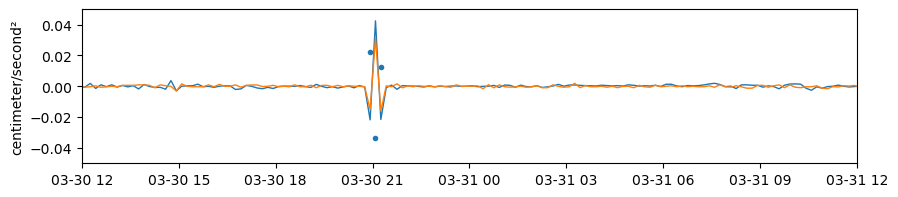

In [256]:
fig, ax = plt.subplots(figsize=(10,2))
plt.plot(time[1:], np.diff(u)/DT, lw=1)
plt.plot(time[1:], np.diff(v)/DT, lw=1)
plt.scatter(time[1:][flag1], (np.diff(sp)/DT)[flag1], marker='.')
plt.ylim(-0.05,0.05)
plt.xlim(Timestamp('2021-03-30 12:00:00'), Timestamp('2021-03-31 12:00:00'))

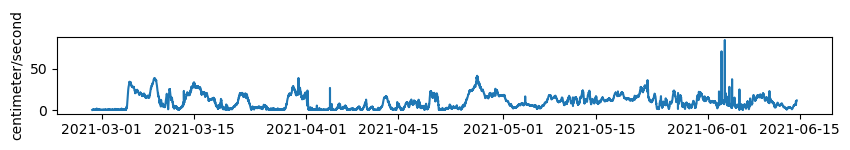

In [204]:
fig, ax = plt.subplots(figsize=(10,1))
plt.plot(time, sp)

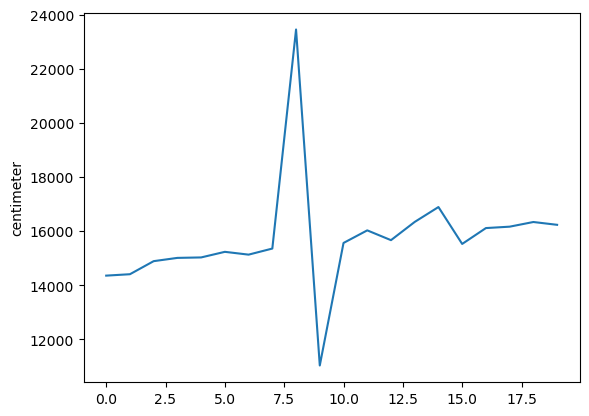

In [205]:
from pyproj import Geod
g = Geod(ellps='WGS84')
from metpy.units import units

distance = np.array([])
azimuth = np.array([])

for ii in range(4320, 4340):
    
    # start location
    loc1=(raw_lat[ii], raw_lon[ii])
    # end location
    loc2=(raw_lat[ii+1], raw_lon[ii+1])

    # compute forward and back azimuths, plus distance
    az12,az21,dist = g.inv(loc1[1],loc1[0],loc2[1],loc2[0])
    distance = np.append(distance, dist*units('meter').to('cm'))
    azimuth  = np.append(azimuth, az12)

    # angle from east
    beta = 90 * units('degree') - az12 * units('degree')
    if beta <= -180*units('degree'):
        beta += 360*units('degree')

    # calculate zonal, meridional displacements fmor azimuth
    DX = (dist*units('meter') * np.cos(beta.to('radian'))).to('cm')
    DY = (dist*units('meter') * np.sin(beta.to('radian'))).to('cm')


plt.plot(distance)

In [168]:
ii = 4328

dx = raw_lon[ii+1] - raw_lon[ii]

dy = raw_lat[ii+1] - raw_lat[ii]

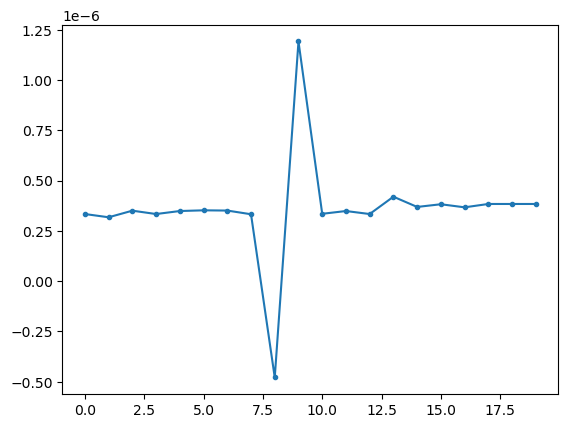

In [187]:
all_dy = np.array([])

for ii in range(4320, 4340):

    dx = raw_lon[ii+1] - raw_lon[ii]
    dy = raw_lat[ii+1] - raw_lat[ii]
    dt = (raw_dates[ii+1] - raw_dates[ii]).total_seconds()

    all_dy = np.append(all_dy, dy/dt)
    
    
plt.plot(all_dy, marker='.')

In [179]:
dt.total_seconds()

602.0

(71.76, 71.78)

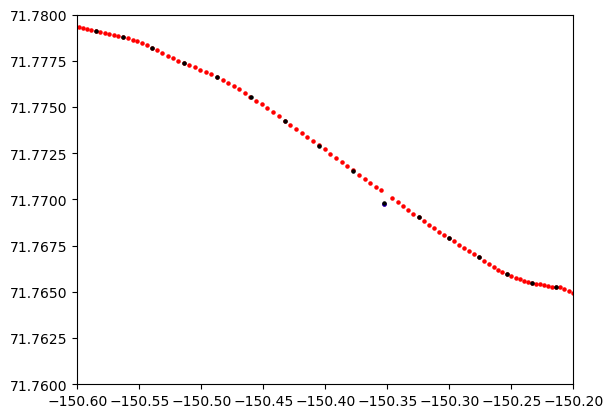

In [166]:
plt.scatter(raw_lon[4250:4390], raw_lat[4250:4390], c='r', s=5)
plt.scatter(raw_lon[4329], raw_lat[4329], c='b', s=5)
plt.scatter(interp_lons, interp_lats, c='k', s=5)

plt.xlim(-150.6, -150.2)
plt.ylim(71.76, 71.78)


In [167]:
raw_dates[4329]

Timestamp('2021-03-30 21:00:32')

In [91]:
dt_frac_f = ((date_af - date_c).total_seconds()/60)/dt # minutes
dt_frac_i = ((date_c - date_be).total_seconds()/60)/dt # minutes

In [92]:
date_c

datetime.datetime(2021, 3, 1, 4, 0)

In [93]:
date_af

Timestamp('2021-03-01 04:10:25')

In [94]:
date_be

Timestamp('2021-03-01 03:50:24')

In [81]:
dt_frac_i

0.47960033305578686

In [64]:
date_b = dates[idx-1]
date_a = dates[idx]

dt = (date_a - date_b).total_seconds()

### save short and long buoy numbers to list

In [3]:
buoy_nums = []
long_nums = []

for file in csv_files:
    
    buoy_num = '-'.join(file.split('/')[-1].split('_')[0].split('-')[2:])
    buoy_nums.append(buoy_num)
    
    long_num = file.split('/')[-1].split('_')[1]
    long_nums.append(long_num)


### Read in Bliss data version
* here note that buoys 34-1 and 34-2 are stored as single file: 300534061095090

In [4]:
# set list of path+name of csv files containing coordinates
# or set = None if not adding buoy coordinates
#==============================================================
# csv_directory = None
csv_directory = '/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/'
#==============================================================
csv_files = []
if csv_directory != None:
    files = sorted(list(glob.glob1(csv_directory, "*int.csv")));
    print('CSV files:')
    for ii in range(len(files)):
        csv_files.append(csv_directory+files[ii])
        print(csv_directory+files[ii])
            

CSV files:
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061090050_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061090090_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061091050_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061091060_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061091070_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061093020_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061093030_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061093040_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061093070_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/300534061094090_int.csv
/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/Tracks_Clean/3

# Grab half-hourly data from Feb 25 thru end of Sep 30

300534061090050
300534061090090
300534061091050
300534061091060
300534061091070
300534061093020
300534061093030
300534061093040
300534061093070
300534061094090
300534061095060
300534061095090
300534061096000
300534061096010
300534061096020
300534061096060
300534061097010
300534061097050
300534061098010
300534061098040
300534061098050
300534061099010
300534061980500
300534061982520
300534061984510
300534061984530
300534061984570
300534061985550
300534061986590
300534061987530
300534061988500


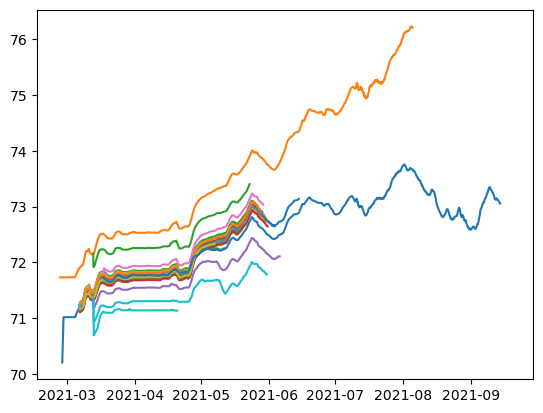

In [5]:
INITIAL_DATE = datetime.datetime(year = 2021, month=2, day=25, hour=0, minute=0) 
FINAL_DATE = datetime.datetime(year = 2021, month=10, day=1, hour=0, minute=0) 

desired_dates = np.array([INITIAL_DATE + ii*datetime.timedelta(minutes=30) for ii in range(int((FINAL_DATE-INITIAL_DATE).total_seconds()/(30*60)))])

# dict to save all buoy data 
# with specific datetime indexing
all_buoy_data = {}

for file in csv_files:
    
    # start dict
    buoy_long_num = file.split('/')[-1].split('_')[0]
    all_buoy_data[buoy_long_num] = {}
    
    print(buoy_long_num)

    # read in data
    df = pd.read_csv(file, header=None)
    lats = df[0].values
    lons = df[1].values
    times = pd.to_datetime(df[3].values)
    
    # find buoy coords for desired dates, nans when no data
    buoy_lats = np.array([])
    buoy_lons = np.array([])
    for date in desired_dates:
        index = np.where(times == date)[0]
        if len(index) > 0:
            buoy_lats = np.append(buoy_lats, lats[index])
            buoy_lons = np.append(buoy_lons, lons[index])
        else:
            buoy_lats = np.append(buoy_lats, np.nan)
            buoy_lons = np.append(buoy_lons, np.nan)
    
    # save data to dict
    all_buoy_data[buoy_long_num]['lat'] = buoy_lats
    all_buoy_data[buoy_long_num]['lon'] = buoy_lons
    
    # plot 
    plt.plot(desired_dates, buoy_lats)
    

## Plot all buoy data depolyment periods

[OSU-IT-23] 2021-02-27 13:10:24  ---  2021-06-14 13:22:15
[OSU-IT-24] 2021-02-26 23:20:25  ---  2021-08-05 05:20:38
[OSU-IT-25] 2021-03-17 21:00:26  ---  2021-05-12 13:00:25
[OSU-IT-26] 2021-03-06 23:30:26  ---  2021-05-25 16:40:39
[OSU-IT-27] 2021-03-13 04:20:27  ---  2021-06-05 20:50:37
[OSU-IT-28] 2021-03-06 23:40:25  ---  2021-04-25 05:50:29
[OSU-IT-29] 2021-03-06 23:50:26  ---  2021-05-20 07:50:35
[OSU-IT-30] 2021-03-06 23:10:25  ---  2021-04-24 21:43:55
[OSU-IT-31] 2021-03-18 02:40:25  ---  2021-05-30 04:20:37
[OSU-IT-32] 2021-03-06 23:40:25  ---  2021-05-20 13:20:36
[OSU-IT-33] 2021-03-06 23:00:25  ---  2021-05-29 17:40:36
[OSU-IT-34-1] 2021-03-06 23:40:26  ---  2021-03-21 00:30:26
[OSU-IT-34-2] 2021-03-21 00:40:27  ---  2021-05-31 16:40:28
[OSU-IT-35] 2021-03-06 23:30:25  ---  2021-05-24 00:15:43
[OSU-IT-36] 2021-03-06 23:50:27  ---  2021-05-20 11:51:09
[OSU-IT-37] 2021-03-06 23:00:24  ---  2021-03-18 22:10:26
[OSU-IT-38] 2021-03-06 23:40:26  ---  2021-05-25 21:50:38
[OSU-IT-39

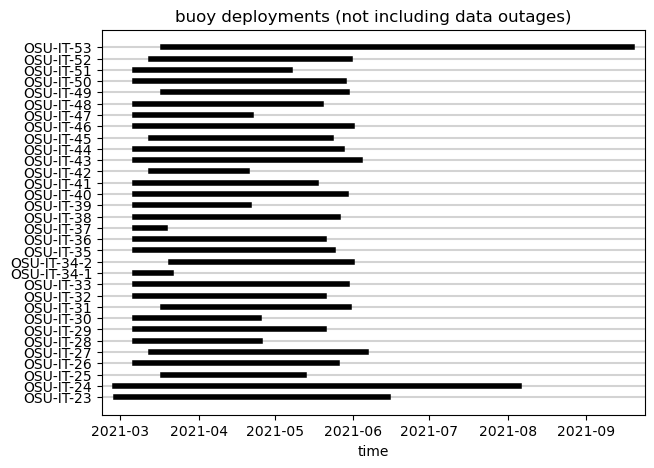

In [6]:
# read in data about buoy deployments
df = pd.read_csv('/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/sidex_tracks/sidex_deployments_v1.csv')
IDs = df['Buoy ID'].values
IMEIs = df['IMEI'].values
StartDates = pd.to_datetime(df['First Data'].values)
EndDates = pd.to_datetime(df['Last Data'].values)

fig, ax = plt.subplots(figsize=(7,5))
for ii, ID in enumerate(IDs):
    plt.plot([StartDates[ii], EndDates[ii]], [ID,ID], c='k', lw=4)
ax.set_xlim(np.min(StartDates)-datetime.timedelta(days=5), np.max(EndDates)+datetime.timedelta(days=5))
for ID in IDs:
    plt.hlines(ID, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', zorder=-1)
ax.set_xlabel('time')
ax.set_title('buoy deployments (not including data outages)')


for dd, ID in enumerate(IDs):
    
    print(f'[{ID}] {StartDates[dd]}  ---  {EndDates[dd]}')

[OSU-IT-23] 2021-02-27 13:10:24  ---  2021-06-14 13:22:15
[OSU-IT-24] 2021-02-26 23:20:25  ---  2021-08-05 05:20:38
[OSU-IT-25] 2021-03-17 21:00:26  ---  2021-05-12 13:00:25
[OSU-IT-26] 2021-03-06 23:30:26  ---  2021-05-25 16:40:39
[OSU-IT-27] 2021-03-13 04:20:27  ---  2021-06-05 20:50:37
[OSU-IT-28] 2021-03-06 23:40:25  ---  2021-04-25 05:50:29 ///////// REMOVE (time)
[OSU-IT-29] 2021-03-06 23:50:26  ---  2021-05-20 07:50:35
[OSU-IT-30] 2021-03-06 23:10:25  ---  2021-04-24 21:43:55 ///////// REMOVE (time)
[OSU-IT-31] 2021-03-18 02:40:25  ---  2021-05-30 04:20:37
[OSU-IT-32] 2021-03-06 23:40:25  ---  2021-05-20 13:20:36
[OSU-IT-33] 2021-03-06 23:00:25  ---  2021-05-29 17:40:36
[OSU-IT-34-1] 2021-03-06 23:40:26  ---  2021-03-21 00:30:26 ///////// REMOVE (time)
[OSU-IT-34-2] 2021-03-21 00:40:27  ---  2021-05-31 16:40:28 ///////// REMOVE (time)
[OSU-IT-35] 2021-03-06 23:30:25  ---  2021-05-24 00:15:43
[OSU-IT-36] 2021-03-06 23:50:27  ---  2021-05-20 11:51:09
[OSU-IT-37] 2021-03-06 23:00:24  ---  2021-03-18 22:10:26 ///////// REMOVE (time)
[OSU-IT-38] 2021-03-06 23:40:26  ---  2021-05-25 21:50:38
[OSU-IT-39] 2021-03-06 23:40:26  ---  2021-04-20 23:30:55 ///////// REMOVE (time)
[OSU-IT-40] 2021-03-06 23:00:25  ---  2021-05-28 23:50:25
[OSU-IT-41] 2021-03-06 23:30:26  ---  2021-05-17 05:17:43
[OSU-IT-42] 2021-03-13 09:00:24  ---  2021-04-20 04:10:25 ///////// REMOVE (time)
[OSU-IT-43] 2021-03-06 23:00:25  ---  2021-06-03 17:30:32
[OSU-IT-44] 2021-03-06 23:00:25  ---  2021-05-27 14:10:26 ///////// REMOVE (proximity)
[OSU-IT-45] 2021-03-13 04:00:54  ---  2021-05-23 03:14:54
[OSU-IT-46] 2021-03-06 23:20:29  ---  2021-05-31 10:26:36
[OSU-IT-47] 2021-03-06 23:50:30  ---  2021-04-21 14:00:40 ///////// REMOVE (time)
[OSU-IT-48] 2021-03-06 23:20:24  ---  2021-05-19 05:20:38
[OSU-IT-49] 2021-03-17 21:20:26  ---  2021-05-29 11:20:38
[OSU-IT-50] 2021-03-06 23:50:25  ---  2021-05-28 12:50:34
[OSU-IT-51] 2021-03-06 23:40:25  ---  2021-05-07 05:11:55
[OSU-IT-52] 2021-03-13 06:40:27  ---  2021-05-30 21:40:24
[OSU-IT-53] 2021-03-18 02:00:26  ---  2021-09-18 23:52:32


## Data clean 1: 
---
### Find which buoys to remove due to missing data during case study events

In [7]:
long_remove_buoys = []
short_remove_buoys = []

# find indices of event one dates
print('\nEVENT 1')
print('Remove buoys:\n------------')
date_indices = (desired_dates>=datetime.datetime(2021, 3, 28, 0, 0))&(desired_dates<=datetime.datetime(2021, 4, 3, 0, 0))

for buoy in all_buoy_data:
    short_buoy_num = buoy_nums[long_nums.index(buoy)]
    event_nans = np.sum(np.isnan(all_buoy_data[buoy]['lat'][date_indices]))
    if event_nans > 0:
        print(f'- {buoy} (buoy {short_buoy_num})  >>>> MISSING DATA ({event_nans} nans)')
        if buoy not in long_remove_buoys:
            long_remove_buoys.append(buoy)
            short_remove_buoys.append(short_buoy_num)

# find indices of event two dates    
print('\nEVENT 2')
print('Remove buoys:\n------------')
date_indices = (desired_dates>=datetime.datetime(2021, 4, 15, 0, 0))&(desired_dates<=datetime.datetime(2021, 4, 22, 0, 0))

for buoy in all_buoy_data:
    short_buoy_num = buoy_nums[long_nums.index(buoy)]
    event_nans = np.sum(np.isnan(all_buoy_data[buoy]['lat'][date_indices]))
    if event_nans > 0:
        print(f'- {buoy} (buoy {short_buoy_num})  >>>> MISSING DATA ({event_nans} nans)')
        if buoy not in long_remove_buoys:
            long_remove_buoys.append(buoy)
            short_remove_buoys.append(short_buoy_num)



EVENT 1
Remove buoys:
------------
- 300534061096020 (buoy 37)  >>>> MISSING DATA (289 nans)
- 300534061984510 (buoy 47)  >>>> MISSING DATA (23 nans)

EVENT 2
Remove buoys:
------------
- 300534061096020 (buoy 37)  >>>> MISSING DATA (337 nans)
- 300534061097010 (buoy 39)  >>>> MISSING DATA (50 nans)
- 300534061098040 (buoy 42)  >>>> MISSING DATA (88 nans)
- 300534061984510 (buoy 47)  >>>> MISSING DATA (158 nans)


In [8]:

# find indices of event one dates
print('\nlonger time series')
print('Remove buoys:\n------------')
date_indices = (desired_dates>=datetime.datetime(2021, 3, 20, 10, 0))&(desired_dates<=datetime.datetime(2021, 5, 1, 0, 0))

for buoy in all_buoy_data:
    short_buoy_num = buoy_nums[long_nums.index(buoy)]
    event_nans = np.sum(np.isnan(all_buoy_data[buoy]['lat'][date_indices]))
    if event_nans > 0:
        print(f'- {buoy} (buoy {short_buoy_num})  >>>> MISSING DATA ({event_nans} nans)')
        if buoy not in long_remove_buoys:
            long_remove_buoys.append(buoy)
            short_remove_buoys.append(short_buoy_num)


longer time series
Remove buoys:
------------
- 300534061093020 (buoy 28)  >>>> MISSING DATA (277 nans)
- 300534061093040 (buoy 30)  >>>> MISSING DATA (293 nans)
- 300534061096020 (buoy 37)  >>>> MISSING DATA (1997 nans)
- 300534061097010 (buoy 39)  >>>> MISSING DATA (482 nans)
- 300534061098040 (buoy 42)  >>>> MISSING DATA (520 nans)
- 300534061984510 (buoy 47)  >>>> MISSING DATA (1188 nans)


## Data clean 2: 
---
### Find which buoys to remove due to close proximity to other buoys
(Remove 2nd buoy (larger short index) of pair if buoy pair found within 2 km of one another)

Buoy pairs:
--------------
300534061090050 (23) -- 300534061095090 (34-1)
300534061091060 (26) -- 300534061099010 (44)


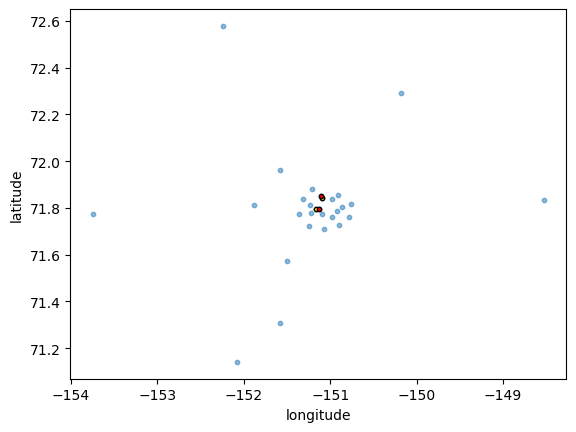


All buoys to remove:
--------------------
 - 300534061096020 (37)
 - 300534061984510 (47)
 - 300534061097010 (39)
 - 300534061098040 (42)
 - 300534061093020 (28)
 - 300534061093040 (30)
 - 300534061095090 (34-1)
 - 300534061099010 (44)


In [9]:
# look on specific date and find buoy pairs within 2 km of one another    
date_index = np.where(desired_dates==datetime.datetime(2021, 4, 15, 0, 0))[0]

time_slice_lats = np.array([])
time_slice_lons = np.array([])
for buoy in all_buoy_data:
    time_slice_lats = np.append(time_slice_lats, all_buoy_data[buoy]['lat'][date_index])
    time_slice_lons = np.append(time_slice_lons, all_buoy_data[buoy]['lon'][date_index])
plt.scatter(time_slice_lons, time_slice_lats, alpha=0.5, s=10)

print(f'Buoy pairs:\n--------------')
for TT in range(len(time_slice_lats)):
    for tt in range(len(time_slice_lats)):
        lons1,lats1 = time_slice_lons[TT], time_slice_lats[TT]
        lons2,lats2 = time_slice_lons[tt], time_slice_lats[tt]
        # compute forward and back azimuths, plus distance
        az12,az21,distance = g.inv(lons1, lats1, lons2, lats2)
        if distance < 2000:
            if TT != tt:
                buoy1 = list(all_buoy_data.keys())[TT]
                buoy2 = list(all_buoy_data.keys())[tt]
                
                short_buoy1 = buoy_nums[long_nums.index(buoy1)]
                short_buoy2 = buoy_nums[long_nums.index(buoy2)]
                
                if (buoy1 not in long_remove_buoys) & (buoy2 not in long_remove_buoys):
                
                    if short_buoy1 < short_buoy2:
                        long_remove_buoys.append(buoy2)
                        short_remove_buoys.append(short_buoy2)
                        print(f'{buoy1} ({short_buoy1}) -- {buoy2} ({short_buoy2})')
                        plt.scatter(time_slice_lons[tt], time_slice_lats[tt], alpha=1, facecolor='gold', edgecolor='k', s=10)
                        plt.scatter(time_slice_lons[TT], time_slice_lats[TT], alpha=1, facecolor='r', edgecolor='k', s=10)

plt.ylabel('latitude')
plt.xlabel('longitude')

plt.show()
print(f'\nAll buoys to remove:\n--------------------')
for bb, buoy in enumerate(short_remove_buoys):
    print(f' - {long_remove_buoys[bb]} ({buoy})')

# Create dictionary with finalized buoy data

In [10]:
final_buoy_data = {}
buoy_time = desired_dates

for buoy in all_buoy_data:
    if buoy not in long_remove_buoys:
        final_buoy_data[buoy] = {}
        final_buoy_data[buoy]['lat'] = all_buoy_data[buoy]['lat']
        final_buoy_data[buoy]['lon'] = all_buoy_data[buoy]['lon']
        
orig_buoys = len(list(all_buoy_data.keys()))
total_buoys = len(list(final_buoy_data.keys()))

print(f' >> use data from {total_buoys} of {orig_buoys} buoys')

for buoy in final_buoy_data:
        print(f' - {buoy} ({buoy_nums[long_nums.index(buoy)]})')

 >> use data from 23 of 31 buoys
 - 300534061090050 (23)
 - 300534061090090 (24)
 - 300534061091050 (25)
 - 300534061091060 (26)
 - 300534061091070 (27)
 - 300534061093030 (29)
 - 300534061093070 (31)
 - 300534061094090 (32)
 - 300534061095060 (33)
 - 300534061096000 (35)
 - 300534061096010 (36)
 - 300534061096060 (38)
 - 300534061097050 (40)
 - 300534061098010 (41)
 - 300534061098050 (43)
 - 300534061980500 (45)
 - 300534061982520 (46)
 - 300534061984530 (48)
 - 300534061984570 (49)
 - 300534061985550 (50)
 - 300534061986590 (51)
 - 300534061987530 (52)
 - 300534061988500 (53)


# Crop times before deployments
___
First find when buoy start times are

(18687.0, 18748.0)

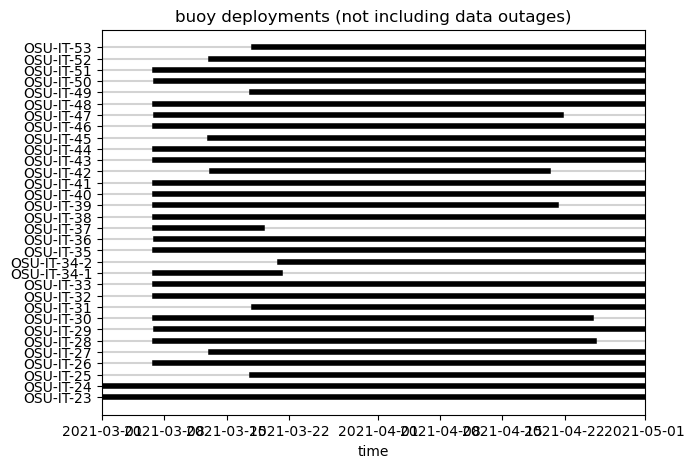

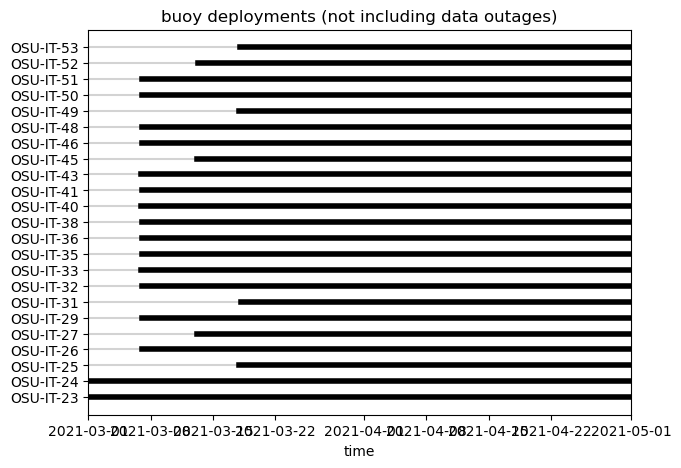

In [23]:
# read in data about buoy deployments
df = pd.read_csv('/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/sidex_tracks/sidex_deployments_v1.csv')
IDs = df['Buoy ID'].values
IMEIs = df['IMEI'].values
StartDates = pd.to_datetime(df['First Data'].values)
EndDates = pd.to_datetime(df['Last Data'].values)

fig, ax = plt.subplots(figsize=(7,5))
for ii, ID in enumerate(IDs):
    plt.plot([StartDates[ii], EndDates[ii]], [ID,ID], c='k', lw=4)
ax.set_xlim(np.min(StartDates)-datetime.timedelta(days=5), np.max(EndDates)+datetime.timedelta(days=5))
for ID in IDs:
    plt.hlines(ID, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', zorder=-1)
ax.set_xlabel('time')
ax.set_title('buoy deployments (not including data outages)')
ax.set_xlim(datetime.datetime(year=2021, month=3, day=1), datetime.datetime(year=2021, month=5, day=1))



# read in data about buoy deployments
df = pd.read_csv('/Volumes/Jewell_EasyStore/SIDEx2021/Bliss_buoy_data/PG/sidex_tracks/sidex_deployments_v1.csv')
IDs = df['Buoy ID'].values
IMEIs = df['IMEI'].values
StartDates = pd.to_datetime(df['First Data'].values)
EndDates = pd.to_datetime(df['Last Data'].values)

fig, ax = plt.subplots(figsize=(7,5))
for ii, ID in enumerate(IDs):
    if str(IMEIs[ii]) in list(final_buoy_data.keys()):
        plt.plot([StartDates[ii], EndDates[ii]], [ID,ID], c='k', lw=4)
        plt.hlines(ID, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', zorder=-1)
ax.set_xlim(np.min(StartDates)-datetime.timedelta(days=5), np.max(EndDates)+datetime.timedelta(days=5))
# for ID in IDs:
#     plt.hlines(ID, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', zorder=-1)
ax.set_xlabel('time')
ax.set_title('buoy deployments (only buoys considered in analysis)')
ax.set_xlim(datetime.datetime(year=2021, month=3, day=1), datetime.datetime(year=2021, month=5, day=1))

### Replace any data before official start date with nans

In [12]:
for buoy in final_buoy_data:
    
    # find buoy's start date
    buoy_index = np.where(IMEIs == int(buoy))[0]
    buoy_start_date = StartDates[buoy_index][0]
    print(f'{IDs[buoy_index][0]} --> {buoy_start_date}')

    # find all dates before verified start date
    before_start = buoy_time < buoy_start_date
    
    # replace data before this date with nans
    final_buoy_data[buoy]['lat'][before_start] = np.nan
    final_buoy_data[buoy]['lon'][before_start] = np.nan

OSU-IT-23 --> 2021-02-27 13:10:24
OSU-IT-24 --> 2021-02-26 23:20:25
OSU-IT-25 --> 2021-03-17 21:00:26
OSU-IT-26 --> 2021-03-06 23:30:26
OSU-IT-27 --> 2021-03-13 04:20:27
OSU-IT-29 --> 2021-03-06 23:50:26
OSU-IT-31 --> 2021-03-18 02:40:25
OSU-IT-32 --> 2021-03-06 23:40:25
OSU-IT-33 --> 2021-03-06 23:00:25
OSU-IT-35 --> 2021-03-06 23:30:25
OSU-IT-36 --> 2021-03-06 23:50:27
OSU-IT-38 --> 2021-03-06 23:40:26
OSU-IT-40 --> 2021-03-06 23:00:25
OSU-IT-41 --> 2021-03-06 23:30:26
OSU-IT-43 --> 2021-03-06 23:00:25
OSU-IT-45 --> 2021-03-13 04:00:54
OSU-IT-46 --> 2021-03-06 23:20:29
OSU-IT-48 --> 2021-03-06 23:20:24
OSU-IT-49 --> 2021-03-17 21:20:26
OSU-IT-50 --> 2021-03-06 23:50:25
OSU-IT-51 --> 2021-03-06 23:40:25
OSU-IT-52 --> 2021-03-13 06:40:27
OSU-IT-53 --> 2021-03-18 02:00:26


# Save data to output file

In [13]:
# # grab short buoy numbers
# long_buoy_nums = list(final_buoy_data.keys())
# short_buoy_nums = []
# for buoy in long_buoy_nums:
#     short_buoy_nums.append(buoy_nums[long_nums.index(buoy)])
#     print(f' IMEI {buoy}  -->  {buoy_nums[long_nums.index(buoy)]}')
    
# all_lats = np.array([])
# all_lons = np.array([])

# for buoy in final_buoy_data:
#     all_lats = np.append(all_lats, final_buoy_data[buoy]['lat'])
#     all_lons = np.append(all_lons, final_buoy_data[buoy]['lon'])
    
# buoy_lat_grid = np.reshape(all_lats, (len(final_buoy_data), len(desired_dates)))
# buoy_lon_grid = np.reshape(all_lons, (len(final_buoy_data), len(desired_dates)))

# OUTPUT_FILE = './data/BuoyCoordinates_cln_v3.nc'

# ds = xr.Dataset(
    
#     data_vars=dict(
#     latitude=(["buoyID", "time"], buoy_lat_grid, {"units": "degree_north"}),
#     longitude=(["buoyID", "time"], buoy_lon_grid, {"units": "degree_east"}),
#     ),
    
#     coords=dict(
#         time = (["time"], desired_dates), 
#         buoyID = (["buoyID"], short_buoy_nums),
#         buoyIMEI = (["buoyIMEI"], long_buoy_nums)),
    
#     attrs=dict(description="half-hourly interpolated buoy positions from Bliss&Hutchings"),
#     )

# ds.to_netcdf(path=OUTPUT_FILE, 
#              mode='w', format="NETCDF4")  

 IMEI 300534061090050  -->  23
 IMEI 300534061090090  -->  24
 IMEI 300534061091050  -->  25
 IMEI 300534061091060  -->  26
 IMEI 300534061091070  -->  27
 IMEI 300534061093030  -->  29
 IMEI 300534061093070  -->  31
 IMEI 300534061094090  -->  32
 IMEI 300534061095060  -->  33
 IMEI 300534061096000  -->  35
 IMEI 300534061096010  -->  36
 IMEI 300534061096060  -->  38
 IMEI 300534061097050  -->  40
 IMEI 300534061098010  -->  41
 IMEI 300534061098050  -->  43
 IMEI 300534061980500  -->  45
 IMEI 300534061982520  -->  46
 IMEI 300534061984530  -->  48
 IMEI 300534061984570  -->  49
 IMEI 300534061985550  -->  50
 IMEI 300534061986590  -->  51
 IMEI 300534061987530  -->  52
 IMEI 300534061988500  -->  53
